In [360]:
#!/usr/bin/env python3
# star_network_identify.py
# ---------------------------------------------------------------
"""
Identify star-like network topologies (A/B/C) from time-series produced by a
high-precision coupled map lattice (CML). The workflow is:

1) Simulate node dynamics on directed star graphs with high numerical precision.
2) Compute node-wise error strengths ‖x_{t+1} - 2 x_t‖ (wrapped on the circle).
3) Use a 2-component Gaussian Mixture Model (GMM) to separate hubs vs. leaves.
4) With two segments (from B/C candidates), compare hubs' residual variances to
   decide whether a segment came from type-B (both hubs fully connected) or
   type-C (leaves split across two hubs).

Conventions
-----------
- Adjacency A is binary and directed. A[j, i] = 1 means a directed edge j → i,
  i.e., node j contributes to the coupling term of node i.
- Trajectories are stored as a NumPy array of shape (N, T_seg), with N nodes
  and T_seg time steps after discarding transients.
"""

from __future__ import annotations
from decimal import Decimal, getcontext
import numpy as np
import mpmath as mp
from typing import Callable, Tuple
from sklearn.mixture import GaussianMixture








In [361]:
#基础定义图动力系统

In [813]:
# ---------- Global High Precision Settings ----------
getcontext().prec = 200
mp.mp.dps = getcontext().prec
TWOPI = mp.mpf('6.283185307179586476925286766559')
SIGMA_H2 = 0.5  # ∫ h^2(0,y) dm(y)  (kept for reference; not used directly)
# -------------------- 小工具：安全转 Decimal --------------------
def _to_dec(x) -> Decimal:
    """用 str 路径避免二进制浮点误差。"""
    if isinstance(x, Decimal):
        return x
    return Decimal(str(x))
#定义图动力系统
# ------------------------------------------------------------------
#  I. High-Precision Network System (unchanged)
# ------------------------------------------------------------------
class GraphSystemDecimal:
    """
    Coupled map lattice on a directed graph with high-precision arithmetic.

    Each node evolves via a local map (default: doubling map x ↦ 2x mod 1),
    plus diffusive sinusoidal coupling from its in-neighbors.

    Parameters
    ----------
    A : np.ndarray
        Directed adjacency matrix of shape (N, N). A[j, i] = 1 indicates j → i.
    alpha : str, optional
        Coupling strength as a decimal string (for exact Decimal parsing).
    local_map : Callable[[Decimal], Decimal], optional
        Local map f(x). Defaults to doubling map `(2*x) % 1`.
    coupling_fn : Callable[[Decimal, Decimal], Decimal], optional
        Pairwise coupling c(x_s, x_t) from source s to target t. If None,
        uses a sinusoidal diffusive term `-sin(2π x_s) + sin(2π x_t)`.
    seed : int, optional
        Random seed for initial conditions.

    Attributes
    ----------
    N : int
        Number of nodes.
    Delta : float
        Maximum out-degree (max column sum) used for normalization.
    x : list[Decimal]
        Current node states.
    t : int
        Current time step.

    Notes
    -----
    - High precision is enforced via Python's Decimal and mpmath.
    - The coupling increment at node i is normalized by Delta.
    """

    def __init__(self, A: np.ndarray, alpha: str = '0.25',
                 local_map: Callable[[Decimal], Decimal] | None = None,
                 coupling_fn: Callable[[Decimal, Decimal], Decimal] | None = None,
                 savepath=None,
                 seed: int = 0):
        self.A = np.asarray(A, dtype=float)
        self.N = self.A.shape[0]
        self.Delta = self.A.sum(axis=0).max()
        self.alpha = Decimal(alpha)
        self.local_map = local_map or (lambda x: (Decimal(2) * x) % 1)
        self.coupling = coupling_fn or self._default_coupling
        self.rng = np.random.default_rng(seed)
        self.reset()

    @staticmethod
    def _default_coupling(xt: Decimal, xs: Decimal) -> Decimal:
        """
        Default sinusoidal diffusive coupling.

        Parameters
        ----------
        xs : Decimal
            Source node state.
        xt : Decimal
            Target node state.

        Returns
        -------
        Decimal
            c(xs, xt) = -sin(2π xs) + sin(2π xt), as a Decimal.
        """
        v = -mp.sin(TWOPI * mp.mpf(str(xt))) + mp.sin(TWOPI * mp.mpf(str(xs)))
        return Decimal(str(v))

    def _coupling_term(self):
        """
        Compute normalized coupling increment for each node.

        Returns
        -------
        list[Decimal]
            A list of length N with the coupling increment for each node,
            normalized by the maximum out-degree Δ.

        Notes
        -----
        The increment for node i is the sum over j with A[j, i] = 1 of
        c(x_j, x_i), divided by Δ to keep scales comparable across graphs.
        """
        incr = [Decimal(0)] * self.N
        for j in range(self.N):
            if self.A[j].sum() == 0:
                continue  # node j has no outgoing edges
            for i in range(self.N):
                if self.A[j, i]:
                    incr[i] += self.coupling(self.x[i], self.x[j])
        d = Decimal(str(self.Delta))
        return [v / d for v in incr]

    def step(self):
        """
        Advance the system by one time step.

        Returns
        -------
        list[Decimal]
            The updated state vector x_{t+1} (length N) as Decimals.
        """
        xn = [self.local_map(x) for x in self.x]  # local map update
        coup = self._coupling_term()              # diffusive coupling
        xn = [(xi + self.alpha * ci) % 1 for xi, ci in zip(xn, coup)]
        self.x = xn
        self.t += 1
        return xn

    def reset(self):
        """
        Reset the system to a fresh random initial condition.

        Notes
        -----
        States are sampled i.i.d. ~ Uniform(0, 1) and stored as Decimal.
        """
        self.x = [Decimal(str(v)) for v in self.rng.random(self.N)]
        self.t = 0

    def run(self, T: int, discard: int = 0):
        """
        Simulate for T time steps and return the trajectory after discarding transients.

        Parameters
        ----------
        T : int
            Total number of steps to simulate.
        discard : int, optional
            Number of initial steps to discard as transients.

        Returns
        -------
        np.ndarray
            Array of shape (N, max(0, T - discard)) with float64 views of states.
        """
        traj = np.zeros((self.N, max(0, T - discard)))
        for k in range(T):
            xt = self.step()
            if k >= discard:
                traj[:, k - discard] = [float(v) for v in xt]
        return traj
    def plot_graph(self,
                   hubs=None,
                   save_to_file: bool = False,
                   filepath: str | None = None,
                   hub_detect_threshold: float = 0.8,
                   node_size_leaf: int = 80,
                   node_size_hub: int = 180,
                   cmap_name: str = "viridis",
                   with_colorbar: bool = True,
                   show_labels: bool = False,
                   # ---------- 新增的标签相关参数 ----------
                   label_mode: str = "outer",        # "outer"：外圈；"center"：节点中心
                   label_offset: float = 0.08,       # 外圈标签的径向偏移（数据坐标，R=1）
                   label_fontsize: int = 9,
                   label_box: bool = True,           # 是否给标签加白色底
                   label_leader: bool = False,       # 是否绘制节点到标签的细引导线
                   node_labels: list[str] | None = None,  # 自定义每个节点的标签；默认用索引
                   # -------------------------------------
                   savepath: str | None = None,
                   seed: int = 0):
        """
        可视化当前邻接矩阵 A 的有向图（美观布局）：
        - 1 hub: 放中心；2 hubs: 居中左右对称。
        - 叶子按簇在外圈弧段排列。
        - 颜色按入度渐变；枢纽用更大点且黑描边区分。

        额外标签选项
        ------------
        label_mode : {"outer", "center"}
            "outer" 把标签放在节点外侧、沿半径方向偏移；"center" 放在节点中心。
        label_offset : float
            外圈标签相对节点的径向偏移（数据单位，环半径 R=1.0 时 0.06~0.12 比较合适）。
        node_labels : list[str] | None
            自定义标签文本，长度必须为 N；默认用字符串化的节点编号。
        label_box : bool
            是否给文本加半透明白底（避免压线看不清）。
        label_leader : bool
            是否绘制从节点到标签的细线。
        """
        import numpy as np
        import matplotlib.pyplot as plt
        from matplotlib import cm, colors as mcolors
        import matplotlib.patheffects as pe
        from math import atan2, cos, sin, hypot

        A = self.A
        N = self.N
        rng = np.random.default_rng(seed)

        # -------- 基本统计：入度/出度、枢纽集 --------
        indeg = A.sum(axis=0)  # 列和：入度
        outdeg = A.sum(axis=1) # 行和：出度（hub 应为 0）
        print(A)

        if hubs is None:
            max_in = float(indeg.max()) if N > 0 else 0.0
            if max_in <= 0:
                hubs_idx = np.array([], dtype=int)
            else:
                hubs_idx = np.where(indeg >= hub_detect_threshold * max_in)[0]
                if hubs_idx.size == 0:
                    hubs_idx = np.array([int(np.argmax(indeg))])
        else:
            hubs_idx = np.atleast_1d(np.asarray(hubs, dtype=int))

        hubs_idx = hubs_idx.tolist()
        leaf_idx = [i for i in range(N) if i not in hubs_idx]

        # -------- 分簇（用于 2 个枢纽时的叶子“归属”）--------
        def _split_leaves_for_two_hubs(h1, h2):
            if len(leaf_idx) == 0: return [], []
            to_h1 = A[leaf_idx, h1] > 0
            to_h2 = A[leaf_idx, h2] > 0
            g1, g2, both = [], [], []
            for k, i in enumerate(leaf_idx):
                if to_h1[k] and not to_h2[k]:
                    g1.append(i)
                elif to_h2[k] and not to_h1[k]:
                    g2.append(i)
                elif to_h1[k] and to_h2[k]:
                    both.append(i)
                else:
                    (g1 if indeg[h1] >= indeg[h2] else g2).append(i)
            if both:
                order = rng.permutation(len(both))
                half = len(both)//2
                g1.extend([both[i] for i in order[:half]])
                g2.extend([both[i] for i in order[half:]])
            return g1, g2

        # -------- 布局：坐标 pos[i]=(x,y) --------
        pos = np.zeros((N, 2), dtype=float)
        R = 1.0      # 叶子环半径
        r0 = 0.28    # 两个 hub 的半径（中心向左右偏移）

        if len(hubs_idx) <= 1:
            # 1 个 hub：中心
            if hubs_idx:
                pos[hubs_idx[0]] = (0.0, 0.0)
            # 所有叶子均匀环形
            L = len(leaf_idx)
            if L > 0:
                angles = np.linspace(0, 2*np.pi, L, endpoint=False)
                pos[leaf_idx, 0] = R * np.cos(angles)
                pos[leaf_idx, 1] = R * np.sin(angles)
        else:
            # 2 个 hub：左右对称
            h1, h2 = hubs_idx[:2]
            pos[h1] = (-r0, 0.0)
            pos[h2] = ( r0, 0.0)
            g1, g2 = _split_leaves_for_two_hubs(h1, h2)

            # 各自一段弧：左侧围绕 π，右侧围绕 0
            def place_group(g, center_angle, span=np.pi*0.9):
                if not g: return
                angles = np.linspace(center_angle - span/2, center_angle + span/2, len(g), endpoint=True)
                pos[g, 0] = R * np.cos(angles)
                pos[g, 1] = R * np.sin(angles)

            place_group(g1, np.pi)   # 左
            place_group(g2, 0.0)     # 右

            # 若还有多余 hub（极少见），放小圆上
            for extra in hubs_idx[2:]:
                pos[extra] = (0.0, 0.0)

        # -------- 颜色：按入度渐变；枢纽额外描边区分 --------
        cmap = cm.get_cmap(cmap_name)
        norm = mcolors.Normalize(vmin=float(indeg.min()),
                                 vmax=float(indeg.max()) if indeg.max()>0 else 1.0)
        node_colors = cmap(norm(indeg))

        # -------- 画图底板 --------
        fig, ax = plt.subplots(figsize=(6.4, 6.4))
        ax.set_aspect("equal", adjustable="box")
        ax.axis("off")

        # 预留更大边距，避免外圈标签被裁切
        base_lim = 1.25
        if show_labels and label_mode == "outer":
            lim = base_lim + label_offset + 0.12
        else:
            lim = base_lim
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)

        ax.tick_params(direction="in", length=3, width=0.8, top=True, right=True)
        for side in ["top", "right"]:
            ax.spines[side].set_visible(False)

        # -------- 画边（有向箭头）--------
        rows, cols = np.where(A > 0)
        for j, i in zip(rows.tolist(), cols.tolist()):
            if j == i:  # 不画自环
                continue
            src = pos[j]; dst = pos[i]
            is_to_hub = i in hubs_idx
            color = (0.3, 0.3, 0.3, 0.55) if is_to_hub else (0.5, 0.5, 0.5, 0.35)
            lw = 0.9 if is_to_hub else 0.6
            ax.annotate("",
                        xy=(dst[0], dst[1]), xytext=(src[0], src[1]),
                        arrowprops=dict(arrowstyle="-|>", lw=lw, color=color,
                                        shrinkA=7, shrinkB=7, mutation_scale=9))

        # -------- 画节点（先叶子后枢纽，保证枢纽在顶层）--------
        if leaf_idx:
            ax.scatter(pos[leaf_idx, 0], pos[leaf_idx, 1],
                       s=node_size_leaf, c=node_colors[leaf_idx],
                       edgecolor="white", linewidths=0.5, zorder=3)
        if hubs_idx:
            ax.scatter(pos[hubs_idx, 0], pos[hubs_idx, 1],
                       s=node_size_hub, c=node_colors[hubs_idx],
                       edgecolor="black", linewidths=1.2, zorder=4, marker="o")

        # -------- 节点标签（outer/center 两种模式）--------
        if show_labels:
            labels = node_labels if node_labels is not None else [str(i) for i in range(N)]
            if len(labels) != N:
                raise ValueError(f"node_labels 长度({len(labels)})必须等于节点数 N={N}")

            # 以图心 (0,0) 为参照的径向外偏
            cx, cy = 0.0, 0.0

            for i in range(N):
                x, y = pos[i]
                if label_mode == "center":
                    bbox = dict(facecolor="white", edgecolor="none", alpha=0.75, boxstyle="round,pad=0.22") if label_box else None
                    ax.text(x, y, labels[i],
                            ha="center", va="center",
                            fontsize=label_fontsize, color="black",
                            bbox=bbox, zorder=6)
                    continue

                # "outer" 模式：沿半径方向外移
                dx, dy = (x - cx), (y - cy)
                r = hypot(dx, dy)
                if r < 1e-9:
                    ang = np.pi / 2  # 中心点默认向上
                else:
                    ang = atan2(dy, dx)

                ox = cos(ang) * label_offset
                oy = sin(ang) * label_offset
                tx, ty = (x + ox), (y + oy)

                # 文本对齐：根据象限微调
                cang, sang = cos(ang), sin(ang)
                if cang > 0.3:
                    ha = "left"
                elif cang < -0.3:
                    ha = "right"
                else:
                    ha = "center"
                va = "bottom" if sang >= 0 else "top"

                bbox = dict(facecolor="white", edgecolor="none", alpha=0.75, boxstyle="round,pad=0.22") if label_box else None

                ax.text(tx, ty, labels[i],
                        ha=ha, va=va,
                        fontsize=label_fontsize, color="black",
                        bbox=bbox, zorder=6, clip_on=False,
                        path_effects=[pe.withStroke(linewidth=2.2, foreground="white")])

                if label_leader:
                    ax.plot([x, tx], [y, ty],
                            lw=0.6, color=(0.2, 0.2, 0.2, 0.35),
                            zorder=5, solid_capstyle="round")

        # colorbar（入度）
        if with_colorbar:
            sm = cm.ScalarMappable(norm=norm, cmap=cmap)
            cbar = fig.colorbar(sm, ax=ax, shrink=0.82, pad=0.02)
            cbar.set_label("in-degree", rotation=90)

        fig.tight_layout()
        if save_to_file:
            if not filepath and savepath:
                filepath = savepath  # 兼容旧接口
            if not filepath:
                raise ValueError("plot_graph(save_to_file=True) 需要提供 filepath")
            import os
            os.makedirs(os.path.dirname(filepath), exist_ok=True)
            fig.savefig(filepath, dpi=220, bbox_inches="tight", pad_inches=0.05)
            plt.close(fig)
        else:
            plt.show()


In [722]:
#图矩阵的生成，生成随机矩阵，包括严格ABC和ABC_like（B和C之间的图）和ABC族随机矩阵

In [723]:
# ---------------------------------------------------------------------
# Star graph generators (A: single hub; B: two hubs, all leaves to both;
# C: two hubs, leaves split into two disjoint halves)
# ---------------------------------------------------------------------
#生成区分的图矩阵
import numpy as np

# ---------- helper: inject sparse leaf→leaf edges with in-degree cap ----------
import numpy as np

def _inject_leaf_noise_edges(A: np.ndarray,
                             leaves: np.ndarray,
                             p_leaf_edge: float,
                             delta_in_max: int,
                             delta_out_max: int,                # NEW: 每个节点的出度上限
                             seed: int | None = None) -> None:
    """
    在叶子集合 leaves 内按概率 p_leaf_edge 加入有向边（不含自环），
    同时满足：对每个“叶子目标 j”强制入度上限 delta_in_max，
    且对每个“叶子源 u”强制总出度上限 delta_out_max（包含已存在的叶→hub 边）。
    就地修改 A。

    备注：
    - 若 delta_out_max <= 0，则不限制出度（保持旧行为）。
    - 若 delta_in_max <= 0 或 p_leaf_edge <= 0，函数直接返回（与旧逻辑一致）。
    """
    L = len(leaves)
    if L < 2 or p_leaf_edge <= 0.0 or delta_in_max <= 0:
        return

    rng = np.random.default_rng(seed)

    # 随机候选边（i->j, i!=j 且 U(0,1)<p）
    R = rng.random((L, L))
    np.fill_diagonal(R, 1.0)           # 禁自环
    cand_mask = (R < p_leaf_edge)
    cand_u, cand_v = np.where(cand_mask)

    # 打乱顺序，逐条尝试（贪心满足双重上限）
    order = rng.permutation(len(cand_u))

    # 当前入/出度（全图计数）
    indeg = A.sum(axis=0).astype(int)
    outdeg = A.sum(axis=1).astype(int)

    for k in order:
        u_local = cand_u[k]
        v_local = cand_v[k]
        u = leaves[u_local]
        v = leaves[v_local]

        # 出度限制：若 delta_out_max<=0 视为不限制
        ok_out = (delta_out_max <= 0) or (outdeg[u] < delta_out_max)
        ok_in  = (indeg[v] < delta_in_max)

        if A[u, v] == 0 and ok_in and ok_out:
            A[u, v] = 1
            indeg[v] += 1
            outdeg[u] += 1


# ------------------------------- Graph A/B/C ---------------------------------
def graph_A(N: int,
            p_leaf_edge: float = 0.0,
            delta_in_max: int = 0,
            delta_out_max: int = 0,          # NEW
            seed: int | None = None) -> np.ndarray:
    """
    A_N：单一 hub（索引 N-1）。所有叶子 i→hub；hub 无外出边。
    叶子之间以小概率 p_leaf_edge 加边，并控制每个叶子的入度 ≤ delta_in_max、
    出度 ≤ delta_out_max（出度按总出度计，包括叶→hub 固定边）。
    """
    A = np.zeros((N, N), dtype=int)
    hub = N - 1
    leaves = np.arange(N - 1)

    # 叶子指向 hub；hub 行保持全 0（无外出边）
    A[leaves, hub] = 1
    A[hub, :] = 0

    # 叶子之间的稀疏有向边（受入/出度上限约束）
    _inject_leaf_noise_edges(A, leaves, p_leaf_edge, delta_in_max, delta_out_max, seed)

    return A.astype(float)  # 若你的系统期望 float，可转为 float


def graph_B(N: int,
            p_leaf_edge: float = 0.0,
            delta_in_max: int = 0,
            delta_out_max: int = 0,          # NEW
            seed: int | None = None) -> np.ndarray:
    """
    B_N：两个 hub（索引 N-2, N-1）。每个叶子同时指向两个 hub；
    两个 hub 均无外出边。叶子之间同上随机加边，并控制入度 ≤ delta_in_max、
    出度 ≤ delta_out_max（总出度计数，含到两个 hub 的固定边）。
    """
    A = np.zeros((N, N), dtype=int)
    hub2, hub1 = N - 1, N - 2
    leaves = np.arange(N - 2)

    A[leaves, hub1] = 1
    A[leaves, hub2] = 1
    A[hub1, :] = 0
    A[hub2, :] = 0

    _inject_leaf_noise_edges(A, leaves, p_leaf_edge, delta_in_max, delta_out_max, seed)

    return A.astype(float)


import numpy as np

def graph_C(N: int,
            p_leaf_edge: float = 0.0,
            delta_in_max: int = 0,
            delta_out_max: int = 0,
            seed: int | None = None) -> np.ndarray:
    """
    C_N：两个 hub（索引 N-2, N-1）。叶子均分：
      前半叶子 → hub N-2（hub1），后半叶子 → hub N-1（hub2）。
    两个 hub 均无外出边。叶子之间仅在同一阵营内随机加边，并控制
    入度 ≤ delta_in_max、出度 ≤ delta_out_max（总出度计数，含叶→hub 固定边）。
    严格禁止跨阵营叶子互连。
    """
    A = np.zeros((N, N), dtype=int)
    hub1, hub2 = N - 2, N - 1
    L = N - 2
    leaves = np.arange(L)
    half = L // 2

    first = leaves[:half]   # 阵营A（指向 hub1）
    second = leaves[half:]  # 阵营B（指向 hub2）

    # 固定：各自阵营的叶子只连各自的 hub
    A[first, hub1] = 1
    A[second, hub2] = 1

    # hub 无外出边（再次强调）
    A[hub1, :] = 0
    A[hub2, :] = 0

    # 只在各自阵营内部注入噪声边
    s1 = None if seed is None else seed + 1
    s2 = None if seed is None else seed + 2
    _inject_leaf_noise_edges(A, first,  p_leaf_edge, delta_in_max, delta_out_max, s1)
    _inject_leaf_noise_edges(A, second, p_leaf_edge, delta_in_max, delta_out_max, s2)

    # —— 安全阀：严格清除任何跨阵营边（避免后续流程引入）
    # 叶子跨阵营互连
    A[np.ix_(first, second)] = 0
    A[np.ix_(second, first)] = 0
    # 叶子跨阵营直接指向“对方 hub”（理论上不会发生，这里再保险清理）
    A[first, hub2] = 0
    A[second, hub1] = 0

    return A.astype(float)



def graph_A_like(N: int) -> np.ndarray:
    """Star with one hub at index N-1 (all leaves point to the hub)."""
    A = np.zeros((N, N))
    A[np.arange(N - 1), N - 1] = 1
    return A


def graph_B_like(N: int) -> np.ndarray:
    """Two hubs at indices N-2 and N-1; every leaf connects to both hubs."""
    A = np.zeros((N, N))
    leaves = np.arange(N - 2)
    A[leaves, N - 1] = 1
    A[leaves, N - 2] = 1
    A_leaves=np.arange(0,int(N/3)-2)
    B_leaves=np.arange(int(N*2/3),N-2)
    A[A_leaves,N-1]=0
    A[B_leaves,N-2]=0
    return A


def graph_C_like(N: int) -> np.ndarray:
    """
    Two hubs at indices N-2 and N-1; the leaves (0..N-3) are split evenly:
    first half -> hub N-2, second half -> hub N-1.
    """
    A = np.zeros((N, N))
    L = N - 2       # number of leaves
    half = L // 2
    first = np.arange(0, half)
    second = np.arange(half, L)
    A[first, N - 2] = 1
    A[second, N - 1] = 1
    return A

In [724]:
#GMM工具的函数，使用GMM模型对算法1的误差分类，以及对算法1.1的皮尔逊距离分类计算hub节点

In [875]:
# ------------------------------------------------------------------
#  III. GMM-based Hub Detection & Core Statistics
# ------------------------------------------------------------------
#GMM模型的定义
def moddiff(u):
    """
    Wrap a real array onto the interval (-0.5, 0.5] using modulo-1 arithmetic.

    Parameters
    ----------
    u : array_like
        Input values (can be scalar or array).

    Returns
    -------
    np.ndarray or float
        Wrapped values with the same shape as input.
    """
    return ((u + 0.5) % 1) - 0.5

# -------------------- 用 Decimal 包裹差值 d → (-0.5, 0.5] --------------------
def modwrap_diff_decimal_array(d: np.ndarray) -> np.ndarray:
    """
    输入 d 为 float64 数组（或可转 float 的 ndarray），逐点用 Decimal 计算：
        w = ((d + 0.5) % 1) - 0.5
    返回 float64（供后续 NumPy/Sklearn）。
    """
    d = np.asarray(d)
    out = np.empty_like(d, dtype=float)
    one = Decimal('1')
    half = Decimal('0.5')
    it = np.nditer(d, flags=['multi_index'])
    for val in it:
        dv = _to_dec(float(val))
        w  = (dv + half) % one - half
        out[it.multi_index] = float(w)
    return out


def gmm_hubs(S,GMM_number=2, seed=0):
    """
    Use a 2-component Gaussian Mixture Model to separate hubs (larger error
    strength) from leaves.

    Parameters
    ----------
    S : np.ndarray
        Mean error strengths for N nodes; shape (N,).
    seed : int, optional
        Random seed for GMM initialization.

    Returns
    -------
    np.ndarray
        Boolean mask of shape (N,), where True indicates a hub (the component
        with the larger mean).
    """
    g = GaussianMixture(GMM_number, random_state=seed).fit(S.reshape(-1, 1))
    return g.predict(S.reshape(-1, 1)) == np.argmax(g.means_)


def hdbscan_hubs_adaptive(S, seed: int = 0, return_labels: bool = False):
    """
    在一维分数 S 上用 HDBSCAN 自适应识别右端极小簇（可能为 1 点或 2 点等），
    先把“最靠近最大值”的那撮微簇合并出来（解决 0.11/0.10 被拆的问题），
    然后如存在与其有明显“间隙”的下一撮微簇（如 -1.489），也一并返回。
    返回：
        mask : (N,) bool，True 表示 hub
        （可选）labels : (N,) int，HDBSCAN 标签（-1 表示噪声）
    """
    s = np.asarray(S, dtype=float).ravel()
    n = s.size
    if n == 0:
        out = np.zeros(0, dtype=bool)
        return (out, out) if return_labels else out

    smax = float(np.max(s))
    d = (smax - s)                 # 右端微簇在 d≈0
    d2 = d.reshape(-1, 1)

    # —— 自适应 epsilon：用“第2小与第3小”之间的间隙的一半，既合并前两点，又不吃到第三点
    ds = np.sort(d.copy())
    if ds.size >= 3:
        gap23 = ds[2] - ds[1]
        eps = 0.5 * gap23
        # 防止数值过小
        eps = float(max(eps, 1e-12))
    else:
        eps = 0.0

    try:
        import hdbscan  # 若未安装会抛异常，下方有兜底
        # 第一次：把最右端那撮合出来（允许单点，偏好微簇），并用 epsilon 合并极近的两个点
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=1,
            min_samples=1,
            metric='euclidean',
            cluster_selection_method='leaf',
            cluster_selection_epsilon=eps
        )
        labels = clusterer.fit_predict(d2)      # -1 表示噪声

        # 选“距 0 最近”的非噪声簇 C1（若无非噪声簇，则把 d <= ds[1]+eps 的点作为 C1）
        non_noise = [lab for lab in np.unique(labels) if lab != -1]
        if non_noise:
            med = {lab: np.median(d[labels == lab]) for lab in non_noise}
            c1 = min(med, key=med.get)
            mask1 = (labels == c1)
        else:
            thr = (ds[1] + eps) if ds.size >= 2 else eps
            mask1 = (d <= thr)

        # 第二次：在剩余样本上再找“下一个最靠近 0 的微簇”C2（如 -1.489），仅当与其后的点有显著间隙才保留
        rest = np.where(~mask1)[0]
        mask2 = np.zeros_like(mask1)
        if rest.size > 0:
            d_rest = d[rest].reshape(-1, 1)
            labels2 = hdbscan.HDBSCAN(
                min_cluster_size=1,
                min_samples=1,
                metric='euclidean',
                cluster_selection_method='leaf'
            ).fit_predict(d_rest)

            non_noise2 = [lab for lab in np.unique(labels2) if lab != -1]
            if non_noise2:
                med2 = {lab: np.median((d[rest])[labels2 == lab]) for lab in non_noise2}
                c2 = min(med2, key=med2.get)
                # 间隙判据（自适应）：若第二簇的最小 d 与次小 d 差距远大于 eps，则接受
                ds2 = np.sort((d[rest])[labels2 == c2])
                # 与该簇外最近点的间隙
                near_outside = np.min(np.abs((d[rest])[labels2 != c2] - ds2[0])) if np.any(labels2 != c2) else np.inf
                if ds2.size == 1 and near_outside > eps * 2.0:
                    mask2[rest[labels2 == c2]] = True
                elif ds2.size >= 2 and (near_outside > eps * 2.0):
                    mask2[rest[labels2 == c2]] = True

        mask = (mask1 | mask2)
        if return_labels:
            return mask, labels
        return mask

    except Exception:
        # 兜底：无 hdbscan 时，简单用阈值把右端微簇截出来（同样基于 gap23）
        thr = (ds[1] + 0.5 * (ds[2] - ds[1])) if ds.size >= 3 else ((ds[1] if ds.size >= 2 else 0.0))
        mask1 = (d <= thr)
        # 对剩余样本，再用“最小与次小”的间隙是否远大于 eps 来决定是否取下一撮
        rest = np.where(~mask1)[0]
        mask2 = np.zeros_like(mask1)
        if rest.size >= 1:
            dr = np.sort(d[rest])
            if dr.size >= 2:
                gap = dr[1] - dr[0]
                if gap > max(1e-12, 0.5 * (ds[2] - ds[1]) if ds.size >= 3 else 0.0):
                    # 接受最小的那一个（或那撮极近的）
                    keep = rest[np.where(d[rest] <= (dr[0] + min(gap * 0.25, 1e-6)))[0]]
                    mask2[keep] = True
            else:
                mask2[rest] = True  # 只剩一个点
        return (mask1 | mask2)


import numpy as np
from typing import Tuple

def nearmax_hubs(
    S: np.ndarray,
    seed: int = 0,                   # 为兼容接口保留（本方法不使用）
    *,
    scale: float = 0.1,              # 阈值系数：max±(scale * 平均距离)
    metric: str = "mean",            # "mean" 或 "median"（更鲁棒）
    ensure_include_max: bool = True, # 若阈值过小导致空集，则强制包含最大值
    return_labels: bool = False,     # True 时返回 (mask, labels)
) -> np.ndarray | Tuple[np.ndarray, np.ndarray]:
    """
    以最大值为核心的手工聚类：
        s_max = max(S), d_i = |S_i - s_max|
        bar_d = mean(d_i) 或 median(d_i)
        若 d_i <= scale * bar_d 则判为 hub，否则为 leaf。

    返回
    ----
    mask : (N,) bool
        True 表示 hub。
    labels : (N,) int （仅当 return_labels=True）
        1 表示 hub，0 表示 leaf（便于可视化/调试）。
    """
    s = np.asarray(S, dtype=float).ravel()
    n = s.size
    if n == 0:
        out = np.zeros(0, dtype=bool)
        return (out, out) if return_labels else out

    s_max = float(np.max(s))
    d = np.abs(s - s_max)

    if metric == "median":
        scale_stat = float(np.median(d))
    else:
        scale_stat = float(np.mean(d))

    # 阈值；给一个最小下限防止全 False
    thr = max(scale * scale_stat, 1e-12)

    mask = (d <= thr)

    # 至少包含最大值（或并列最大值）
    if ensure_include_max and not np.any(mask):
        mask[np.where(s == s_max)[0]] = True

    if return_labels:
        labels = np.zeros(n, dtype=int)
        labels[mask] = 1
        return mask, labels
    return mask

def hubs_by_sumdist(
    S: np.ndarray,
    scale: float = 0.1,
    ensure_include_max: bool = True,
) -> np.ndarray:
    """
    以最大值为中心、半径 = scale * (全局两两距离和) 的规则选 hub。
    D = sum_{i,j} |S_i - S_j|，阈值半径 r = scale * D。
    返回布尔掩码 mask（True=hub）。
    """
    s = np.asarray(S, dtype=float).ravel()
    n = s.size
    if n == 0:
        return np.zeros(0, dtype=bool)

    # 计算 D = sum_{i,j} |S_i - S_j|，用排序 O(n) 公式避免 O(n^2)
    x = np.sort(s)
    n = x.size
    coeff = np.arange(n) * 2 - (n - 1)               # 使 sum_{i<j}(x_j - x_i) = x·coeff
    half_sum = float(np.dot(x, coeff))               # sum_{i<j} |x_j - x_i|
    D = 2.0 * half_sum                                # sum_{i,j} |S_i - S_j|

    r = max(scale * D, 1e-12)                        # 半径，给数值下限
    s_max = float(np.max(s))
    mask = np.abs(s - s_max) <= r

    if ensure_include_max and not np.any(mask):
        mask[np.argmax(s)] = True
    return mask


import numpy as np

def hubs_by_gapratio(
    S: np.ndarray,
    tau: float = 0.1,
    include_ties: bool = True,
) -> np.ndarray:
    """
    极值间隙比率规则：
      - 排序得到 a_(1) >= a_(2) >= a_(3) ...
      - 令 g1 = a_(1) - a_(2), g2 = a_(2) - a_(3)
      - 若 g1/g2 <= tau，则把“次大值（含并列）”也并入 hub；否则仅保留最大值（含并列）

    返回布尔掩码 mask（True=hub）。
    """
    s = np.asarray(S, dtype=float).ravel()
    n = s.size
    if n == 0:
        return np.zeros(0, dtype=bool)

    # 唯一值从大到小
    uniq = np.unique(s)[::-1]  # 降序
    # 最大值组
    max_val = uniq[0]
    mask = (s == max_val)

    if uniq.size == 1:
        return mask

    # 次大值组
    second_val = uniq[1]
    g1 = float(max_val - second_val)
    #print(g1)

    if uniq.size >= 3:
        third_val = uniq[2]
        g2 = float(second_val - third_val)
        #print(g2)
        # 若 g2 == 0，说明第二与第三相等，取一个极小正数防止除零
        denom = g2 if g2 > 0 else 1e-12
        ratio = g1 / denom
        if ratio <= tau:
            # 次大值也并入 hub
            if include_ties:
                mask |= (s == second_val)
            else:
                # 只并入一个“最靠近最大值”的点（通常不需要）
                idx_second = np.where(s == second_val)[0]
                if idx_second.size > 0:
                    mask[idx_second[0]] = True
    else:
        # 只有两种取值：用数据尺度兜底判断是否也并入第二层
        scale = max(abs(second_val - np.min(s)), 1e-12)
        if g1 <= tau * scale:
            mask |= (s == second_val)

    return mask


#函数待修改,需要根据输入的参数H(x,y)和local_map(如果有local_map的遍历测度，那就用给定的不变测度)
#如果没有local_map或没有local_map的不变测度,就用给定的local_map(参数是local_map,可以是给定的，也可以是根据算法1.1拟合出来计算)
#用local_map的遍历测度去对H(x,y)进行积分估计
def beta_var(x: np.ndarray) -> float:
    """
    Estimate the variance of residuals in
    y_t = x_{t+1} - 2 x_t + β sin(2π x_t), via least squares for β.

    Parameters
    ----------
    x : np.ndarray
        Single-node time series of shape (T,).

    Returns
    -------
    float
        Variance of residuals y_t + β sin(2π x_t).
    """
    y = moddiff(x[1:] - 2 * x[:-1])
    s = -np.sin(2 * np.pi * x[:-1])
    beta = -(y @ s) / (s @ s)
    resid = y + beta * s
    return resid.var()

# ======== New or Replacement Section Begins =================================
# I. General Logistic Map (Decimal version, co-existing with original 2 x mod 1)
def logistic_map_decimal(x: Decimal) -> Decimal:
    """
    Logistic map in Decimal precision: f(x) = 4 x (1 - x)  (mod 1).

    Parameters
    ----------
    x : Decimal
        State value in [0, 1).

    Returns
    -------
    Decimal
        f(x) mapped back to [0, 1) using modulo-1, to match the original design.

    Notes
    -----
    Keeping the modulo-1 ensures consistency with the doubling-map implementation.
    """
    # “% 1” keeps the same format as in the original implementation
    return (Decimal(4) * x * (Decimal(1) - x)) % 1


# II. Example interface for an optional coupling function
def coupling_sin_diff(xs: Decimal, xt: Decimal) -> Decimal:
    """
    Sinusoidal diffusive coupling in Decimal precision:
    c(xs, xt) = -sin(2π xs) + sin(2π xt).

    Parameters
    ----------
    xs : Decimal
        Source node state.
    xt : Decimal
        Target node state.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    v = -mp.sin(TWOPI * mp.mpf(str(xs))) + mp.sin(TWOPI * mp.mpf(str(xt)))
    return Decimal(str(v))

def coupling_sin_diff_1(xs: Decimal, xt: Decimal) -> Decimal:
    """
    Sinusoidal diffusive coupling in Decimal precision:
    c(xs, xt) = -sin(2π xs) + sin(2π xt).

    Parameters
    ----------
    xs : Decimal
        Source node state.
    xt : Decimal
        Target node state.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    v = -mp.sin(mp.mpf(str(xs))) + mp.sin(mp.mpf(str(xt)))
    return Decimal(str(v))

def coupling_y(xs: Decimal, xt: Decimal) -> Decimal:
    """
    Sinusoidal diffusive coupling in Decimal precision:
    c(xs, xt) = -sin(2π xs) + sin(2π xt).

    Parameters
    ----------
    xs : Decimal
        Source node state.
    xt : Decimal
        Target node state.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    #v = -mp.sin(mp.mpf(str(xs))) + mp.sin(mp.mpf(str(xt)))
    v=mp.mpf(str(xt))
    return Decimal(str(v))


def coupling_cosy(xs: Decimal, xt: Decimal) -> Decimal:
    """
    Sinusoidal diffusive coupling in Decimal precision:
    c(xs, xt) = -sin(2π xs) + sin(2π xt).

    Parameters
    ----------
    xs : Decimal
        Source node state.
    xt : Decimal
        Target node state.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    #v = -mp.sin(mp.mpf(str(xs))) + mp.sin(mp.mpf(str(xt)))
    v=mp.cos(mp.mpf(str(xt)))
    return Decimal(str(v))


def coupling_sigmoid(xs: Decimal,
                     xt: Decimal,
                     beta: Decimal = Decimal('8'),   # 斜率/温度参数，越大越接近阶跃
                     eps:  Decimal = Decimal('0.9')  # 0 ≤ eps < 1 保证积分非零
                     ) -> Decimal:
    """
    Sigmoidal (logistic) coupling with guaranteed nonzero integral over the 2nd arg (xt).

    c(xs, xt) = sigma_beta(xt) + eps * (sigma_beta(xt) - sigma_beta(xs)),
    where sigma_beta(u) = 1 / (1 + exp(-beta * (u - 0.5))).

    Property (xt ∈ [0,1]):
        ∫_0^1 c(xs, xt) dxt = 0.5 + eps * (0.5 - sigma_beta(xs))
        ∈ [0.5*(1 - eps), 0.5*(1 + eps)].
        Hence for 0 ≤ eps < 1, the integral is strictly > 0 for all xs ∈ [0,1].

    Parameters
    ----------
    xs, xt : Decimal
        Source/target node states in [0, 1].
    beta : Decimal
        Logistic steepness (recommended 4–12).
    eps : Decimal
        Diffusive strength; must satisfy 0 ≤ eps < 1 to keep the guarantee.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    # 参数转 mpf
    beta_mp = mp.mpf(str(beta))
    eps_mp  = mp.mpf(str(eps))
    xs_mp   = mp.mpf(str(xs))
    xt_mp   = mp.mpf(str(xt))

    if not (eps_mp >= 0 and eps_mp < 1):
        raise ValueError("eps must satisfy 0 ≤ eps < 1 to guarantee nonzero integral over xt.")

    def sigma(u):
        return 1 / (1 + mp.e**(-beta_mp * (u - mp.mpf('0.5'))))

    s_xt = sigma(xt_mp)
    s_xs = sigma(xs_mp)

    v = s_xt + eps_mp * (s_xt - s_xs)
    return Decimal(str(v))

def coupling_cosxy(xt: Decimal, xs: Decimal) -> Decimal:
    """
    Sinusoidal diffusive coupling in Decimal precision:
    c(xs, xt) = -sin(2π xs) + sin(2π xt).

    Parameters
    ----------
    xs : Decimal
        Source node state.
    xt : Decimal
        Target node state.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    #v = -mp.sin(mp.mpf(str(xs))) + mp.sin(mp.mpf(str(xt)))
    v=mp.cos(mp.mpf(str(xs))*mp.mpf(str(xt)))
    return Decimal(str(v))

def coupling_sinxsin2piy(xt: Decimal, xs: Decimal) -> Decimal:
    """
    Sinusoidal diffusive coupling in Decimal precision:
    c(xs, xt) = -sin(2π xs) + sin(2π xt).

    Parameters
    ----------
    xs : Decimal
        Source node state.
    xt : Decimal
        Target node state.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    #v = -mp.sin(mp.mpf(str(xs))) + mp.sin(mp.mpf(str(xt)))
    v=mp.sin(mp.mpf(str(xt)))*mp.sin(mp.mpf(TWOPI*str(xs)))
    return Decimal(str(v))

def coupling_cosxcos2piy(xt: Decimal, xs: Decimal) -> Decimal:
    """
    Sinusoidal diffusive coupling in Decimal precision:
    c(xs, xt) = -sin(2π xs) + sin(2π xt).

    Parameters
    ----------
    xs : Decimal
        Source node state.
    xt : Decimal
        Target node state.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    #v = -mp.sin(mp.mpf(str(xs))) + mp.sin(mp.mpf(str(xt)))
    v=mp.cos(mp.mpf(TWOPI*str(xs))*mp.mpf(str(xt)))
    return Decimal(str(v))

def _mpf(d: Decimal) -> mp.mpf:
    """Safe Decimal -> mp.mpf conversion."""
    return mp.mpf(str(d))

def _to_decimal(x_mp: mp.mpf) -> Decimal:
    """mp.mpf -> Decimal conversion via string (keeps precision)."""
    return Decimal(str(x_mp))
def coupling_siny(xs: Decimal, xt: Decimal) -> Decimal:
    """
    Sinusoidal diffusive coupling in Decimal precision:
    c(xs, xt) = -sin(2π xs) + sin(2π xt).

    Parameters
    ----------
    xs : Decimal
        Source node state.
    xt : Decimal
        Target node state.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    #v = -mp.sin(mp.mpf(str(xs))) + mp.sin(mp.mpf(str(xt)))
    v=mp.sin(mp.mpf(str(xt)))
    return Decimal(str(v))

def coupling_cosxcosy(xt: Decimal, xs: Decimal) -> Decimal:
    """
    Sinusoidal diffusive coupling in Decimal precision:
    c(xs, xt) = -sin(2π xs) + sin(2π xt).

    Parameters
    ----------
    xs : Decimal
        Source node state.
    xt : Decimal
        Target node state.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    #v = -mp.sin(mp.mpf(str(xs))) + mp.sin(mp.mpf(str(xt)))
    v=mp.cos(mp.mpf(str(xs)))*mp.cos(mp.mpf(str(xt)))
    return Decimal(str(v))

def coupling_sin2pixsin2piy(xt: Decimal, xs: Decimal) -> Decimal:
    """
    Sinusoidal diffusive coupling in Decimal precision:
    c(xs, xt) = -sin(2π xs) + sin(2π xt).

    Parameters
    ----------
    xs : Decimal
        Source node state.
    xt : Decimal
        Target node state.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    #v = -mp.sin(mp.mpf(str(xs))) + mp.sin(mp.mpf(str(xt)))
    v=mp.sin(TWOPI*mp.mpf(str(xs)))*mp.sin(TWOPI*mp.mpf(str(xt)))
    return Decimal(str(v))
def coupling_sin2pixsiny(xt: Decimal, xs: Decimal) -> Decimal:
    """
    Sinusoidal diffusive coupling in Decimal precision:
    c(xs, xt) = -sin(2π xs) + sin(2π xt).

    Parameters
    ----------
    xs : Decimal
        Source node state.
    xt : Decimal
        Target node state.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    #v = -mp.sin(mp.mpf(str(xs))) + mp.sin(mp.mpf(str(xt)))
    v=mp.sin(TWOPI*mp.mpf(str(xt)))*mp.sin(mp.mpf(str(xt)))
    return Decimal(str(v))
def coupling_sin2pixy(xt: Decimal, xs: Decimal) -> Decimal:
    """
    Sinusoidal diffusive coupling in Decimal precision:
    c(xs, xt) = -sin(2π xs) + sin(2π xt).

    Parameters
    ----------
    xs : Decimal
        Source node state.
    xt : Decimal
        Target node state.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    #v = -mp.sin(mp.mpf(str(xs))) + mp.sin(mp.mpf(str(xt)))
    v=mp.sin(TWOPI*mp.mpf(str(xt)))*mp.mpf(str(xt))
    return Decimal(str(v))



def coupling_xy(xt: Decimal, xs: Decimal) -> Decimal:
    """
    Sinusoidal diffusive coupling in Decimal precision:
    c(xs, xt) = -sin(2π xs) + sin(2π xt).

    Parameters
    ----------
    xs : Decimal
        Source node state.
    xt : Decimal
        Target node state.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    #v = -mp.sin(mp.mpf(str(xs))) + mp.sin(mp.mpf(str(xt)))
    v=2*mp.mpf(str(xs))*mp.mpf(str(xt))
    #print(xs,xt,v)
    return Decimal(str(v))

def coupling_2sinxsiny(xt: Decimal, xs: Decimal) -> Decimal:
    """
    Sinusoidal diffusive coupling in Decimal precision:
    c(xs, xt) = -sin(2π xs) + sin(2π xt).

    Parameters
    ----------
    xs : Decimal
        Source node state.
    xt : Decimal
        Target node state.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    #v = -mp.sin(mp.mpf(str(xs))) + mp.sin(mp.mpf(str(xt)))
    v=2*mp.sin(mp.mpf(str(xs)))*mp.sin(mp.mpf(str(xt)))
    #print(xs,xt,v)
    return Decimal(str(v))

def coupling_power_siny(xt: Decimal, xs: Decimal, p: Decimal = Decimal("0.5")) -> Decimal:
    """
    Power-law coupling (0 < p < 1 recommended): h(x, y) = x^p * sin(y).

    Parameters
    ----------
    xt : Decimal
        Target node state x in [0, 1].
    xs : Decimal
        Source node state y.
    p : Decimal, optional
        Exponent (0 < p). Default is 0.5.

    Returns
    -------
    Decimal
        Coupling contribution h(x, y).
    """
    x_mp = _mpf(xt if xt >= 0 else Decimal(0))
    u_mp = mp.power(x_mp, _mpf(p))
    v = u_mp * mp.sin(_mpf(xs))
    return _to_decimal(v)




# =============================================================================
# Complementary power: u(x) = 1 - (1 - x)^q,  q >= 1
# =============================================================================
def coupling_comp_power_siny(xt: Decimal, xs: Decimal, q: Decimal = Decimal("3")) -> Decimal:
    """
    Complementary power coupling: h(x, y) = [1 - (1 - x)^q] * sin(y).

    Parameters
    ----------
    xt : Decimal
        Target node state x (clipped to [0, 1]).
    xs : Decimal
        Source node state y.
    q : Decimal, optional
        Exponent (>= 1). Default is 3.

    Returns
    -------
    Decimal
        Coupling contribution h(x, y).
    """
    x_clipped = min(max(xt, Decimal(0)), Decimal(1))
    x_mp = _mpf(x_clipped)
    u_mp = 1 - mp.power(1 - x_mp, _mpf(q))
    v = u_mp * mp.sin(_mpf(xs))
    return _to_decimal(v)

# =============================================================================
# 5) Exponential saturation: u(x) = 1 - exp(-γ x),  γ > 0
# =============================================================================
def coupling_expsat_siny(xt: Decimal, xs: Decimal, gamma: Decimal = Decimal("5")) -> Decimal:
    """
    Exponential-saturation coupling: h(x, y) = [1 - exp(-γ x)] * sin(y).

    Parameters
    ----------
    xt : Decimal
        Target node state x.
    xs : Decimal
        Source node state y.
    gamma : Decimal, optional
        Positive rate parameter. Default is 5.

    Returns
    -------
    Decimal
        Coupling contribution h(x, y).
    """
    u_mp = 1 - mp.e**(-_mpf(gamma) * _mpf(xt))
    v = u_mp * mp.sin(_mpf(xs))
    return _to_decimal(v)

# =============================================================================
# 6) Logistic (smooth "near-step"): u(x) = 1 / (1 + exp(-a(x-b)))
# =============================================================================
def coupling_logistic_siny(xt: Decimal, xs: Decimal,
                           a: Decimal = Decimal("12"),
                           b: Decimal = Decimal("0.3")) -> Decimal:
    """
    Logistic coupling: h(x, y) = σ(a(x-b)) * sin(y),  σ(z) = 1/(1+e^{-z}).

    Parameters
    ----------
    xt : Decimal
        Target node state x.
    xs : Decimal
        Source node state y.
    a : Decimal, optional
        Slope parameter (> 0). Default is 12.
    b : Decimal, optional
        Midpoint location in (0, 1). Default is 0.3.

    Returns
    -------
    Decimal
        Coupling contribution h(x, y).
    """
    z = _mpf(a) * (_mpf(xt) - _mpf(b))
    u_mp = 1 / (1 + mp.e**(-z))
    v = u_mp * mp.sin(_mpf(xs))
    return _to_decimal(v)

def coupling_sinxsiny(xt: Decimal, xs: Decimal) -> Decimal:
    """
    Sinusoidal diffusive coupling in Decimal precision:
    c(xs, xt) = -sin(2π xs) + sin(2π xt).

    Parameters
    ----------
    xs : Decimal
        Source node state.
    xt : Decimal
        Target node state.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    #v = -mp.sin(mp.mpf(str(xs))) + mp.sin(mp.mpf(str(xt)))
    v=mp.sin(mp.mpf(str(xs)))*mp.sin(mp.mpf(str(xt)))
    #print(xs,xt,v)
    return Decimal(str(v))

def coupling_expxy(xt: Decimal, xs: Decimal) -> Decimal:
    """
    Sinusoidal diffusive coupling in Decimal precision:
    c(xs, xt) = -sin(2π xs) + sin(2π xt).

    Parameters
    ----------
    xs : Decimal
        Source node state.
    xt : Decimal
        Target node state.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    #v = -mp.sin(mp.mpf(str(xs))) + mp.sin(mp.mpf(str(xt)))
    v=2*mp.exp(mp.mpf(str(xs))*mp.mpf(str(xt)))
    return Decimal(str(v))





def coupling_x2y2(xt: Decimal, xs: Decimal) -> Decimal:
    """
    Sinusoidal diffusive coupling in Decimal precision:
    c(xs, xt) = -sin(2π xs) + sin(2π xt).

    Parameters
    ----------
    xs : Decimal
        Source node state.
    xt : Decimal
        Target node state.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    #v = -mp.sin(mp.mpf(str(xs))) + mp.sin(mp.mpf(str(xt)))
    v=2*mp.mpf(str(xs*xs))*mp.mpf(str(xt*xt))
    return Decimal(str(v))

def make_h_from_coupling_decimal(coupling):
    def h_func(xh: np.ndarray, X: np.ndarray) -> np.ndarray:
        """
        xh: (T-1,)
        X : (m, T-1) 或 (S,), 表示叶子在每个 t 的值（源）
        返回: 与 X 同形 (m, T-1)
        """
        xh = np.atleast_1d(xh)
        X  = np.atleast_2d(X)
        m, Tm = X.shape[0], X.shape[-1]
        assert xh.shape[-1] == Tm, "xh 和 X 的时间长度必须一致"
        out = np.empty((m, Tm), dtype=float)
        for t in range(Tm):
            xt = Decimal(str(xh[t]))  # 目标 hub
            for i in range(m):
                ys = Decimal(str(X[i, t]))  # 源叶子
                out[i, t] = float(coupling(ys, xt))  # 注意顺序: (xs=叶, xt=hub)
        return out
    return h_func

# -------------------- 把任意 local_map 包装成可向量化版本 --------------------
# -------------------- 工厂：把“Decimal 标量 f”包装成“数组版 local_map_vec” --------------------
def make_local_map_vec_decimal(local_map_scalar: Callable[[Decimal], Decimal],
                               wrap_mod1: bool = True) -> Callable[[np.ndarray], np.ndarray]:
    """
    把标量版 local_map: Decimal -> Decimal，封装成数组版 local_map_vec(X)：
      - 逐点用 Decimal 计算；
      - 可选对输出再取 mod 1（适合 2x mod 1）；
      - 最终返回 float64 数组（后续 NumPy/Sklearn 友好）。

    参数
    ----
    local_map_scalar : Callable[[Decimal], Decimal]
        你的局部动力学（标量、Decimal）。
        例：doubling: lambda z: (Decimal(2)*z) % Decimal(1)
            logistic: lambda z:  Decimal(4)*z*(Decimal(1)-z)
    wrap_mod1 : bool
        若 local_map_scalar 没有自身取模，而你希望输出落在 [0,1)（如 2x mod 1），设 True。

    返回
    ----
    local_map_vec : Callable[[np.ndarray], np.ndarray]
        接受 float64 ndarray，返回 float64 ndarray。
    """
    one = Decimal('1')

    def local_map_vec(X: np.ndarray) -> np.ndarray:
        X = np.asarray(X)
        Y = np.empty_like(X, dtype=float)
        it = np.nditer(X, flags=['multi_index'])
        for x in it:
            xd = _to_dec(float(x))
            yd = local_map_scalar(xd)
            if wrap_mod1:
                yd = yd % one
            # 可选：保证在 [0,1] 内（避免极端误差）
            if yd < 0: yd = Decimal('0')
            if yd > 1: yd = Decimal('1')
            Y[it.multi_index] = float(yd)
        return Y

    return local_map_vec

# III. --- Modify compute_strength / beta_var so they depend on local_map ---
# -------------------- 强度计算（支持任意 local_map） --------------------
def compute_strength_with_local_map(
    traj: np.ndarray,
    local_map_vec: Callable[[np.ndarray], np.ndarray],
    wrap_mod1: bool = True,
) -> np.ndarray:
    """
    计算每个节点相对“已知局部映射 f”的平均绝对创新强度：
        S_i = ⟨ |Δ_i(t)| ⟩_t,
    其中 Δ_i(t) = x_{i,t+1} − f(x_{i,t})，再用 moddiff 包到 (-0.5, 0.5]。

    参数
    ----
    traj : np.ndarray
        形状 (N, T) 的轨迹矩阵（丢弃瞬态后）。
    local_map : Callable[[float], float]
        标量版的 f(x)（你也可以传入能处理 ndarray 的函数）。
    wrap_mod1 : bool
        若 f 的定义是“模 1”的（如 2x mod 1），置 True；否则 False。

    返回
    ----
    S : np.ndarray
        长度为 N 的强度向量。
    """
    x, x1 = traj[:, :-1], traj[:, 1:]
    # 原来：Delta = moddiff(x1 - local_map_vec(x))
    # 现在：用 Decimal 逐点包裹差值（先计算 float 差，再用 Decimal 做环上包裹）
    Delta = modwrap_diff_decimal_array(x1 - local_map_vec(x))
    return np.abs(Delta).mean(axis=1)


def beta_var(
    traj_i: np.ndarray,
    local_map_vec: Callable[[np.ndarray], np.ndarray],
    I_h_vec: Callable[[np.ndarray], np.ndarray]
) -> float:
    """
    Estimate β by least squares and return the residual variance for one node.

    Model
    -----
    y_t = x_{t+1} − f(x_t) + β · I_h(x_t),
    where I_h(x) = ∫ h(x, y) dm(y).
    All differences are wrapped via modulo-1 to stay on the circle.

    Parameters
    ----------
    traj_i : np.ndarray
        Single-node series of shape (T,).
    local_map_vec : Callable[[np.ndarray], np.ndarray]
        Vectorized local map f for arrays of shape (T-1,) → (T-1,).
    I_h_vec : Callable[[np.ndarray], np.ndarray]
        Vectorized function I_h for arrays of shape (T-1,) → (T-1,).

    Returns
    -------
    float
        Variance of residuals y + β · I_h(x).

    Notes
    -----
    β is obtained by minimizing ‖y + β s‖² with s = I_h(x), yielding
    β* = −(yᵀ s)/(sᵀ s).
    """
    x     = traj_i[:-1]
    y     = moddiff(traj_i[1:] - local_map_vec(x))
    s     = I_h_vec(x)
    beta  = -(y @ s) / (s @ s)
    resid = y + beta * s
    return resid.var()

In [860]:
# ------------------------------------------------------------------
#  IV-a  Single Segment → Classify A vs (B/C)
# ------------------------------------------------------------------
#算法1，区分A和BC图
import numpy as np
from typing import Callable, Tuple
from decimal import Decimal

# def classify_A_and_BC_local_map_known(
#     traj: np.ndarray,
#     local_map_scalar: Callable[[Decimal], Decimal],
#     wrap_mod1: bool = True,
#     seed: int = 0,
#     return_indices: bool = True,
#     GMM_number: int = 2  # 兼容旧接口（不再使用）
# ) -> str | Tuple[str, np.ndarray, np.ndarray]:
#     """
#     用“已知 f”的强度法区分 A 与 (B/C)：
#       - 若恰有 1 个 hub → 'A_N'
#       - 否则（>=2 个 hub） → 'B_N and C_N'
#     """
#     local_map_vec = make_local_map_vec_decimal(local_map_scalar, wrap_mod1=wrap_mod1)
#     S = compute_strength(traj, local_map_vec)
#     S=np.log(S+1e-17)
#     hubs_mask = hdbscan_hubs_adaptive(S, seed=seed)
#     hubs = np.where(hubs_mask)[0]

#     label = "A_N" if hubs.size == 1 else "B_N and C_N"
#     if return_indices:
#         return label, hubs, S
#     else:
#         return label

import numpy as np
from typing import Callable, Tuple
from decimal import Decimal

def classify_A_and_BC_local_map_known(
    traj: np.ndarray,
    local_map_scalar: Callable[[Decimal], Decimal],
    wrap_mod1: bool = True,
    seed: int = 0,                # 兼容旧接口（未使用）
    return_indices: bool = True,
    GMM_number: int = 2,          # 兼容旧接口（未使用）
    *,
    tau: float = 0.3,             # hubs_by_gapratio 的阈值
    include_ties: bool = True,
) -> str | Tuple[str, np.ndarray, np.ndarray]:
    """
    用“极值间隙比率”规则选 hub。
      - 若恰有 1 个 hub → 'A_N'
      - 否则（>=2 个 hub） → 'B_N and C_N'
    """
    local_map_vec = make_local_map_vec_decimal(local_map_scalar, wrap_mod1=wrap_mod1)
    S = compute_strength_with_local_map(traj, local_map_vec)  # (N,)
    #S=np.log(S+1e-17)
    S=S-np.min(S)+1e-17
    print(S)
    S=2**S
    print(S)
    #hubs_mask = hubs_by_gapratio(S, tau=tau, include_ties=include_ties)
    hubs_mask=gmm_hubs(S)
    hubs = np.where(hubs_mask)[0]

    label = "A_N" if hubs.size == 1 else "B_N and C_N"
    return (label, hubs, S) if return_indices else label


#计算中心节点方差
def average_hub_variance(traj: np.ndarray) -> float:
    """
    Compute the mean residual variance across the two detected hubs
    for a B/C star graph, using the logistic local map and I_h.

    Parameters
    ----------
    traj : np.ndarray
        Trajectory array of shape (N, T).

    Returns
    -------
    float
        Average of beta_var over the two hubs.

    Raises
    ------
    RuntimeError
        If the number of detected hubs is not exactly two.
    """
    S    = compute_strength(traj, logistic_vec)
    hubs = np.where(gmm_hubs(S))[0]
    if hubs.size != 2:
        raise RuntimeError("Data are not from a B/C graph (number of hubs ≠ 2)")
    vars_ = [beta_var(traj[i], logistic_vec, Ih_vec) for i in hubs]
    return float(np.mean(vars_))

In [861]:
#画图代码绘制给定图的制定节点的轨迹运行图

In [862]:
# ================== Plotting helpers (paste above __main__) ==================
import os
import numpy as np
import matplotlib.pyplot as plt

def _beautify_axes(ax):
    """统一美化：刻度朝内、去上右脊、轻网格、留白避免‘毛刺’。"""
    ax.tick_params(direction="in", length=3, width=0.8, top=True, right=True)
    for side in ["top", "right"]:
        ax.spines[side].set_visible(False)
    ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.4)
    ax.margins(0.02)

def _save_or_show(fig, filepath: str | None, save_to_file: bool):
    if save_to_file:
        if filepath is None:
            raise ValueError("filepath required when save_to_file=True")
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        fig.savefig(filepath, dpi=180, bbox_inches="tight", pad_inches=0.05)
        plt.close(fig)
    else:
        plt.show()

def _traj_to_float_TxN(traj, N: int):
    """将轨迹转为 float 的二维数组 (T, N)；兼容 (T,N) 或 (N,T)。"""
    arr = np.array(traj, dtype=float)
    if arr.ndim != 2:
        raise ValueError(f"traj must be 2D, got shape={arr.shape}")
    if arr.shape[1] == N:
        return arr
    if arr.shape[0] == N:
        return arr.T
    raise ValueError(f"traj shape {arr.shape} incompatible with N={N}")

def _choose_leaf_nodes(N: int, hubs, k: int = 10, seed: int = 0):
    """从非枢纽中随机选 k 个边缘；兼容 hubs 为 list/ndarray/scalar。"""
    hubs_list = np.atleast_1d(hubs).astype(int).tolist()
    hub_set = set(hubs_list)
    candidates = [i for i in range(N) if i not in hub_set]
    if not candidates:
        return []
    k = min(k, len(candidates))
    rng = np.random.default_rng(seed)
    return list(rng.choice(candidates, size=k, replace=False))

def _plot_timeseries(arr_TxN: np.ndarray, nodes, title: str,
                     save_to_file: bool, filepath: str | None,
                     ts_points: int = 100):
    """
    画节点集合的时序图；仅取最后 ts_points（少量）便于看清。
    """
    nodes = np.atleast_1d(nodes).astype(int).tolist()
    if len(nodes) == 0:
        return
    T, _ = arr_TxN.shape
    ts_points = max(1, min(ts_points, T))
    start = T - ts_points
    t = np.arange(start, T)

    fig, ax = plt.subplots(figsize=(10, 5))
    for i in nodes:
        ax.plot(t, arr_TxN[start:T, i], linewidth=1.1, label=f"i={i}")
    ax.set_xlabel("t")
    ax.set_ylabel(r"$x_i(t)$")
    ax.set_title(title)
    if len(nodes) <= 12:
        ax.legend(loc="best", fontsize=9, frameon=False)
    _beautify_axes(ax)
    fig.tight_layout()
    _save_or_show(fig, filepath, save_to_file)

def _plot_node_lagmap(arr_TxN: np.ndarray, node_i: int, title: str,
                      save_to_file: bool, filepath: str | None,
                      lag_points: int = 2000):
    """
    画单个节点的 x_i(t) → x_i(t+1) 相位图；尽量用足够多点（默认 2000）。
    """
    T, _ = arr_TxN.shape
    if T < 2:
        return
    use = max(1, min(lag_points, T - 1))
    start = T - (use + 1)
    x_t   = arr_TxN[start:T-1, node_i]
    x_tp1 = arr_TxN[start+1:T, node_i]

    fig, ax = plt.subplots(figsize=(5.0, 5.0))
    ax.scatter(x_t, x_tp1, s=6, alpha=0.55)
    ax.set_xlabel(r"$x_i(t)$")
    ax.set_ylabel(r"$x_i(t+1)$")
    ax.set_title(title + "  (lag-1: $x_i(t)\!\to\!x_i(t+1)$)")
    ax.set_aspect("equal", adjustable="box")
    _beautify_axes(ax)
    fig.tight_layout()
    _save_or_show(fig, filepath, save_to_file)

def _plot_group_lagmap(arr_TxN: np.ndarray, nodes, title: str,
                       save_to_file: bool, filepath: str | None,
                       lag_points: int = 2000):
    """多节点合并的滞后相图，便于整体比较。"""
    nodes = np.atleast_1d(nodes).astype(int).tolist()
    if len(nodes) == 0:
        return
    T, _ = arr_TxN.shape
    if T < 2:
        return
    use = max(1, min(lag_points, T - 1))
    start = T - (use + 1)

    fig, ax = plt.subplots(figsize=(5.6, 5.6))
    for i in nodes:
        x_t   = arr_TxN[start:T-1, i]
        x_tp1 = arr_TxN[start+1:T, i]
        ax.scatter(x_t, x_tp1, s=5, alpha=0.35, label=f"i={i}")
    ax.set_xlabel(r"$x_i(t)$")
    ax.set_ylabel(r"$x_i(t+1)$")
    ax.set_title(title + "  (lag-1: $x_i(t)\!\to\!x_i(t+1)$)")
    if len(nodes) <= 12:
        ax.legend(loc="best", fontsize=8, frameon=False)
    ax.set_aspect("equal", adjustable="box")
    _beautify_axes(ax)
    fig.tight_layout()
    _save_or_show(fig, filepath, save_to_file)

# ============= NEW =============

def _plot_all_nodes_lagmaps(arr_TxN: np.ndarray,
                            hubs,
                            gname: str,
                            save_to_file: bool = True,
                            outdir_base: str = "plots",
                            lag_points: int = 2000):
    """
    为每个节点各保存一张 lag-1 相图：
      文件名：{gname}_lagmap_node_i{idx}.png
    标题会标注 (Hub) 或 (Leaf)。
    """
    hubs_set = set(np.atleast_1d(hubs).astype(int).tolist())
    N = arr_TxN.shape[1]
    outdir = os.path.join(outdir_base, gname)
    for i in range(N):
        role = "Hub" if i in hubs_set else "Leaf"
        _plot_node_lagmap(
            arr_TxN, i,
            title=f"{gname}: Node i={i} ({role})",
            save_to_file=save_to_file,
            filepath=os.path.join(outdir, f"{gname}_lagmap_node_i{i}.png") if save_to_file else None,
            lag_points=lag_points,
        )

def _plot_one_hub_vs_one_leaf_lagmap(arr_TxN: np.ndarray,
                                     hub_i: int,
                                     leaf_i: int,
                                     gname: str,
                                     save_to_file: bool = True,
                                     outdir_base: str = "plots",
                                     lag_points: int = 2000):
    """
    把一个 hub 与一个 leaf 的 lag-1 相图叠加在一张图里，便于直观比较。
      文件名：{gname}_lagmap_compare_hub{hub_i}_leaf{leaf_i}.png
    """
    outdir = os.path.join(outdir_base, gname)
    _plot_group_lagmap(
        arr_TxN, [hub_i, leaf_i],
        title=f"{gname}: Hub i={hub_i} vs Leaf i={leaf_i}",
        save_to_file=save_to_file,
        filepath=os.path.join(outdir, f"{gname}_lagmap_compare_hub{hub_i}_leaf{leaf_i}.png") if save_to_file else None,
        lag_points=lag_points,
    )

# ============= /NEW =============

def plot_hubs_and_leaves(arr_TxN: np.ndarray,
                         hubs,
                         num_leaves: int,
                         gname: str,
                         save_to_file: bool = True,
                         outdir_base: str = "plots",
                         ts_points: int = 100,
                         lag_points: int = 2000,
                         seed: int = 0,
                         make_group_lagmaps: bool = True,
                         # --- NEW: 下面三个开关/选项默认开启，不改主调代码也能生效 ---
                         plot_all_node_lagmaps: bool = True,
                         compare_one_hub_leaf: bool = True,
                         save_separate_hub_leaf_lagmaps: bool = True,
                         which_hub: int | None = None,
                         which_leaf: int | None = None,
                         local_map:Callable[[np.ndarray],np.ndarrdy]|None=None
                        ):
    """
    一次性绘制（带标注）：
      1) Hub 的时序图；Leaf+Hub 的联合时序图（最后 ts_points）
      2)（可选）单独的 Hub/Leaf lag 图
      3)（新增）所有节点各一张 lag 图
      4)（新增）挑 1 个 Hub 与 1 个 Leaf 的 lag 图叠加比较
      5)（可选）Hub/Leaf 分组的合并 lag 图
    返回：实际选到的 leaves 列表。
    """
    hubs = np.atleast_1d(hubs).astype(int).tolist()
    N = arr_TxN.shape[1]
    leaves = _choose_leaf_nodes(N, hubs, k=num_leaves, seed=seed)
    outdir = os.path.join(outdir_base, gname)

    # --- timeseries（关于 t 的图像）：hubs + 随机若干 leaf（建议把 num_leaves 设为 3） ---
    _plot_timeseries(
        arr_TxN, hubs,
        title=f"{gname}: Hub time series (last {ts_points})",
        save_to_file=save_to_file,
        filepath=os.path.join(outdir, f"{gname}_hubs_timeseries.png") if save_to_file else None,
        ts_points=ts_points,
    )
    if len(leaves) > 0:
        _plot_timeseries(
            arr_TxN, leaves + hubs,
            title=f"{gname}: {len(leaves)} Leaf and Hub time series (last {ts_points})",
            save_to_file=save_to_file,
            filepath=os.path.join(outdir, f"{gname}_leaves_and_hubs_timeseries.png") if save_to_file else None,
            ts_points=ts_points,
        )

    # --- per-node lag maps（保留原有的分别保存 Hub / Leaf 的做法，可按需关闭） ---
    if save_separate_hub_leaf_lagmaps:
        for hi in hubs:
            _plot_node_lagmap(
                arr_TxN, hi,
                title=f"{gname}: Hub i={hi}",
                save_to_file=save_to_file,
                filepath=os.path.join(outdir, f"{gname}_lagmap_hub_i{hi}.png") if save_to_file else None,
                lag_points=lag_points,
            )
        for li in leaves:
            _plot_node_lagmap(
                arr_TxN, li,
                title=f"{gname}: Leaf i={li}",
                save_to_file=save_to_file,
                filepath=os.path.join(outdir, f"{gname}_lagmap_leaf_i{li}.png") if save_to_file else None,
                lag_points=lag_points,
            )

    # --- NEW：为所有节点各保存一张 lag 图 ---
    if plot_all_node_lagmaps:
        _plot_all_nodes_lagmaps(
            arr_TxN, hubs, gname=gname,
            save_to_file=save_to_file, outdir_base=outdir_base, lag_points=lag_points
        )

    # --- NEW：挑一个 Hub 与一个 Leaf 的 lag 图叠加比较 ---
    if compare_one_hub_leaf and len(hubs) > 0:
        # 选择比较对象（默认用 hubs[0] 与 已选 leaves[0]；无 leaf 时再随机挑一个）
        hub_i = hubs[0] if which_hub is None else int(which_hub)
        if which_leaf is not None:
            leaf_i = int(which_leaf)
        else:
            if len(leaves) > 0:
                leaf_i = leaves[0]
            else:
                tmp = _choose_leaf_nodes(N, hubs, k=1, seed=seed)
                leaf_i = tmp[0] if len(tmp) else None
        if leaf_i is not None:
            _plot_one_hub_vs_one_leaf_lagmap(
                arr_TxN, hub_i, leaf_i, gname=gname,
                save_to_file=save_to_file, outdir_base=outdir_base, lag_points=lag_points
            )

    # --- combined lag maps for comparison（原有逻辑保留） ---
    if make_group_lagmaps:
        _plot_group_lagmap(
            arr_TxN, hubs,
            title=f"{gname}: Combined lag-1 (Hubs)",
            save_to_file=save_to_file,
            filepath=os.path.join(outdir, f"{gname}_lagmap_hubs_combined.png") if save_to_file else None,
            lag_points=lag_points,
        )
        if len(leaves) > 0:
            _plot_group_lagmap(
                arr_TxN, leaves,
                title=f"{gname}: Combined lag-1 (Leaves)",
                save_to_file=save_to_file,
                filepath=os.path.join(outdir, f"{gname}_lagmap_leaves_combined.png") if save_to_file else None,
                lag_points=lag_points,
            )
            
    plot_phase_and_localmap_for_each_node(
        arr_TxN, gname="G1", outdir_base="plots",
        node_indices=None,         # None 表示所有节点；也可传 [*hubs, *leaves]
        lag=1, last_points=2000,   # 只取尾部 2000 个点来作图
        nbins=60, binning="quantile", stat="mean",
        ms=1.5, alpha=0.25, lw=1.6,
        add_identity=False,
        f=local_map                     # 如果你有理论映射 f(x)，在这里传入 callable
    )

    return leaves
# ================== End plotting helpers =====================================


In [788]:
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import Iterable, Callable, Optional, Tuple

def _compute_local_map(
    x: np.ndarray,
    y: np.ndarray,
    nbins: int = 60,
    binning: str = "quantile",   # "quantile" 或 "uniform"
    stat: str = "mean",          # "mean" 或 "median"
    min_bin_count: int = 10
) -> Tuple[np.ndarray, np.ndarray]:
    """
    依据 (x, y) 样本估计经验映射 E[y|x] 的一条平滑曲线（local_map）。
    返回 (x_grid, y_est)。不依赖外部包，仅用 numpy。
    """
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    if x.size == 0:
        return np.array([]), np.array([])

    if binning == "quantile":
        # 分位数分箱：各箱样本数更均衡，适合重尾分布
        quantiles = np.linspace(0.0, 1.0, nbins + 1)
        edges = np.quantile(x, quantiles)
        # 去除重复边界（例如所有 x 相同时）
        edges = np.unique(edges)
        if edges.size < 2:
            return np.array([]), np.array([])
    else:
        xmin, xmax = np.min(x), np.max(x)
        if not np.isfinite(xmin) or not np.isfinite(xmax) or xmin == xmax:
            return np.array([]), np.array([])
        edges = np.linspace(xmin, xmax, nbins + 1)

    x_centers = 0.5 * (edges[:-1] + edges[1:])
    y_est = np.full_like(x_centers, fill_value=np.nan, dtype=float)

    # 将 x 分配到箱
    inds = np.searchsorted(edges, x, side="right") - 1
    # 边界保护
    inds = np.clip(inds, 0, len(edges) - 2)

    for k in range(len(x_centers)):
        sel = (inds == k)
        if np.count_nonzero(sel) >= min_bin_count:
            if stat == "median":
                y_est[k] = np.median(y[sel])
            else:
                y_est[k] = np.mean(y[sel])

    # 去掉 NaN 的箱
    good = np.isfinite(y_est) & np.isfinite(x_centers)
    return x_centers[good], y_est[good]


def plot_phase_and_localmap_for_node(
    arr_TxN: np.ndarray,
    node_i: int,
    gname: str,
    save_to_file: bool = True,
    outdir_base: str = "plots",
    lag: int = 1,
    last_points: Optional[int] = 2000,
    ms: float = 1.5,           # 散点尺寸（越小点越小）
    alpha: float = 0.25,       # 散点透明度
    nbins: int = 60,
    binning: str = "quantile", # "quantile" 或 "uniform"
    stat: str = "mean",        # "mean" 或 "median"
    min_bin_count: int = 10,
    lw: float = 1.6,           # 线宽（local_map / f / y=x）
    add_identity: bool = False,
    dpi: int = 160,
    f: Optional[Callable[[np.ndarray], np.ndarray]] = None,
    f_grid_points: int = 400
):
    """
    为单个节点 i 绘制：相位图 (x_i(t), x_i(t+lag)) + local_map + （可选）f(x)。
    """
    T, N = arr_TxN.shape
    if not (0 <= node_i < N):
        raise ValueError(f"node_i 超出范围：0..{N-1}")

    if lag < 1 or lag >= T:
        raise ValueError("lag 必须在 1..T-1 之间")

    # 只取尾部数据以加速（含 lag 的对齐）
    if last_points is None:
        start = 0
    else:
        start = max(0, T - (last_points + lag))

    x = arr_TxN[start:T - lag, node_i]
    y = arr_TxN[start + lag:T, node_i]

    # 相位散点
    fig, ax = plt.subplots(figsize=(5.2, 4.6), constrained_layout=True)
    ax.scatter(x, y, s=ms, alpha=alpha, edgecolors="none", rasterized=True, label=r"$x_i(t)\,\to\,x_i(t{+}1)$")

    # local_map 平滑曲线
    xg, yg = _compute_local_map(x, y, nbins=nbins, binning=binning, stat=stat, min_bin_count=min_bin_count)
    if xg.size > 0:
        order = np.argsort(xg)
        ax.plot(xg[order], yg[order], linewidth=lw, label=f"local_map ({binning},{stat})")

    # 可选：理论映射 f(x)
    if f is not None and np.isfinite(np.min(x)) and np.isfinite(np.max(x)) and np.min(x) < np.max(x):
        x_min, x_max = np.min(x), np.max(x)
        x_line = np.linspace(x_min, x_max, f_grid_points)
        try:
            y_line = f(x_line)
            ax.plot(x_line, y_line, linewidth=lw, linestyle="--", label="f(x)")
        except Exception as e:
            # 不让整图失败：静默跳过 f
            pass

    # 可选：y = x 对角线（观测不动点）
    if add_identity and np.isfinite(np.min(x)) and np.isfinite(np.max(x)) and np.isfinite(np.min(y)) and np.isfinite(np.max(y)):
        lo = np.nanmin([np.min(x), np.min(y)])
        hi = np.nanmax([np.max(x), np.max(y)])
        if lo < hi:
            ax.plot([lo, hi], [lo, hi], linewidth=lw * 0.9, linestyle=":", label="y = x")

    ax.set_title(f"{gname}: node i={node_i}  (lag={lag})")
    ax.set_xlabel(r"$x_i(t)$")
    ax.set_ylabel(r"$x_i(t{+}1)$")
    ax.grid(True, linewidth=0.5, alpha=0.35)
    ax.legend(loc="best", frameon=True, fontsize=9)

    # 保存
    if save_to_file:
        outdir = os.path.join(outdir_base, gname)
        os.makedirs(outdir, exist_ok=True)
        filepath = os.path.join(outdir, f"{gname}_node_i{node_i}_phase_localmap.png")
        fig.savefig(filepath, dpi=dpi)
        plt.close(fig)
        return filepath
    else:
        plt.show()
        return None


def plot_phase_and_localmap_for_each_node(
    arr_TxN: np.ndarray,
    gname: str,
    outdir_base: str = "plots",
    save_to_file: bool = True,
    node_indices: Optional[Iterable[int]] = None,
    # —— 作图/估计的可调参数（可按需改小/改快） ——
    lag: int = 1,
    last_points: Optional[int] = 2000,
    ms: float = 3,
    alpha: float = 0.5,
    nbins: int = 60,
    binning: str = "quantile",
    stat: str = "mean",
    min_bin_count: int = 10,
    lw: float = 1.6,
    add_identity: bool = True,
    dpi: int = 160,
    f: Optional[Callable[[np.ndarray], np.ndarray]] = None,
    f_grid_points: int = 400
):
    """
    逐节点批量绘制 “相位散点 + local_map（+ 可选 f）” 的图。
    不修改你的原函数；直接在原函数运行完后调用本函数即可。
    """
    T, N = arr_TxN.shape
    if node_indices is None:
        nodes = list(range(N))
    else:
        nodes = [int(i) for i in node_indices if 0 <= int(i) < N]

    outfiles = []
    for i in nodes:
        path = plot_phase_and_localmap_for_node(
            arr_TxN=arr_TxN, node_i=i, gname=gname,
            save_to_file=save_to_file, outdir_base=outdir_base,
            lag=lag, last_points=last_points,
            ms=ms, alpha=alpha,
            nbins=nbins, binning=binning, stat=stat, min_bin_count=min_bin_count,
            lw=lw, add_identity=add_identity, dpi=dpi,
            f=f, f_grid_points=f_grid_points
        )
        outfiles.append((i, path))
    return outfiles


In [789]:
# ================== Strength distribution plots (paste above __main__) ==================
import os
import numpy as np
import matplotlib.pyplot as plt

def _beautify_axes(ax):
    ax.tick_params(direction="in", length=3, width=0.8, top=True, right=True)
    for side in ["top", "right"]:
        ax.spines[side].set_visible(False)
    ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.4)
    ax.margins(x=0.04, y=0.05)

def _save_or_show(fig, filepath: str | None, save_to_file: bool):
    if save_to_file:
        if filepath is None:
            raise ValueError("filepath required when save_to_file=True")
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        fig.savefig(filepath, dpi=200, bbox_inches="tight", pad_inches=0.05)
        plt.close(fig)
    else:
        plt.show()

def _traj_to_float_TxN(traj, N: int):
    arr = np.array(traj, dtype=float)
    if arr.ndim != 2:
        raise ValueError(f"traj must be 2D, got shape={arr.shape}")
    if arr.shape[1] == N:
        return arr
    if arr.shape[0] == N:
        return arr.T
    raise ValueError(f"traj shape {arr.shape} incompatible with N={N}")

def plot_S_distribution_1D(S, hubs, gname: str,
                           save_to_file: bool = True, outdir_base: str = "plots",
                           jitter: float = 0.09, show_violin: bool = True, seed: int = 0):
    """
    类别 1D 分布：Non-hub vs Hub 的 S_i（误差强度）。
    横轴是类别（0/1），纵轴是 S_i；叠加 violin（可关）+ jitter 散点。
    """
    S = np.asarray(S, dtype=float).flatten()
    hubs = np.atleast_1d(hubs).astype(int)
    N = S.size
    mask_h = np.zeros(N, dtype=bool)
    mask_h[hubs] = True
    S_h, S_nh = S[mask_h], S[~mask_h]

    fig, ax = plt.subplots(figsize=(7.2, 4.4))

    # 背景 violin（样本至少 2 个时再画）
    if show_violin:
        data = []
        data.append(S_nh if S_nh.size >= 2 else np.r_[S_nh, S_nh])  # 保证可画
        data.append(S_h  if S_h.size  >= 2 else np.r_[S_h,  S_h])
        parts = ax.violinplot(data, positions=[0,1], showmeans=True, showextrema=False, widths=0.8)
        for body in parts['bodies']:
            body.set_alpha(0.25)

    # jitter 散点
    rng = np.random.default_rng(seed)
    if S_nh.size:
        x_nh = 0 + jitter * rng.standard_normal(S_nh.size)
        ax.scatter(x_nh, S_nh, s=24, alpha=0.8, label=f"Non-hub (n={S_nh.size})")
    if S_h.size:
        x_h  = 1 + jitter * rng.standard_normal(S_h.size)
        ax.scatter(x_h,  S_h,  s=36, alpha=0.95, marker="^", label=f"Hub (n={S_h.size})")

    # 轴与标题
    ax.set_xticks([0,1]); ax.set_xticklabels(["Non-hub", "Hub"])
    ax.set_ylabel(r"strength / error $S_i$")
    ax.set_title(f"{gname}: strength distribution by class")
    ax.legend(frameon=False, loc="best")
    _beautify_axes(ax)
    _save_or_show(fig, os.path.join(outdir_base, gname, f"{gname}_S_distribution_1D.png") if save_to_file else None, save_to_file)

def plot_S_vs_variance_2D(S, hubs, traj, N: int, gname: str,
                          save_to_file: bool = True, outdir_base: str = "plots",
                          use_logy: bool = False):
    """
    2D 聚类散点：横轴 S_i，纵轴 Var[x_i(t)]（用轨迹的时间方差）。
    直观显示 Hub 与 Non-hub 的两簇。可选 log y 轴。
    """
    S = np.asarray(S, dtype=float).flatten()
    hubs = np.atleast_1d(hubs).astype(int)
    arr = _traj_to_float_TxN(traj, N)
    V = np.var(arr, axis=0)  # 每个节点的时间方差

    mask_h = np.zeros(S.size, dtype=bool)
    mask_h[hubs] = True
    S_h, V_h = S[mask_h], V[mask_h]
    S_nh, V_nh = S[~mask_h], V[~mask_h]

    fig, ax = plt.subplots(figsize=(6.6, 5.3))
    if S_nh.size:
        ax.scatter(S_nh, V_nh, s=26, alpha=0.8, label=f"Non-hub (n={S_nh.size})")
    if S_h.size:
        ax.scatter(S_h,  V_h,  s=44, alpha=0.95, marker="^", label=f"Hub (n={S_h.size})")

    ax.set_xlabel(r"strength / error $S_i$")
    ax.set_ylabel(r"time variance $\mathrm{Var}[x_i(t)]$")
    if use_logy:
        ax.set_yscale("log")
    ax.set_title(f"{gname}: clusters in $(S_i,\ \mathrm{{Var}})$")
    ax.legend(frameon=False, loc="best")
    _beautify_axes(ax)
    _save_or_show(fig, os.path.join(outdir_base, gname, f"{gname}_S_vs_variance_2D.png") if save_to_file else None, save_to_file)
# ================== End strength distribution plots ==================


In [790]:
#新的画图代码

In [781]:
# ====================== Robust 1D/2D distinction (known-f) =======================
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# ---- 学术风格（刻度朝里） ----
def _set_academic_style():
    mpl.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "font.size": 10,
        "axes.grid": False,
        "axes.spines.top": True,
        "axes.spines.right": True,
        "xtick.top": True, "ytick.right": True,
        "xtick.direction": "in", "ytick.direction": "in",
        "xtick.major.size": 4, "ytick.major.size": 4,
        "xtick.major.width": 0.8, "ytick.major.width": 0.8,
    })

def _ensure_dir(p):
    os.makedirs(p, exist_ok=True)

def _beautify_axes(ax):
    ax.tick_params(direction="in", top=True, right=True, length=4, width=0.8)
    ax.margins(0.02)

def _moddiff(u):
    # 把差值 wrap 到 (-0.5, 0.5]
    return ((u + 0.5) % 1.0) - 0.5

# ---------- S 的鲁棒单调变换：rank-logit（默认）或 z-MAD ----------
def _ranklogit_transform(S):
    """把一维分数 S 做秩→(0,1)→logit 的单调变换，压平极端值（-40 这类）"""
    S = np.asarray(S, float)
    N = S.size
    # rank in 1..N，平均名次近似（简单实现）
    order = np.argsort(S)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, N + 1, dtype=float)
    # Blom-like: p=(r-0.375)/(N+0.25)，再 clip 避免 logit 溢出
    p = (ranks - 0.375) / (N + 0.25)
    p = np.clip(p, 1e-3, 1 - 1e-3)
    z = np.log(p) - np.log(1 - p)  # logit
    return z

def _mad_transform(S, q_clip=(0.01, 0.99)):
    """winsorize 之后的鲁棒 z：z = (S - median)/ (1.4826*MAD)"""
    S = np.asarray(S, float)
    lo, hi = np.quantile(S, q_clip)
    Sw = np.clip(S, lo, hi)
    med = np.median(Sw)
    mad = np.median(np.abs(Sw - med))
    z = (Sw - med) / (1.4826 * (mad + 1e-12))
    return z

# ---------- 每个节点的创新方差：Var(x_{t+1} - f(x_t)) ----------
def _node_innovation_variances(traj, local_map_scalar):
    """
    traj: (N,T) 或 (T,N) 都接受
    local_map_scalar: 单点映射 f(x)（已知 f）
    返回：每个节点的创新方差向量（N,），默认 wrap 到圆上
    """
    arr = np.asarray(traj, float)
    if arr.shape[0] < arr.shape[1]:   # 假设传入的是 (N,T)
        X = arr
    else:
        X = arr.T                     # 变成 (N,T)
    N, T = X.shape
    x = X[:, :-1]
    y = X[:,  1:]
    # 逐点应用已知 f
    f_x = np.vectorize(local_map_scalar)(x)
    resid = _moddiff(y - f_x)
    return np.var(resid, axis=1)

# ---------- 1D 区分：hubs vs leaves 的一维分布（鲁棒变换 + 抖动/小提琴） ----------
def plot_S_distribution_1D(S, hubs, *,
                           gname: str,
                           save_to_file: bool = True,
                           outdir_base: str = "plots",
                           method: str = "ranklogit",   # "ranklogit" | "mad"
                           jitter: float = 0.08,
                           show_violin: bool = True,
                           seed: int = 0):
    """
    把 '极小' 的 leaf 分数（比如 -40）压到合理范围，凸显 hub 与 leaf 的分离。
    method='ranklogit'（默认）对尾部更稳健。
    """
    _set_academic_style()
    S = np.asarray(S, float)
    hubs = np.atleast_1d(hubs).astype(int)
    N = S.size
    mask_h = np.zeros(N, bool); mask_h[hubs] = True

    if method.lower() == "mad":
        z = _mad_transform(S, q_clip=(0.01, 0.99))
        ylab = "Robust z (MAD)"
    else:
        z = _ranklogit_transform(S)
        ylab = "Rank–logit score"

    rng = np.random.default_rng(seed)
    x_leaf = np.zeros(np.sum(~mask_h)) + (rng.random(np.sum(~mask_h)) - 0.5) * 2 * jitter
    x_hub  = np.ones(np.sum(mask_h))   + (rng.random(np.sum(mask_h))  - 0.5) * 2 * jitter

    fig, ax = plt.subplots(figsize=(6.2, 4.0))

    # 小提琴（可选）
    if show_violin:
        parts = ax.violinplot([z[~mask_h], z[mask_h]], positions=[0,1], widths=0.6,
                              showmeans=False, showextrema=False, showmedians=False)
        for pc in parts['bodies']:
            pc.set_alpha(0.2)

    # 散点（strip）
    ax.scatter(x_leaf, z[~mask_h], s=18, alpha=0.7, edgecolor="none", label="leaves")
    ax.scatter(x_hub,  z[mask_h],  s=36, facecolor="none", edgecolor="k", linewidths=1.2, label="hubs")

    # 中位数线
    ax.hlines(np.median(z[~mask_h]), -0.25, 0.25, colors="#1f77b4", linestyles="--", linewidth=1.0)
    ax.hlines(np.median(z[mask_h]),  0.75, 1.25, colors="k",        linestyles="--", linewidth=1.0)

    ax.set_xlim(-0.5, 1.5)
    ax.set_xticks([0,1]); ax.set_xticklabels(["leaves", "hubs"])
    ax.set_ylabel(ylab)
    ax.set_title(f"{gname} · 1D distinction of S ({method})")
    leg = ax.legend(loc="lower right",
                frameon=True,
                bbox_to_anchor=(1.0, 0.02),   # 更靠右下，可按需要微调
                borderaxespad=0.4)
    leg.get_frame().set_alpha(0.85)
    leg.get_frame().set_edgecolor("none")

    _beautify_axes(ax)
    fig.tight_layout()

    outdir = os.path.join(outdir_base, gname)
    _ensure_dir(outdir)
    if save_to_file:
        fig.savefig(os.path.join(outdir, f"{gname}_S_dist_1D_{method}.png"),
                    dpi=300, bbox_inches="tight")
        fig.savefig(os.path.join(outdir, f"{gname}_S_dist_1D_{method}.pdf"),
                    dpi=300, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()

# ---------- 2D 区分：x轴是 S 的鲁棒变换，y轴是 per-node 创新方差（log10 可选） ----------
def plot_S_vs_variance_2D(S, hubs, traj, N, *, gname: str,
                          local_map_scalar,
                          save_to_file: bool = True,
                          outdir_base: str = "plots",
                          x_method: str = "ranklogit",  # "ranklogit" | "mad"
                          y_log10: bool = True,
                          annotate_hubs: bool = True):
    """
    2D 散点：X=变换后的 S，Y=每节点创新方差（默认 log10 压缩）。仅标注 hub 的编号并自动错位。
    """
    _set_academic_style()
    S = np.asarray(S, float)
    hubs = np.atleast_1d(hubs).astype(int)
    mask_h = np.zeros(S.size, bool); mask_h[hubs] = True

    if x_method.lower() == "mad":
        X = _mad_transform(S, q_clip=(0.01,0.99))
        xlab = "Robust z (MAD) of S"
    else:
        X = _ranklogit_transform(S)
        xlab = "Rank–logit score of S"

    var_i = _node_innovation_variances(traj, local_map_scalar)
    if y_log10:
        Y = np.log10(var_i + 1e-20)
        ylab = r"$\log_{10}\ \mathrm{Var}(x_{t+1}-f(x_t))$"
    else:
        Y = var_i
        ylab = r"$\mathrm{Var}(x_{t+1}-f(x_t))$"

    fig, ax = plt.subplots(figsize=(6.2, 4.6))
    ax.scatter(X[~mask_h], Y[~mask_h], s=24, alpha=0.9, edgecolor="none", label="leaves")
    ax.scatter(X[ mask_h], Y[ mask_h], s=80, facecolor="none", edgecolor="k",
               linewidths=1.4, marker="o", label="hubs")

    if annotate_hubs and hubs.size > 0:
        # 根据 hub 之间的相对位置自动错位标注
        idx_h = hubs
        Yh = np.stack([X[idx_h], Y[idx_h]], axis=1)
        def _offs(P):
            if P.shape[0] == 1: return [(0, 6)]
            v = P[1] - P[0]
            if abs(v[0]) >= abs(v[1]): return [(-6, 6), (6, -8)]
            else: return [(6, 6), (-6, -8)]
        offs = _offs(Yh)
        for k, i in enumerate(idx_h):
            dx_pt, dy_pt = offs[k % len(offs)]
            txt = ax.text(X[i], Y[i], str(i), fontsize=8, ha="center", va="center")
            txt.set_transform(txt.get_transform() +
                              mpl.transforms.ScaledTranslation(dx_pt/72., dy_pt/72., fig.dpi_scale_trans))

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(f"{gname} · 2D distinction: S vs innovation variance")
    ax.legend(frameon=False, loc="best")
    _beautify_axes(ax)
    fig.tight_layout()

    outdir = os.path.join(outdir_base, gname)
    _ensure_dir(outdir)
    if save_to_file:
        fig.savefig(os.path.join(outdir, f"{gname}_S_vs_var_2D_{x_method}{'_log' if y_log10 else ''}.png"),
                    dpi=300, bbox_inches="tight")
        fig.savefig(os.path.join(outdir, f"{gname}_S_vs_var_2D_{x_method}{'_log' if y_log10 else ''}.pdf"),
                    dpi=300, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()
# ==================== /Robust 1D/2D distinction (known-f) =====================


In [782]:
def rename_ploy_dir_in_cwd() -> Optional[Path]:
    """在当前工作目录下把文件夹 'ploy' 重命名为系统时间戳。"""
    parent = Path.cwd()
    src = parent / "plots"

    if not src.exists():
        print(f"未发现文件夹 'plots'（当前路径：{parent}），无需处理。")
        return None
    if not src.is_dir():
        print(f"'plots' 存在但不是文件夹，未改动。")
        return None

    stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    dst = parent / stamp
    i = 2
    while dst.exists():
        dst = parent / f"{stamp}-{i}"
        i += 1

    try:
        src.rename(dst)
        print(f"已将文件夹 'plots' 重命名为：{dst.name}")
        return dst
    except Exception as e:
        print(f"重命名失败：{e}")
        return None

In [783]:
# VI. ------------------------ Demo -----------------------------------------
NUM_LEAVES_TO_PLOT = 100  # 画多少个边缘节点
TS_POINTS = 50            # 时序图只画最后多少步（少一点更清晰）
LAG_POINTS = 2000          # 相位图用多少对 (t, t+1)（尽可能多）
SAVE_FIGS = True           # True: 保存到文件；False: 直接展示
PLOTS_DIR = "plots"        # 保存目录（仅当 SAVE_FIGS=True 时有效）

p_leaf_edge=0.01
delta_in_max=3
delta_out_max=5
seed=0



#算法1测试
if __name__ == "__main__":
    """
    Demo: run the system under the logistic map and sinusoidal coupling,
    then classify A/B/C for single segments and distinguish B vs C by variance.
    """
    rename_ploy_dir_in_cwd()
    N, T, discard =60, 10000, 600
    alpha = 0.25

    #local_map = logistic_map_decimal
    local_map = lambda x:Decimal(2)*x%Decimal(1)
    local_map_number = lambda x: 2*x%1
    coupling  = coupling_cosxy
    #coupling  = coupling_sigmoid

    # IV. --- Vectorized utilities, isolated from the Decimal system -------------
    # logistic_vec: elementwise version of f(x) = 4x(1-x) acting on ndarray inputs.
    #logistic_vec = np.vectorize(lambda u: 4.0 * u * (1.0 - u))          # f(x)

    # Ih_vec: elementwise version of I_h(x) = ∫ h(x, y) dm(y); here chosen as -sin(2πx).
    #Ih_vec       = np.vectorize(lambda u: -np.sin(2 * np.pi * u))       # ∫ h dm
    # Demonstrate single-segment classification for A/B/C
    #graph_A(N: int,
    #        p_leaf_edge: float = 0.0,
    #        delta_in_max: int = 0,
    #        seed: int | None = None) -> np.ndarray:
    
    for gname, maker in [("A_N", graph_A),
                         ("B_N", graph_B),
                         ("C_N", graph_C)]:
        seed+=1
        g=maker(N,p_leaf_edge=p_leaf_edge,delta_in_max=delta_in_max,delta_out_max=delta_out_max,seed=seed)

        
        gs   = GraphSystemDecimal(g, alpha=alpha,
                                  local_map=local_map,
                                  coupling_fn=coupling,
                                  seed=hash(gname) % 2**32)
        traj = gs.run(T, discard)
        graph_type,hubs,S=classify_A_and_BC_local_map_known(traj,local_map_scalar=local_map)
        gs.plot_graph()
        #print(S)
        print(f"{gname}  → classify_ABC → {graph_type}")
        # === 新增：按你指定数量选边缘节点，并画时序图 + 相位图 ===
        arr = _traj_to_float_TxN(traj, N)
        chosen_leaves = plot_hubs_and_leaves(
            arr_TxN=arr,
            hubs=hubs,
            num_leaves=NUM_LEAVES_TO_PLOT,
            gname=gname,
            save_to_file=SAVE_FIGS,
            outdir_base=PLOTS_DIR,
            ts_points=TS_POINTS,
            lag_points=LAG_POINTS,
            seed=(hash(gname) ^ 0xBEEF) & 0xffffffff,
            make_group_lagmaps=True,
            local_map=local_map_number
        )
        if SAVE_FIGS:
            print(f"[Saved] {gname}: hubs={list(np.atleast_1d(hubs))}, leaves={chosen_leaves} -> {os.path.join(PLOTS_DIR, gname)}")
        else:
            print(f"[Shown] {gname}: hubs={list(np.atleast_1d(hubs))}, leaves={chosen_leaves}")
            
        # 1D：鲁棒单调变换 + strip/violin（默认 ranklogit）
        plot_S_distribution_1D(
            S, hubs, gname=gname, save_to_file=SAVE_FIGS, outdir_base=PLOTS_DIR,
            method="ranklogit", jitter=0.09, show_violin=True, seed=123
        )

        # 2D：X=变换后的 S，Y=每节点创新方差（已知 f），默认 log10
        plot_S_vs_variance_2D(
            S, hubs, traj, N, gname=gname, local_map_scalar=local_map_number,
            save_to_file=SAVE_FIGS, outdir_base=PLOTS_DIR,
            x_method="ranklogit", y_log10=True, annotate_hubs=True
        )





    # Compare two sequences to distinguish between B and C
#     trajB = GraphSystemDecimal(graph_B(N), alpha=alpha,
#                                local_map=local_map,
#                                coupling_fn=coupling,
#                                seed=1).run(T, discard)
#     trajC = GraphSystemDecimal(graph_C(N), alpha=alpha,
#                                local_map=local_map,
#                                coupling_fn=coupling,
#                                seed=2).run(T, discard)
    
    
    
    
    
    
    
    
    

    #res, v_first, v_second = classify_B_vs_C(trajB, trajC)
    #print("\nCompare the two sequences:", res)
    #print(f"  Mean hub variance for the first sequence  = {v_first:.6e}")
    #print(f"  Mean hub variance for the second sequence = {v_second:.6e}")
# ======== New or Replacement Section Ends ===================================

已将文件夹 'plots' 重命名为：20250917-195152


KeyboardInterrupt: 

In [373]:
#算法1.2未知local_map的时候的映射

In [387]:
# ----------------------------- Utilities ------------------------------------
from dataclasses import dataclass
def _angle(u: np.ndarray) -> np.ndarray:
    """Map x in [0,1) to 2πx angles."""
    return 2.0 * np.pi * u
def fourier_design(x: np.ndarray, M: int) -> np.ndarray:
    """
    Build a Fourier feature matrix Φ(x) = [cos(0*θ), cos(1*θ),...,cos(M*θ), sin(1*θ),...,sin(M*θ)],
    where θ = 2πx.

    Parameters
    ----------
    x : np.ndarray, shape (T,)
        Inputs in [0,1).
    M : int
        Number of harmonics.

    Returns
    -------
    Φ : np.ndarray, shape (T, 2M+1)
        Columns: [cos0,...,cosM, sin1,...,sinM].
        Note sin0 is identically 0 and omitted; cos0 = 1 is the intercept.
    """
    theta = _angle(x)
    T = x.shape[0]
    # cos block: j = 0..M
    cos_block = np.empty((T, M + 1))
    for j in range(M + 1):
        cos_block[:, j] = np.cos(j * theta)
    # sin block: j = 1..M
    sin_block = np.empty((T, M))
    for j in range(1, M + 1):
        sin_block[:, j - 1] = np.sin(j * theta)
    return np.concatenate([cos_block, sin_block], axis=1)  # (T, 2M+1)

@dataclass
class TrigMap:
    """
    A learned circular map represented by two linear models:
       sin(2π x_next) ≈ Φ(x) @ w_s
       cos(2π x_next) ≈ Φ(x) @ w_c
    """
    M: int
    w_s: np.ndarray  # shape (2M+1,)
    w_c: np.ndarray  # shape (2M+1,)

    def predict_sc(self, x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Predict sin and cos of the next angle for a batch of inputs in [0,1).

        Returns
        -------
        (s_pred, c_pred) : two arrays of shape (len(x),)
        """
        Phi = fourier_design(x, self.M)
        s_pred = Phi @ self.w_s
        c_pred = Phi @ self.w_c
        return s_pred, c_pred

    def predict_next(self, x: np.ndarray) -> np.ndarray:
        """
        Predict next x in [0,1) by atan2 on predicted (sin, cos).

        Returns
        -------
        x_next_pred : np.ndarray in [0,1)
        """
        s_pred, c_pred = self.predict_sc(x)
        ang = np.arctan2(s_pred, c_pred)  # (-pi, pi]
        x_next = (ang / (2.0 * np.pi)) % 1.0
        return x_next

    
    

    
    
    
#逐个节点的函数用傅立叶拟合计算gi
def fit_trig_map_for_node(x: np.ndarray, y: np.ndarray, M: int, ridge: float = 0.0) -> TrigMap:
    """
    Fit a TrigMap for one node by linear least squares on Fourier features.

    Targets are circular: we regress sin(2π y) and cos(2π y) separately on Φ(x).

    Parameters
    ----------
    x : (T-1,)
        Inputs (current states).
    y : (T-1,)
        Outputs (next states).
    M : int
        Fourier order.
    ridge : float
        Optional L2-regularization strength (0.0 = ordinary least squares).

    Returns
    -------
    TrigMap
    """
    Phi = fourier_design(x, M)            # (T-1, 2M+1)
    s_tar = np.sin(_angle(y))             # (T-1,)
    c_tar = np.cos(_angle(y))             # (T-1,)

    if ridge > 0.0:
        # Ridge: (Phi^T Phi + λ I) w = Phi^T target
        G = Phi.T @ Phi + ridge * np.eye(Phi.shape[1])
        w_s = np.linalg.solve(G, Phi.T @ s_tar)
        w_c = np.linalg.solve(G, Phi.T @ c_tar)
    else:
        # Ordinary LS via lstsq (robust to mild collinearity)
        w_s, *_ = np.linalg.lstsq(Phi, s_tar, rcond=None)
        w_c, *_ = np.linalg.lstsq(Phi, c_tar, rcond=None)

    return TrigMap(M=M, w_s=w_s, w_c=w_c)


def fit_trig_map_per_node(traj: np.ndarray, M: int, ridge: float = 0.0) -> list[TrigMap]:
    """
    Fit a TrigMap g_i for each node i from its trajectory x_i(t) -> x_i(t+1).

    Parameters
    ----------
    traj : np.ndarray, shape (N, T)
    M : int
        Fourier order.
    ridge : float
        Optional ridge regularization.

    Returns
    -------
    models : list[TrigMap] of length N
    """
    N, T = traj.shape
    models: list[TrigMap] = []
    for i in range(N):
        x = traj[i, :-1]
        y = traj[i,  1:]
        models.append(fit_trig_map_for_node(x, y, M=M, ridge=ridge))
    return models

In [388]:
#映射到圆上降低数值误差的问题
def evaluate_models_on_grid(models: list[TrigMap], G: int = 2048) -> np.ndarray:
    """
    Evaluate each model (sin and cos) on a uniform grid of size G in [0,1).

    Returns
    -------
    V : np.ndarray, shape (N, 2G)
        For node i, row i is [s_pred(grid), c_pred(grid)] concatenated.
        We also L2-normalize per grid point to reduce amplitude effects.
    """
    N = len(models)
    grid = np.linspace(0.0, 1.0, G, endpoint=False)
    V = np.zeros((N, 2 * G), dtype=float)
    for i, m in enumerate(models):
        s, c = m.predict_sc(grid)  # each shape (G,)
        # Normalize (optional but helpful): project to unit circle per grid point
        norm = np.sqrt(s * s + c * c) + 1e-12
        s_n = s / norm
        c_n = c / norm
        V[i, :G] = s_n
        V[i, G:] = c_n
    return V


def pearson_distance_matrix(V: np.ndarray) -> np.ndarray:
    """
    Compute pairwise Pearson distances on rows of V:
        d(i,j) = 1 - corr(V_i, V_j).

    Parameters
    ----------
    V : np.ndarray, shape (N, D)

    Returns
    -------
    Dmat : np.ndarray, shape (N, N)
        Symmetric with zeros on the diagonal.
    """
    # Center columns
    X = V - V.mean(axis=0, keepdims=True)      # (N, D)
    # Row-wise norms
    row_norm = np.linalg.norm(X, axis=1, keepdims=True) + 1e-12
    Xn = X / row_norm
    # Correlation matrix = Xn Xn^T
    C = Xn @ Xn.T
    # Distance = 1 - corr
    Dmat = 1.0 - C
    np.fill_diagonal(Dmat, 0.0)
    return Dmat


def hub_scores_from_distances(Dmat: np.ndarray) -> np.ndarray:
    """
    Hub score S_i = sum_{j≠i} d(i,j): how dissimilar node i is from the rest.

    Parameters
    ----------
    Dmat : np.ndarray, (N, N)

    Returns
    -------
    S : np.ndarray, (N,)
    """
    return Dmat.sum(axis=1)
# ----------------------- Optional: evaluator for reconstructed f -------------
def evaluate_f_hat(f_hat: TrigMap, x: np.ndarray) -> np.ndarray:
    """
    Evaluate the reconstructed local map \hat f on inputs x in [0,1).

    Returns
    -------
    x_next_pred : np.ndarray in [0,1)
    """
    return f_hat.predict_next(x)

In [389]:
#区分A和BC类在未知f的情况下的代码

In [511]:
def detect_hubs_from_scores(S: np.ndarray, seed: int = 0) -> np.ndarray:
    """
    Detect hubs by a 2-component GMM on the scores S.
    The component with the larger mean corresponds to "hubs".

    Returns
    -------
    hubs_mask : np.ndarray of bool, shape (N,)
    """
    gmm = GaussianMixture(2, random_state=seed).fit(S.reshape(-1, 1))
    labels = gmm.predict(S.reshape(-1, 1))
    means = gmm.means_.flatten()
    hub_label = np.argmax(means)
    hubs_mask = (labels == hub_label)
    return hubs_mask


# ----------------------- Main: A vs (B/C) when f is unknown -----------------
# ------------------------ 主函数：未知 f 的 A vs (B/C) ------------------------
def classify_A_vs_BC_unknown_f(
    traj: np.ndarray,
    M: int = 10,
    grid_size: int = 2048,
    ridge: float = 0.0,
    seed: int = 0,
    return_indices: bool = True,
    return_fhat: bool = True,
) -> str | Tuple[str, np.ndarray] | Dict[str, Any]:
    """
    用“未知 f”的函数不相似度法区分 A 与 (B/C)；可选返回 hub 索引与叶子拟合的 f̂。

    参数
    ----
    traj : np.ndarray (N x T)
        节点轨迹（已去瞬态）。
    M : int
        傅里叶阶数（推荐 8~12 做验证选型）。
    grid_size : int
        比较函数用的网格大小（默认 2048）。
    ridge : float
        Ridge 正则强度（0 表示普通最小二乘）。
    seed : int
        GMM 随机种子。
    return_indices : bool
        若 True，返回 (label, hubs_idx)。
    return_fhat : bool
        若 True，返回包含 f_hat（叶子拟合）的详细字典。

    返回
    ----
    - 若两者均 False：返回 str：'A_N' 或 'B_N and C_N'
    - 若 return_indices=True 且 return_fhat=False：
         返回 (label:str, hubs_idx:np.ndarray)
    - 若 return_fhat=True（无论 return_indices True/False）：
         返回 dict，包含：
            'label'           : 'A_N' / 'B_N and C_N'
            'hubs_idx'        : hub 索引
            'leaves_idx'      : 叶子索引
            'scores'          : S_i
            'distance_matrix' : Pearson 距离矩阵
            'models'          : 每个节点的 TrigMap
            'f_hat'           : 用叶子样本池化拟合得到的 TrigMap
    """
    N, T = traj.shape

    # (1) 逐节点拟合经验映射 g_i
    models = fit_trig_map_per_node(traj, M=M, ridge=ridge)

    # (2) 在统一网格上评估 (3) Pearson 距离矩阵 (4) 分数 S
    V = evaluate_models_on_grid(models, G=grid_size)
    Dmat = pearson_distance_matrix(V)
    S = hub_scores_from_distances(Dmat)
    
    
    
    print("pearson",S)

    # (4) 用你给的 GMM 选择 hub
    hubs_mask = detect_hubs_from_scores(S, seed=seed)
    hubs_idx = np.where(hubs_mask)[0]
    leaves_idx = np.where(~hubs_mask)[0]

    # (5) A vs (B/C)
    label = "A_N" if hubs_idx.size == 1 else "B_N and C_N"

    # ---- 返回逻辑（完全按你的开关）----
    if not return_indices and not return_fhat:
        return label

    if return_indices and not return_fhat:
        return label, hubs_idx

    # return_fhat=True（无论 return_indices True/False），返回详细字典
    if leaves_idx.size == 0:
        # 极少数情况下没有“叶子”，退化为非 hub（理论上不该发生，但加一道保险）
        leaves_idx = np.setdiff1d(np.arange(N), hubs_idx)

    # (6) 叶子样本池化拟合 f̂
    x_pool = traj[leaves_idx, :-1].ravel()
    y_pool = traj[leaves_idx,  1:].ravel()
    f_hat = fit_trig_map_for_node(x_pool, y_pool, M=M, ridge=ridge)

    return {
        "label": label,
        "hubs_idx": hubs_idx,
        "leaves_idx": leaves_idx,
        "scores": S,
        "distance_matrix": Dmat,
        "models": models,
        "f_hat": f_hat,
    }

In [512]:
#画图代码

In [513]:
# ========================= Academic plotting style (ticks inward) =====================
import os, json, time, uuid
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

def set_academic_mpl_style():
    """全局 Matplotlib 学术风格：刻度向内、四周刻度、适中字体。"""
    mpl.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "font.size": 10,
        "axes.grid": False,
        "axes.spines.top": True,
        "axes.spines.right": True,
        "xtick.top": True,
        "ytick.right": True,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
    })

# ========================= Utilities: naming & I/O (unknown-f) =========================
def _fmt_val_for_name(v):
    """值→文件名友好字符串：浮点保留3有效数字，小数点替换为 'p'。"""
    if isinstance(v, str):
        try:
            v = float(v)
        except Exception:
            return v
    if isinstance(v, float):
        s = f"{v:.3g}"
        return s.replace('.', 'p')
    return str(v)

def build_run_dir_unknown_f(params: dict,
                            base_dir: str = "figs",
                            algo_tag: str = "unknown_f_AvsBC") -> str:
    """
    创建一次运行的“大文件夹”，名称含算法标签、关键超参、时间戳。
    建议 params 含: N,T,discard,M,grid,ridge,seed,alpha,p_leaf_edge,delta_in_max,delta_out_max
    """
    os.makedirs(base_dir, exist_ok=True)
    key_order = ["N","T","discard","M","grid","ridge","seed","alpha",
                 "p_leaf_edge","delta_in_max","delta_out_max"]
    alias = {"p_leaf_edge":"ple", "delta_in_max":"din", "delta_out_max":"dout"}
    parts = []
    for k in key_order:
        if k in params and params[k] is not None:
            kk = alias.get(k, k)
            parts.append(f"{kk}{_fmt_val_for_name(params[k])}")
    stamp = time.strftime("%Y%m%d-%H%M%S")
    dirname = f"{algo_tag}_" + "_".join(parts) + f"_{stamp}"
    outdir = os.path.join(base_dir, dirname)
    if os.path.exists(outdir):
        outdir += "_" + uuid.uuid4().hex[:6]
    os.makedirs(outdir, exist_ok=False)
    # 保存元数据
    with open(os.path.join(outdir, "meta.json"), "w", encoding="utf-8") as f:
        json.dump({"algo": algo_tag, "timestamp": stamp, "params": params},
                  f, ensure_ascii=False, indent=2)
    return outdir

def ensure_subdir(parent: str, name: str) -> str:
    path = os.path.join(parent, name)
    os.makedirs(path, exist_ok=True)
    return path

# ========================= Classical MDS (from a distance matrix) ======================
def classical_mds_from_distance_unknown_f(D: np.ndarray, k: int = 2):
    """经典 MDS：由距离矩阵 D ∈ R^{N×N} 得到 2D 嵌入。"""
    N = D.shape[0]
    J = np.eye(N) - np.ones((N, N))/N
    B = -0.5 * J @ (D**2) @ J
    eigvals, eigvecs = np.linalg.eigh(B)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    pos = np.maximum(eigvals[:k], 0.0)
    Y = eigvecs[:, :k] @ np.diag(np.sqrt(pos + 1e-15))
    return Y, eigvals

# ========================= Plotters (unknown-f; 支持标注/刻度向里) =====================
def _apply_ticks_in(ax):
    ax.tick_params(direction="in", top=True, right=True, length=4, width=0.8)

def plot_hub_scores_unknown_f(S: np.ndarray,
                              hubs_idx: np.ndarray,
                              node_labels: np.ndarray | None = None,
                              annotate: str = "hubs",     # "hubs"|"all"|"none"
                              title: str = "",
                              savepath: str | None = None,
                              fontsize: int = 7):
    """
    柱状图（按 S 从大到小排序）。可选标注：只标 hub/标全部/不标注。
    """
    set_academic_mpl_style()
    N = S.shape[0]
    if node_labels is None:
        node_labels = np.arange(N)

    idx_sorted = np.argsort(S)[::-1]
    S_sorted = S[idx_sorted]

    fig, ax = plt.subplots(figsize=(7.6, 3.8))
    bars = ax.bar(np.arange(N), S_sorted, width=0.85)
    hub_set = set(hubs_idx.tolist())

    # 高亮 hub
    for rank, i in enumerate(idx_sorted):
        if i in hub_set:
            bars[rank].set_edgecolor("k")
            bars[rank].set_linewidth(1.5)
            bars[rank].set_hatch("//")

    # 标注
    for rank, i in enumerate(idx_sorted):
        if annotate == "none":
            break
        if annotate == "hubs" and (i not in hub_set):
            continue
        txt = str(node_labels[i])
        ax.text(rank, S_sorted[rank], txt,
                ha="center", va="bottom", fontsize=fontsize, clip_on=True)

    ax.set_xlabel("Nodes (sorted by S)")
    ax.set_ylabel("Hub score  S = Σ (1 − Pearson corr)")
    ax.set_title(title or "Hub scores (A: one tall peak; B/C: two peaks)")
    _apply_ticks_in(ax)
    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
        plt.close(fig)

def plot_distance_heatmap_unknown_f(D: np.ndarray,
                                    S: np.ndarray,
                                    hubs_idx: np.ndarray,
                                    title: str = "",
                                    savepath: str | None = None):
    """皮尔逊距离热图（按 S 升序排序，叶子在前、hub 在后）。"""
    set_academic_mpl_style()
    order = np.argsort(S)
    D_ord = D[order][:, order]
    fig, ax = plt.subplots(figsize=(5.8, 5.0))
    im = ax.imshow(D_ord, interpolation="nearest", cmap="viridis")
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Pearson distance")
    ax.set_title(title or "Pearson distance matrix (nodes sorted by S)")
    ax.set_xlabel("Nodes (sorted)")
    ax.set_ylabel("Nodes (sorted)")
    _apply_ticks_in(ax)
    # 标出 hub 的行列
    hubs_in_order = np.isin(order, hubs_idx)
    hub_positions = np.where(hubs_in_order)[0]
    for hp in hub_positions:
        ax.axhline(hp - 0.5, color="w", lw=0.6, alpha=0.7)
        ax.axvline(hp - 0.5, color="w", lw=0.6, alpha=0.7)
    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
        plt.close(fig)

def _hub_label_offsets(Yh: np.ndarray):
    """
    给 1~2 个 hub 生成不重叠的文本偏移（单位：points）。
    """
    if Yh.shape[0] == 1:
        return [(0, 6)]
    # 两个 hub：根据相对方向选左右或上下错位
    v = Yh[1] - Yh[0]
    if abs(v[0]) >= abs(v[1]):
        return [(-6, 6), (6, -8)]  # 左上 / 右下
    else:
        return [(6, 6), (-6, -8)]  # 右上 / 左下

def plot_mds_scatter_unknown_f(D: np.ndarray,
                               hubs_idx: np.ndarray,
                               node_labels: np.ndarray | None = None,
                               title: str = "",
                               savepath: str | None = None,
                               hub_fontsize: int = 8):
    """
    2D MDS 嵌入：叶子为实心点，hub 为空心加粗圆圈；只标注 hub 的节点序号（自动错位）。
    """
    set_academic_mpl_style()
    Y, _ = classical_mds_from_distance_unknown_f(D, k=2)
    N = D.shape[0]
    hubs_mask = np.zeros(N, dtype=bool); hubs_mask[hubs_idx] = True
    if node_labels is None:
        node_labels = np.arange(N)

    fig, ax = plt.subplots(figsize=(5.6, 4.8))
    # 叶子
    ax.scatter(Y[~hubs_mask, 0], Y[~hubs_mask, 1],
               s=30, alpha=0.9, edgecolor="none", label="leaves")
    # hubs
    ax.scatter(Y[hubs_mask, 0], Y[hubs_mask, 1],
               s=80, alpha=1.0, facecolor="none", edgecolor="black",
               marker="o", linewidths=1.5, label="hubs")

    # 只标注 hubs
    Yh = Y[hubs_mask]
    idx_h = np.where(hubs_mask)[0]
    offs = _hub_label_offsets(Yh)
    trans = mpl.transforms.ScaledTranslation(1/72., 1/72., fig.dpi_scale_trans)
    for k, i in enumerate(idx_h):
        dx_pt, dy_pt = offs[k % len(offs)]
        # 以 points 为单位偏移（避免重叠）
        text = ax.text(Y[i, 0], Y[i, 1], str(node_labels[i]),
                       fontsize=hub_fontsize, ha="center", va="center")
        text.set_transform(text.get_transform() + mpl.transforms.ScaledTranslation(dx_pt/72., dy_pt/72., fig.dpi_scale_trans))

    ax.set_title(title or "2D embedding (classical MDS from Pearson distances)")
    ax.set_aspect("equal", adjustable="datalim")
    ax.set_xticks([]); ax.set_yticks([])
    ax.legend(frameon=False, loc="best")
    _apply_ticks_in(ax)
    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
        plt.close(fig)

def save_all_plots_unknown_f(result: dict,
                             outdir: str,
                             node_labels: np.ndarray | None = None,
                             title_suffix: str = "",
                             annotate_bar: str = "hubs"):
    """
    保存三张图（PNG+PDF）以及 scores/距离矩阵/hubs 下标到 outdir。
    annotate_bar: "hubs" | "all" | "none"
    """
    os.makedirs(outdir, exist_ok=True)
    label = result["label"]
    S     = result["scores"]
    Dmat  = result["distance_matrix"]
    hubs  = result["hubs_idx"]

    # 保存数组（复现用）
    np.save(os.path.join(outdir, "scores.npy"), S)
    np.save(os.path.join(outdir, "distance_matrix.npy"), Dmat)
    np.save(os.path.join(outdir, "hubs_idx.npy"), hubs)

    t1 = f"{label} · Hub scores" + (f" · {title_suffix}" if title_suffix else "")
    t2 = f"{label} · Pearson distance matrix" + (f" · {title_suffix}" if title_suffix else "")
    t3 = f"{label} · MDS 2D embedding" + (f" · {title_suffix}" if title_suffix else "")

    # PNG
    plot_hub_scores_unknown_f(S, hubs, node_labels=node_labels, annotate=annotate_bar,
                              title=t1, savepath=os.path.join(outdir, "01_scores_bar.png"))
    plot_distance_heatmap_unknown_f(Dmat, S, hubs, title=t2,
                                    savepath=os.path.join(outdir, "02_distance_heatmap.png"))
    plot_mds_scatter_unknown_f(Dmat, hubs, node_labels=node_labels, title=t3,
                               savepath=os.path.join(outdir, "03_mds_scatter.png"))

    # PDF（论文排版）
    plot_hub_scores_unknown_f(S, hubs, node_labels=node_labels, annotate=annotate_bar,
                              title=t1, savepath=os.path.join(outdir, "01_scores_bar.pdf"))
    plot_distance_heatmap_unknown_f(Dmat, S, hubs, title=t2,
                                    savepath=os.path.join(outdir, "02_distance_heatmap.pdf"))
    plot_mds_scatter_unknown_f(Dmat, hubs, node_labels=node_labels, title=t3,
                               savepath=os.path.join(outdir, "03_mds_scatter.pdf"))


[RUN] output dir: figs/unknown_f_AvsBC_N60_T10000_discard600_M10_grid2048_ridge0_seed0_alpha0p25_ple0p01_din1_dout3_20250917-170610
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


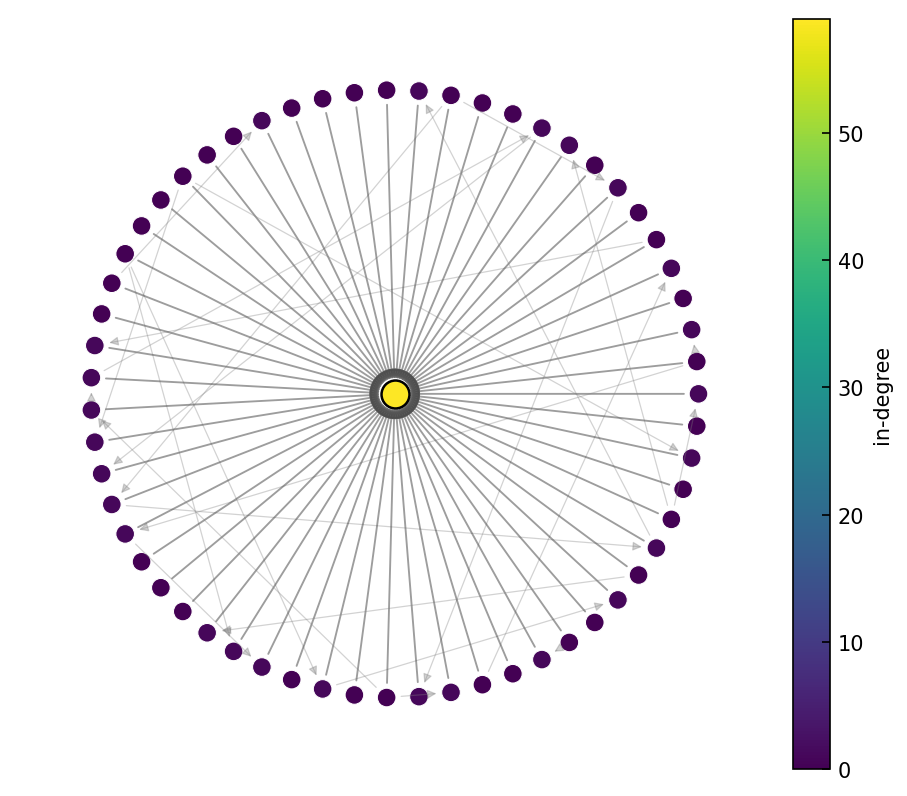

pearson [ 15.55984763  12.04095375  15.49924745  12.04095375  15.45679465
  12.04095375  12.04095375  15.43473886  12.04095375  15.49805217
  15.43511586  12.04095375  12.04095375  12.04095375  15.49137135
  12.04095375  12.04095375  12.04095375  12.04095375  15.40546743
  12.04095375  12.04095375  12.04095375  12.04095375  12.04095375
  12.04095375  12.04095375  12.04095375  15.45317691  15.38736645
  15.36213943  15.43991424  15.48188126  15.44907361  15.49559722
  12.04095375  12.04095375  12.04095375  15.4907434   15.52973888
  15.48019644  12.04095375  15.44862726  12.04095375  12.04095375
  15.50790377  15.35417629  12.04095375  12.04095375  15.46774555
  12.04095375  12.04095375  15.3943827   12.04095375  15.48089356
  12.04095375  12.04095375  15.48832174  12.04095375 111.24087228]
[A_N] classified as: A_N  | hubs: [59]
[[0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


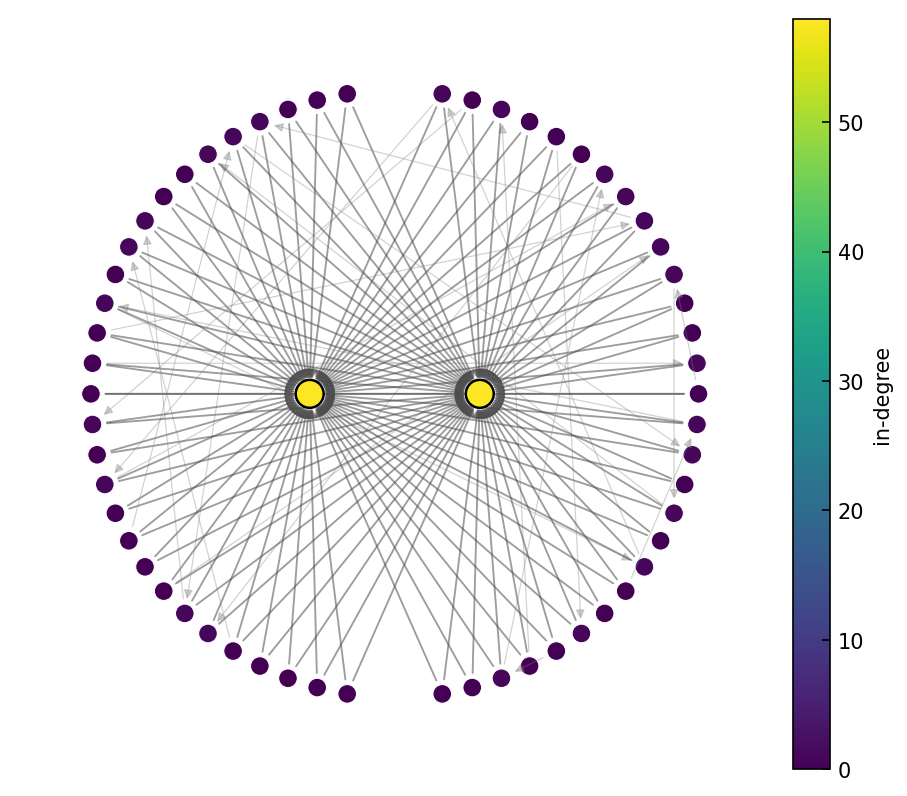

pearson [  6.13394534   6.13394534   6.95578418   6.13394534   6.13394534
   6.9598891    6.13394534   6.13394534   6.96324457   6.98161356
   6.13394534   6.13394534   6.13394534   6.95962131   6.13394534
   6.13394534   6.13394534   6.97532801   6.13394534   6.13394534
   6.13394534   6.13394534   6.13394534   6.13394534   6.98104724
   6.96910413   6.13394534   6.13394534   6.13394534   6.13394534
   6.96302904   6.95483161   6.13394534   6.95668289   6.94843732
   6.13394534   6.13394534   6.9748084    6.13394534   6.95844011
   6.13394534   6.13394534   6.97902882   6.97605949   6.13394534
   6.97038603   6.95148692   6.96652189   6.13394534   6.96101458
   6.13394534   6.96503873   6.13394534   6.96995095   6.9398205
   6.13394534   6.13394534   6.96546776 114.67655249 114.67635086]
[B_N] classified as: B_N and C_N  | hubs: [58 59]
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0.

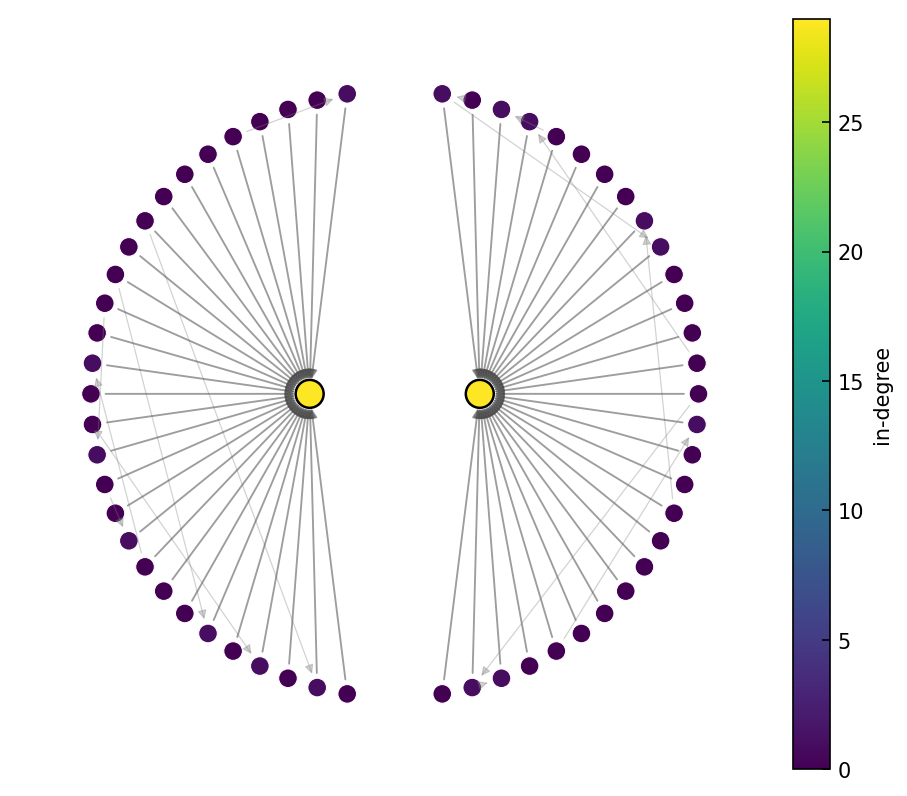

pearson [ 28.68164321  12.93455465  12.93455465  12.93455465  12.93455465
  12.93455465  12.93455465  12.93455465  12.93455465  12.93455465
  12.93455465  12.93455465  12.93455465  28.79956359  12.93455465
  12.93455465  28.77383467  12.93455465  12.93455465  28.87059756
  12.93455465  12.93455465  12.93455465  28.78658769  12.93455465
  28.77856884  12.93455465  28.81455314  12.93455465  12.93455465
  28.80807038  28.7232756   12.93455465  12.93455465  12.93455465
  12.93455465  12.93455465  12.93455465  12.93455465  12.93455465
  12.93455465  12.93455465  28.83734945  12.93455465  12.93455465
  12.93455465  12.93455465  12.93455465  28.74229796  28.80825775
  12.93455465  12.93455465  12.93455465  12.93455465  28.73934839
  28.70387203  12.93455465  28.72291815 108.60074607 108.60138508]
[C_N] classified as: B_N and C_N  | hubs: [58 59]
[OK] All figures & data saved to: figs/unknown_f_AvsBC_N60_T10000_discard600_M10_grid2048_ridge0_seed0_alpha0p25_ple0p01_din1_dout3_20250917-170610


In [739]:
if __name__ == "__main__":
    # ===== 你的实验超参（按需要修改）=====
    p_leaf_edge   = 0.01
    delta_in_max  = 1
    delta_out_max = 3
    seed_graph0   = 1            # 生成图/仿真的随机种子起点
    N, T, discard = 60, 10000, 600
    alpha         = 0.25       # 生成轨迹用；分类器对 f 未知
    M             = 10
    grid_size     = 2048
    ridge         = 0.0
    seed_clf      = 0            # 分类器/GMM 的随机种子

    # ---- (0) 一次运行的大文件夹（含时间戳+超参）----
    params = {
        "N": N, "T": T, "discard": discard,
        "M": M, "grid": grid_size, "ridge": ridge,
        "seed": seed_clf, "alpha": alpha,
        "p_leaf_edge": p_leaf_edge, "delta_in_max": delta_in_max, "delta_out_max": delta_out_max,
    }
    run_dir = build_run_dir_unknown_f(params, base_dir="figs", algo_tag="unknown_f_AvsBC")
    print(f"[RUN] output dir: {run_dir}")

    # ---- (1) 逐个段（A/B/C）生成 → 分类 → 各自子文件夹出图 ----
    seed_graph = seed_graph0
    for gname, maker in [("A_N", graph_A),
                         ("B_N", graph_B),
                         ("C_N", graph_C)]:

        # 1) 生成图（兼容 maker 有/无关键字两种接口）
        try:
            A = maker(N, p_leaf_edge=p_leaf_edge,
                         delta_in_max=delta_in_max,
                         delta_out_max=delta_out_max,
                         seed=seed_graph)
        except TypeError:
            A = maker(N)  # 回退老接口
        
        local_map = lambda x:Decimal(2)*x%Decimal(1)
        #local_map_number = lambda x: 2*x%1
        coupling  = coupling_cosxy
        
        gs = GraphSystemDecimal(A, alpha=alpha,local_map=local_map,coupling_fn=coupling, seed=seed_graph)
        seed_graph += 1

        # 2) 子文件夹：A_N / B_N / C_N
        subdir = ensure_subdir(run_dir, gname)

        # 3) 可选保存图结构（若有 gs.plot_graph）
        if hasattr(gs, "plot_graph"):
            try:
                gs.plot_graph(savepath=os.path.join(subdir, "graph.png"))
            except TypeError:
                try:
                    gs.plot_graph()
                    plt.savefig(os.path.join(subdir, "graph.png"), dpi=300, bbox_inches="tight")
                    plt.close()
                except Exception:
                    pass

        # 4) 仿真
        traj = gs.run(T, discard)

        # 5) 未知 f 的 A vs (B/C) 分类（返回 scores / distance_matrix）
        out = classify_A_vs_BC_unknown_f(
            traj=traj,
            M=M,
            grid_size=grid_size,
            ridge=ridge,
            seed=seed_clf,
            return_indices=True,
            return_fhat=True,
        )
        print(f"[{gname}] classified as: {out['label']}  | hubs: {out['hubs_idx']}")

        # 6) 保存三张图 + 数组（柱状图默认只标注 hub 序号；如需全部标注，annotate_bar='all'）
        node_labels = np.arange(traj.shape[0])  # 节点编号
        save_all_plots_unknown_f(
            result=out,
            outdir=subdir,
            node_labels=node_labels,
            title_suffix=f"{gname}, M={M}, grid={grid_size}, ridge={ridge}",
            annotate_bar="hubs"
        )

        # 7) 可选：保存该段的 \hat f 在网格上的预测（便于附录/验证）
        try:
            grid = np.linspace(0.0, 1.0, 64, endpoint=False)
            f_grid = evaluate_f_hat(out["f_hat"], grid)
            np.save(os.path.join(subdir, "f_hat_grid_x.npy"), grid)
            np.save(os.path.join(subdir, "f_hat_grid_fx.npy"), f_grid)
        except Exception:
            pass

    print(f"[OK] All figures & data saved to: {run_dir}")


In [ ]:
#用相关性估计

In [887]:
# >>> NEW: 环上差分（把差值映射到 [-0.5, 0.5) 以避免 0/1 跳变）
def moddiff(z: np.ndarray) -> np.ndarray:
    return ((z + 0.5) % 1.0) - 0.5

# >>> NEW: 默认的 m_h_vec —— 近似论文里的 v(y)
def m_h_vec_default(x: np.ndarray) -> np.ndarray:
    # v(y) = sin(2π y)，与你的默认扩散耦合项一致
    return np.sin(2.0 * np.pi * x)

# >>> NEW: 在两个 hub 上估计 beta，并计算噪声残差 xi_h(t)
def _compute_hub_residuals(traj: np.ndarray,
                           f_hat: TrigMap,
                           hubs_idx: np.ndarray,
                           m_h_vec: Callable[[np.ndarray], np.ndarray]) -> dict[int, np.ndarray]:
    xi: dict[int, np.ndarray] = {}
    for h in hubs_idx[:2]:
        xh = traj[h, :-1]            # 当前
        yh = traj[h,  1:]            # 下一步
        base = f_hat.predict_next(xh)          # \hat f(xh)
        r = moddiff(yh - base)                  # 剩余 = y - \hat f(x)
        s = m_h_vec(xh)                          # v(x)
        denom = float(np.dot(s, s) + 1e-12)
        beta = float(np.dot(r, s) / denom)      # 最小二乘 \hat beta
        xi[h] = moddiff(yh - base - beta * s)   # \xi_h(t)
    return xi

# >>> NEW: 用噪声相关性区分 B 与 C
def fit_mh_from_A_center(
    traj_A: np.ndarray,
    out_A_algo1: dict | None = None,
    M_mh: int = 10,
    ridge_mh: float = 0.0,
    eps: float = 1e-12,
) -> tuple[Callable[[np.ndarray], np.ndarray], dict]:
    """
    从 A 段中心节点的创新 r_A(t) 回归得到 \hat m_h(x) ≈ c * m_h(x) 的“形状函数”。

    参数
    ----
    traj_A : (N_A, T_A) A 段轨迹
    out_A_algo1 : 若已运行过 Algorithm 1.1 的结果，需包含:
        - 'label' == 'A_N'
        - 'hubs_idx' ：长度为 1 的中心节点索引
        - 'f_hat'    ：叶子池化拟合得到的 TrigMap
      若为 None，本函数会内部调用 classify_A_vs_BC_unknown_f 拟合这些量。
    M_mh : 回归的傅里叶阶数
    ridge_mh : 回归的 L2 正则
    eps : 数值稳定常数

    返回
    ----
    m_h_vec : Callable[x ndarray] -> ndarray
        向量化的 \hat m_h(x)（自动 L2 归一化，仅保留形状）
    info : dict
        记录 w、hub 索引、拟合残差等诊断信息
    """
    # 需要：fourier_design, TrigMap, classify_A_vs_BC_unknown_f 已在你的工程中定义
    N_A, T_A = traj_A.shape

    if out_A_algo1 is None:
        out_A_algo1 = classify_A_vs_BC_unknown_f(
            traj=traj_A, M=M_mh, grid_size=2048, ridge=0.0,
            seed=0, return_indices=True, return_fhat=True
        )

    assert out_A_algo1["label"] == "A_N", "fit_mh_from_A_center 需要 A 段。"
    hubA = int(np.atleast_1d(out_A_algo1["hubs_idx"])[0])
    f_hat_A: TrigMap = out_A_algo1["f_hat"]

    x = traj_A[hubA, :-1]
    y = traj_A[hubA,  1:]
    rA = moddiff(y - f_hat_A.predict_next(x))      # 创新

    Phi = fourier_design(x, M_mh)                  # (T-1, 2M_mh+1)

    if ridge_mh > 0.0:
        G = Phi.T @ Phi + ridge_mh * np.eye(Phi.shape[1])
        w = np.linalg.solve(G, Phi.T @ rA)
    else:
        w, *_ = np.linalg.lstsq(Phi, rA, rcond=None)

    # 形状函数 \hat m_h(x)=Phi(x)@w；为避免尺度影响，做单位 L2 归一化
    def m_h_vec(xnew: np.ndarray) -> np.ndarray:
        xnew = np.asarray(xnew).reshape(-1)
        Phi_new = fourier_design(xnew, M_mh)
        s = Phi_new @ w
        # 若 s 近零，返回零（上游回归会处理）；否则做 L2 归一化
        nrm = float(np.linalg.norm(s)) + eps
        return s / nrm

    info = {
        "hubA": hubA,
        "w_mh": w,
        "M_mh": M_mh,
        "ridge_mh": ridge_mh,
        "fit_resid_std": float(np.sqrt(np.mean((rA - Phi @ w) ** 2)))
    }
    return m_h_vec, info

def _compute_hub_residuals(
    traj: np.ndarray,
    f_hat: "TrigMap",
    hubs_idx: np.ndarray,
    m_h_vec: Callable[[np.ndarray], np.ndarray],
) -> dict[int, np.ndarray]:
    xi: dict[int, np.ndarray] = {}
    for h in hubs_idx[:2]:
        xh = traj[h, :-1]
        yh = traj[h,  1:]
        base = f_hat.predict_next(xh)
        r = moddiff(yh - base)
        s = m_h_vec(xh)                           # 这里用“学习到的 \hat m_h(x)”
        denom = float(np.dot(s, s) + 1e-12)
        beta = 0.0 if denom <= 1e-18 else float(np.dot(r, s) / denom)
        xi[h] = moddiff(yh - base - beta * s)
    return xi

def learn_mh_from_segment_via_hubs(
    traj: np.ndarray,
    hubs_idx: np.ndarray,
    local_map: Callable[[np.ndarray], np.ndarray],
    M_mh: int = 10,
    ridge_mh: float = 0.0,
    eps: float = 1e-12,
) -> tuple[Callable[[np.ndarray], np.ndarray], dict]:
    """
    在 *当前* B/C 段上，仅用两个 hub 的 (x_h(t), r_h(t)) 数据学习 \hat m_h(x) 的形状，
    其中 r_h(t) = wrap( x_h(t+1) - f(x_h(t)) )，f 由 local_map 给出。
    返回一个可向量化的 m_h_vec(x)和诊断信息。
    """
    hubs = np.atleast_1d(hubs_idx).astype(int)
    assert hubs.size >= 2, "需要两个 hub 索引用于学习 m_h。"

    X_list, R_list = [], []
    for h in hubs[:2]:
        x = traj[h, :-1]
        y = traj[h,  1:]
        r = moddiff(y - local_map(x))   # 创新：已知 f
        X_list.append(x)
        R_list.append(r)
    X = np.concatenate(X_list, axis=0)
    R = np.concatenate(R_list, axis=0)

    # 用傅里叶基拟合 m_h 形状：R ≈ Φ(X) w
    Phi = fourier_design(X, M_mh)  # (Tsum, 2M_mh+1)
    if ridge_mh > 0.0:
        G = Phi.T @ Phi + ridge_mh * np.eye(Phi.shape[1])
        w = np.linalg.solve(G, Phi.T @ R)
    else:
        w, *_ = np.linalg.lstsq(Phi, R, rcond=None)

    def m_h_vec(xnew: np.ndarray) -> np.ndarray:
        xnew = np.asarray(xnew).reshape(-1)
        Phi_new = fourier_design(xnew, M_mh)
        s = Phi_new @ w
        nrm = float(np.linalg.norm(s)) + eps  # 只要形状；尺度在下游回归会被吸收
        return s

    info = {
        "M_mh": M_mh,
        "ridge_mh": ridge_mh,
        "w_mh": w,
        "resid_std": float(np.sqrt(np.mean((R - Phi @ w) ** 2))),
        "num_points": int(R.size),
        "hubs_used": hubs[:2].tolist(),
    }
    return m_h_vec, info

def _compute_hub_residuals(
    traj: np.ndarray,
    hubs_idx: np.ndarray,
    m_h_vec: Callable[[np.ndarray], np.ndarray],
    local_map: Callable[[np.ndarray], np.ndarray] | None = None,
    f_hat: "TrigMap" | None = None,
) -> dict[int, np.ndarray]:
    """
    计算每个 hub 的噪声残差 xi_h(t)：
      r = wrap( y - base ), base = f(x)（已知 local_map）或 \hat f(x)；
      s = m_h_vec(x)；beta = <r,s>/<s,s>；xi = wrap(r - beta*s)。
    传参要求：local_map 与 f_hat 二者必须且只能给一个。
    """
    if (local_map is None) == (f_hat is None):
        raise ValueError("必须且只能提供 local_map 或 f_hat 其中一个。")

    xi: dict[int, np.ndarray] = {}
    for h in np.atleast_1d(hubs_idx).astype(int)[:2]:
        xh = traj[h, :-1]
        yh = traj[h,  1:]
        base = local_map(xh) if local_map is not None else f_hat.predict_next(xh)
        r = moddiff(yh - base)
        s = m_h_vec(xh)
        denom = float(np.dot(s, s) + 1e-12)
        beta = 0.0 if denom <= 1e-18 else float(np.dot(r, s) / denom)
        xi[h] = moddiff(r - s)
    return xi


# def classify_B_vs_C_by_correlation(
#     traj: np.ndarray,
#     hubs_idx: np.ndarray,
#     tau: float = 0.4,
#     m_h_vec: Callable[[np.ndarray], np.ndarray] | None = None,
#     local_map: Callable[[np.ndarray], np.ndarray] | None = None,
#     f_hat: "TrigMap" | None = None,
# ) -> dict[str, object]:
#     """
#     用两 hub 残差相关性判别 B/C。优先使用已知 local_map（真 f），否则用 \hat f。
#     需要传入从当前段学到的 m_h_vec（见 learn_mh_from_segment_via_hubs）。
#     """
#     if hubs_idx.size < 2:
#         return {"label_BC": None, "rho_hubs": None}
#     if m_h_vec is None:
#         raise ValueError("需要 m_h_vec（请用当前段从 hub 学习得到）。")

#     xi = _compute_hub_residuals(traj, hubs_idx, m_h_vec, local_map=local_map, f_hat=f_hat)
#     h1, h2 = int(hubs_idx[0]), int(hubs_idx[1])
#     v1 = xi[h1] - xi[h1].mean()
#     v2 = xi[h2] - xi[h2].mean()
#     denom = float(np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-12)
#     rho = float(np.dot(v1, v2) / denom)
#     return {"label_BC": "B_N" if rho >= tau else "C_N", "rho_hubs": rho, "hubs_idx": hubs_idx}


# def classify_B_vs_C_by_correlation(
#     traj: np.ndarray,
#     f_hat: "TrigMap",
#     hubs_idx: np.ndarray,
#     tau: float = 0.4,
#     m_h_vec: Callable[[np.ndarray], np.ndarray] | None = None,
# ) -> dict[str, object]:
#     if hubs_idx.size < 2:
#         return {"label_BC": None, "rho_hubs": None}
#     if m_h_vec is None:
#         raise ValueError("classify_B_vs_C_by_correlation 需要 m_h_vec（请从 A 段学习得到）。")

#     xi = _compute_hub_residuals(traj, f_hat, hubs_idx, m_h_vec)
#     h1, h2 = int(hubs_idx[0]), int(hubs_idx[1])
#     v1 = xi[h1] - xi[h1].mean()
#     v2 = xi[h2] - xi[h2].mean()
#     denom = float(np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-12)
#     rho = float(np.dot(v1, v2) / denom)
#     label_BC = "B_N" if rho >= tau else "C_N"
#     return {"label_BC": label_BC, "rho_hubs": rho, "hubs_idx": hubs_idx}


from typing import Tuple, Optional, Dict, Any
import numpy as np

def classify_B_vs_C_by_correlation_gated(
    traj: np.ndarray,
    hubs_idx: np.ndarray,
    m_h_vec,                                    # Callable[[np.ndarray], np.ndarray]
    local_map: Optional[Callable[[np.ndarray], np.ndarray]] = None,
    f_hat: Optional["TrigMap"] = None,
    tau: float = 0.4,
    # ---- 新增 gating 选项 ----
    x_window: Optional[Tuple[float, float]] = (0.4, 0.6),   # 在 t 时刻，两 hub 都落在该区间
    max_circ_diff: Optional[float] = None,                  # 在 t 时刻，两 hub 的圆环距离 <= 该阈值
    gate_logic: str = "or",                                 # "or"（默认）或 "and"：多条件如何组合
    min_count: int = 20,                                    # 最少有效样本数；不足则不给判别
    return_indices: bool = False,                           # 是否返回被选中的 t 索引
) -> Dict[str, Any]:
    """
    带“局部窗口/接近度”过滤的两 hub 残差相关性判别：
      - 先用你现有的 _compute_hub_residuals(...) 得到每个 hub 的残差序列 xi（长度 T-1）；
      - 在 t 时刻根据 hub 的状态 x(t) 做 gating（窗口/接近/两者组合）；
      - 只用通过 gating 的那些 t 的 xi[·][t]（即 t+1 的量）来计算相关系数 rho；
      - rho >= tau 判为 B_N，否则 C_N。

    说明：
    - gating 在 t 上做；而 xi[t] 对应的是 “t -> t+1”的残差，因此等价于“当 t 处于指定小区域时，
      统计下一时刻的残差相关性”，用以规避 E[u(x)] = 0 的问题。
    - max_circ_diff 使用圆环差（moddiff），更适合 [0,1) 的周期空间。
    """

    # 基本检查
    hubs_idx = np.atleast_1d(hubs_idx).astype(int)
    if hubs_idx.size < 2:
        return {"label_BC": None, "rho_hubs": None, "hubs_idx": hubs_idx}
    if m_h_vec is None:
        raise ValueError("需要 m_h_vec（请先用当前段从 hub 学出未单位化的 \\hat m_h）。")
    if (local_map is None) == (f_hat is None):
        # 与你现有设计一致：二者必须且只能给一个
        # 如果你允许“已知 f 优先，否则 f_hat”，可以改成不抛错、自动选择。
        raise ValueError("必须且只能提供 local_map 或 f_hat 其中一个。")

    # 1) 残差（用你已有的函数；不要改）
    xi_dict = _compute_hub_residuals(
        traj=traj, hubs_idx=hubs_idx, m_h_vec=m_h_vec,
        local_map=local_map, f_hat=f_hat
    )
    h1, h2 = int(hubs_idx[0]), int(hubs_idx[1])

    # 2) 在 t 时刻做 gating；xi 的时间索引与 x(t) 对齐（长度都是 T-1）
    x1_t = traj[h1, :-1]
    x2_t = traj[h2, :-1]

    conds = []
    if x_window is not None:
        lo, hi = x_window
        cond_win = (x1_t >= lo) & (x1_t <= hi) & (x2_t >= lo) & (x2_t <= hi)
        conds.append(cond_win)

    if max_circ_diff is not None:
        # 圆环差：使用你已有的 moddiff 使差值落在 (-0.5, 0.5]
        circ_diff = np.abs(moddiff(x1_t - x2_t))
        cond_diff = (circ_diff <= max_circ_diff)
        conds.append(cond_diff)

    if not conds:
        # 未给任何 gating 条件，则与原始版本等价（全量）
        mask = np.ones_like(x1_t, dtype=bool)
    else:
        if gate_logic.lower() == "and":
            mask = conds[0]
            for c in conds[1:]:
                mask = mask & c
        else:  # 默认 "or"
            mask = conds[0]
            for c in conds[1:]:
                mask = mask | c

    # 3) 只用被选中的 t 去取 xi[t]（即 t+1 的残差）
    r1 = xi_dict[h1][mask]
    r2 = xi_dict[h2][mask]
    n_eff = int(mask.sum())

    # 样本太少时不判别，返回 NaN/None
    if n_eff < max(3, min_count):
        out = {
            "label_BC": None,
            "rho_hubs": np.nan,
            "hubs_idx": hubs_idx,
            "n_effective": n_eff,
            "gate": {
                "x_window": x_window,
                "max_circ_diff": max_circ_diff,
                "gate_logic": gate_logic
            }
        }
        if return_indices:
            out["t_indices"] = np.nonzero(mask)[0]
        return out

    # 4) 计算相关系数（与原实现相同的规范化方式）
    v1 = r1 - r1.mean()
    v2 = r2 - r2.mean()
    denom = float(np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-12)
    rho = float(np.dot(v1, v2) / denom)

    out = {
        "label_BC": "B_N" if rho >= tau else "C_N",
        "rho_hubs": rho,
        "hubs_idx": hubs_idx,
        "n_effective": n_eff,
        "gate": {
            "x_window": x_window,
            "max_circ_diff": max_circ_diff,
            "gate_logic": gate_logic
        }
    }
    out["hub_resid_var"]=None
    out["V_hat"]=None
    if return_indices:
        out["t_indices"] = np.nonzero(mask)[0]
    return out


def classify_B_vs_C_by_correlation(
    traj: np.ndarray,
    hubs_idx: np.ndarray,
    tau: float = 0.4,
    m_h_vec: Callable[[np.ndarray], np.ndarray] | None = None,
    local_map: Callable[[np.ndarray], np.ndarray] | None = None,
    f_hat: "TrigMap" | None = None,
) -> dict[str, object]:
    """
    用两 hub 残差相关性判别 B/C。优先使用已知 local_map（真 f），否则用 \hat f。
    需要传入从当前段学到的 m_h_vec（见 learn_mh_from_segment_via_hubs）。
    """
    if hubs_idx.size < 2:
        return {"label_BC": None, "rho_hubs": None}
    if m_h_vec is None:
        raise ValueError("需要 m_h_vec（请用当前段从 hub 学习得到）。")

    xi = _compute_hub_residuals(traj, hubs_idx, m_h_vec, local_map=local_map, f_hat=f_hat)
    h1, h2 = int(hubs_idx[0]), int(hubs_idx[1])
    v1 = xi[h1] - xi[h1].mean()
    v2 = xi[h2] - xi[h2].mean()
    denom = float(np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-12)
    rho = float(np.dot(v1, v2) / denom)
    return {"label_BC": "B_N" if rho >= tau else "C_N", "rho_hubs": rho, "hubs_idx": hubs_idx}

# >>> NEW: 完整流水线：先 A vs (B/C)，若是 (B/C) 再做相关性分 B/C
# def classify_ABC_pipeline(traj: np.ndarray,
#                           M: int = 10,
#                           grid_size: int = 2048,
#                           ridge: float = 0.0,
#                           seed: int = 0,
#                           tau: float = 0.4,
#                           m_h_vec: Callable[[np.ndarray], np.ndarray] = m_h_vec_default
#                           local_map: Callable[[np.ndarray],np.ndarray]=lambda x:2*x%1
#                           ) -> dict[str, object]:
#     # 第一步：用你已有的方法做 A vs (B/C) 并重建 \hat f
#     out = classify_A_vs_BC_unknown_f(
#         traj=traj, M=M, grid_size=grid_size, ridge=ridge,
#         seed=seed, return_indices=True, return_fhat=True
#     )

#     label_A_BC = out["label"]
#     hubs_idx = out["hubs_idx"]
#     f_hat: TrigMap = out["f_hat"]

#     # 若为 A，直接返回
#     if label_A_BC == "A_N" or hubs_idx.size < 2:
#         out["label_final"] = "A_N"
#         out["label_BC"] = None
#         out["rho_hubs"] = None
#         return out

#     # 否则做相关性法区分 B/C
#     bc = classify_B_vs_C_by_correlation(
#         traj=traj, f_hat=f_hat, hubs_idx=hubs_idx, tau=tau, m_h_vec=m_h_vec
#     )
#     out.update(bc)
#     out["label_final"] = out["label_BC"]  # 最终是 B_N 或 C_N
#     return out

def classify_ABC_pipeline(
    traj: np.ndarray,
    M: int = 10,
    grid_size: int = 2048,
    ridge: float = 0.0,
    seed: int = 0,
    tau: float = 0.4,
    local_map: Callable[[np.ndarray], np.ndarray] = None,
    M_mh: int = 10,
    ridge_mh: float = 0.0,
) -> dict[str, object]:
    """
    单段输入：
      1) 先用 Algorithm 1.1 做 A vs (B/C)，并拿到 hubs 与 \hat f；
      2) 若判为 A，直接返回；
      3) 若判为 B/C：用“当前段两个 hub + 已知 f”学习 \hat m_h(x)；
      4) 用学习到的 \hat m_h + 已知 f 做残差相关性，给出 B/C。
    """
    # 1) A vs (B/C) + \hat f
    out = classify_A_vs_BC_unknown_f(
        traj=traj, M=M, grid_size=grid_size, ridge=ridge,
        seed=seed, return_indices=True, return_fhat=True
    )
    label_A_BC = out["label"]
    hubs_idx = out["hubs_idx"]
    f_hat: TrigMap = out["f_hat"]

    # 2) 若为 A，退出
    if label_A_BC == "A_N" or hubs_idx.size < 2:
        out["label_final"] = "A_N"
        out["label_BC"] = None
        out["rho_hubs"] = None
        out["mh_info"]=None
        out["hub_resid_var"]=None
        out["V_hat"]=None
        return out

    # 3) 用当前段学习 \hat m_h（仅用两个 hub）
    m_h_vec, mh_info = learn_mh_from_segment_via_hubs(
        traj=traj,
        hubs_idx=hubs_idx,
        local_map=local_map,
        M_mh=M_mh,
        ridge_mh=ridge_mh,
    )

    # 4) 残差相关性判别 B/C（优先用真 f）
    bc = classify_B_vs_C_by_correlation_gated(
        traj=traj, hubs_idx=hubs_idx, tau=tau,
        m_h_vec=m_h_vec, f_hat=f_hat
    )
    out.update(bc)
    out["label_final"] = out["label_BC"]
    out["mh_info"] = mh_info  # 记录 m_h 的拟合诊断
    return out


In [929]:
import numpy as np
from typing import Callable, Tuple, Dict, Any, Optional

# =============== 基础工具 ===============

def moddiff(z: np.ndarray) -> np.ndarray:
    """环上差分：把实数映射到 (-0.5, 0.5]。"""
    return ((z + 0.5) % 1.0) - 0.5


def _aggregate_by_bins(X: np.ndarray, R: np.ndarray, bins: int = 512) -> Tuple[np.ndarray, np.ndarray]:
    """
    把 x ∈ [0,1) 分箱，对每个 bin 的 r 取平均，得到 (x̄_bin, r̄_bin)。
    贴近“填表后对重复的 x 取平均”的做法；可有效抑制重复采样与异方差。
    """
    idx = np.floor(np.clip(X, 0, 1 - 1e-12) * bins).astype(int)
    sum_r = np.bincount(idx, weights=R, minlength=bins).astype(float)
    cnt   = np.bincount(idx, minlength=bins).astype(float)
    mask = cnt > 0
    x_bar = (np.arange(bins)[mask] + 0.5) / bins
    r_bar = sum_r[mask] / cnt[mask]
    return x_bar, r_bar


def _make_base_predictor(
    local_map: Optional[Callable[[np.ndarray], np.ndarray]] = None,
    f_hat: Optional["TrigMap"] = None,
) -> Callable[[np.ndarray], np.ndarray]:
    """
    统一构造基准预测器 base_predict(x)：
      - 若已知 f：base_predict(x) = local_map(x)
      - 若未知 f：base_predict(x) = f_hat.predict_next(x)
    两者必须且只能提供其一。
    """
    if (local_map is None) == (f_hat is None):
        raise ValueError("必须且只能提供 local_map（f 已知）或 f_hat（f 未知）其中一个。")
    if local_map is not None:
        return lambda x: local_map(x)
    return lambda x: f_hat.predict_next(x)


# =============== 学习 m_h(x)（不单位化，保留幅度） ===============

def learn_mh_from_current_segment(
    traj: np.ndarray,
    hubs_idx: np.ndarray,
    base_predict: Callable[[np.ndarray], np.ndarray],
    M_mh: int = 10,
    ridge_mh: float = 0.0,
    use_bin_avg: bool = True,
    bins_for_avg: int = 512,
) -> Tuple[Callable[[np.ndarray], np.ndarray], Dict[str, Any]]:
    """
    在 *当前* 段，用两个 hub 的 (x_h(t), r_h(t)) 学 \hat m_h(x)：
      r_h(t) = wrap( x_h(t+1) - base_predict(x_h(t)) ).
    返回：
      m_h_vec(x)：向量化 \hat m_h（不单位化，保留幅度）；
      info：诊断信息（权重、误差、样本量等）。
    依赖：fourier_design 已定义；hubs_idx 至少含两个下标。
    """
    hubs = np.atleast_1d(hubs_idx).astype(int)
    assert hubs.size >= 2, "学习 m_h 需要两个 hub。"

    X_list, R_list = [], []
    for h in hubs[:2]:
        x = traj[h, :-1]
        y = traj[h,  1:]
        r = moddiff(y - base_predict(x))
        X_list.append(x); R_list.append(r)
    X = np.concatenate(X_list, axis=0)
    R = np.concatenate(R_list, axis=0)

    if use_bin_avg:
        X_fit, R_fit = _aggregate_by_bins(X, R, bins=bins_for_avg)
    else:
        X_fit, R_fit = X, R

    Phi = fourier_design(X_fit, M_mh)
    if ridge_mh > 0.0:
        G = Phi.T @ Phi + ridge_mh * np.eye(Phi.shape[1])
        w = np.linalg.solve(G, Phi.T @ R_fit)
    else:
        w, *_ = np.linalg.lstsq(Phi, R_fit, rcond=None)

    def m_h_vec(xnew: np.ndarray) -> np.ndarray:
        xnew = np.asarray(xnew).reshape(-1)
        return fourier_design(xnew, M_mh) @ w   # ← 不单位化

    info = {
        "w_mh": w,
        "M_mh": M_mh,
        "ridge_mh": ridge_mh,
        "use_bin_avg": use_bin_avg,
        "bins_for_avg": bins_for_avg,
        "train_points": int(X_fit.size),
        "fit_resid_std": float(np.sqrt(np.mean((R_fit - fourier_design(X_fit, M_mh) @ w) ** 2))),
        "hubs_used": hubs[:2].tolist(),
    }
    return m_h_vec, info


# =============== 枢纽残差 + 相关性判别（通用：已知 f 或未知 f） ===============

def _compute_hub_residuals_with_mh(
    traj: np.ndarray,
    hubs_idx: np.ndarray,
    m_h_vec: Callable[[np.ndarray], np.ndarray],
    base_predict: Callable[[np.ndarray], np.ndarray],
) -> Tuple[Dict[int, np.ndarray], Dict[int, float]]:
    """
    对每个 hub：
      r = wrap( y - base_predict(x) ),
      s = m_h_vec(x),
      beta_hat = <r,s>/<s,s>,
      xi = wrap( r - beta_hat*s ).
    返回 xi 字典与每个 hub 的 beta_hat（≈ α d_h / Δ）。
    """
    xi: Dict[int, np.ndarray] = {}
    beta_hat: Dict[int, float] = {}
    for h in np.atleast_1d(hubs_idx).astype(int)[:2]:
        xh = traj[h, :-1]
        yh = traj[h,  1:]
        #r = moddiff(yh - base_predict(xh))
        r = moddiff(yh - base_predict(xh))
        s = m_h_vec(xh)
        denom = float(np.dot(s, s) + 1e-12)
        b = 0.0 if denom <= 1e-18 else float(np.dot(r, s) / denom)
        xi[h] = moddiff(r - s)
        beta_hat[h] = b
    return xi, beta_hat


# def classify_B_vs_C_by_correlation_with_mh(
#     traj: np.ndarray,
#     hubs_idx: np.ndarray,
#     m_h_vec: Callable[[np.ndarray], np.ndarray],
#     base_predict: Callable[[np.ndarray], np.ndarray],
#     tau: float = 0.4,
# ) -> Dict[str, Any]:
#     """
#     用 \hat m_h 去除确定项后计算两个 hub 的残差相关，判 B/C；
#     同时返回每个 hub 的 beta_hat（≈ α d_h / Δ）。
#     """
#     xi, beta_hat = _compute_hub_residuals_with_mh(traj, hubs_idx, m_h_vec, base_predict)
#     h1, h2 = int(hubs_idx[0]), int(hubs_idx[1])
#     v1 = xi[h1] - xi[h1].mean()
#     v2 = xi[h2] - xi[h2].mean()
#     denom = float(np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-12)
#     rho = float(np.dot(v1, v2) / denom)
#     return {
#         "label_BC": "B_N" if rho >= tau else "C_N",
#         "rho_hubs": rho,
#         "beta_hat": beta_hat
#     }


def classify_B_vs_C_by_correlation_with_mh(
    traj: np.ndarray,
    hubs_idx: np.ndarray,
    m_h_vec: Callable[[np.ndarray], np.ndarray],
    base_predict: Callable[[np.ndarray], np.ndarray],
    tau: float = 0.4,
) -> Dict[str, Any]:
    """
    用 \hat m_h 去除确定项后计算两个 hub 的残差相关，判 B/C；
    同时返回每个 hub 的 beta_hat（≈ α d_h / Δ）。
    【新增】同时返回两个 hub 的残差方差和它们的平均 V_hat。
    """
    xi, beta_hat = _compute_hub_residuals_with_mh(traj, hubs_idx, m_h_vec, base_predict)

    h1, h2 = int(hubs_idx[0]), int(hubs_idx[1])

    # 原有：相关系数用于 B/C 判别
    v1 = xi[h1] - xi[h1].mean()
    v2 = xi[h2] - xi[h2].mean()
    print(v1,v2)
    denom = float(np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-12)
    rho = float(np.dot(v1, v2) / denom)

    # 【新增】两个枢纽的残差方差（与你的 xi 定义一致）
    # 注：np.var(x) == mean((x-mean)^2)，等价于下面两行的写法
    hub_resid_var = {
        h1: float(np.mean(v1 * v1)),
        h2: float(np.mean(v2 * v2)),
    }
    V_hat = 0.5 * (hub_resid_var[h1] + hub_resid_var[h2])

    return {
        "label_BC": "B_N" if rho >= tau else "C_N",
        "rho_hubs": rho,
        "beta_hat": beta_hat,
        # 【新增输出】
        "hub_resid_var": hub_resid_var,
        "V_hat": V_hat,
        "v1":v1,
        "v2":v2
    }

# def classify_B_vs_C_by_correlation_with_mh(
#     traj: np.ndarray,
#     hubs_idx: np.ndarray,
#     m_h_vec: Callable[[np.ndarray], np.ndarray],
#     base_predict: Callable[[np.ndarray], np.ndarray],
#     tau: float = 0.4,
# ) -> Dict[str, Any]:
#     """
#     用 \hat m_h 去除确定项后计算两个 hub 的残差相关，判 B/C；
#     同时返回每个 hub 的 beta_hat（≈ α d_h / Δ）。
#     【新增】两个枢纽的残差方差（窗口内样本）和其平均 V_hat（窗口内样本）。

#     Gating 说明（接口不改，内部常量可手动改）：
#       - 先在 t 时刻筛选：两个 hub 的 x(t) 是否都在 [0.4, 0.6] 内；
#       - （可选）也可加“彼此接近”的条件：圆环差 <= MAX_CIRC_DIFF；
#       - 只用通过筛选的 t 的 xi[t]（即 t+1 的残差）计算相关性与方差。
#     """
#     # ---- 可调常量（不改接口，如需更小区间或加入接近度筛选，改这里） ----
#     X_WINDOW = (0.1, 0.2)   # t 时刻两个 hub 都必须落在该区间
#     MAX_CIRC_DIFF = None    # 例如设成 0.03 开启“彼此接近”筛选；None 表示不用
#     USE_OR = True           # True: 满足任一条件即可；False: 两条件都需满足
#     # -------------------------------------------------------------

#     # 1) 残差：按你的定义（xi = wrap(r - s)），以及每个 hub 的 beta_hat（未用于 xi）
#     xi, beta_hat = _compute_hub_residuals_with_mh(traj, hubs_idx, m_h_vec, base_predict)

#     h1, h2 = int(hubs_idx[0]), int(hubs_idx[1])
#     x1_t = traj[h1, :-1]  # 与 xi 对齐：长度 T-1，对应 t 的状态（用于筛 t）
#     x2_t = traj[h2, :-1]

#     # 2) 构造 gating mask（在 t 上筛选）
#     if X_WINDOW is not None:
#         lo, hi = X_WINDOW
#         mask_win = (x1_t >= lo) & (x1_t <= hi) & (x2_t >= lo) & (x2_t <= hi)
#     else:
#         mask_win = np.ones_like(x1_t, dtype=bool)

#     if MAX_CIRC_DIFF is not None:
#         # 圆环差：使用 moddiff 让差值落在 (-0.5, 0.5]，适合 [0,1) 的周期空间
#         mask_diff = np.abs(moddiff(x1_t - x2_t)) <= float(MAX_CIRC_DIFF)
#     else:
#         mask_diff = np.zeros_like(x1_t, dtype=bool)

#     if (X_WINDOW is not None) and (MAX_CIRC_DIFF is not None):
#         mask = (mask_win | mask_diff) if USE_OR else (mask_win & mask_diff)
#     elif X_WINDOW is not None:
#         mask = mask_win
#     elif MAX_CIRC_DIFF is not None:
#         mask = mask_diff
#     else:
#         mask = np.ones_like(x1_t, dtype=bool)

#     # 3) 取通过筛选的样本：用 t 的筛选，统计 t+1 的残差（即 xi[t]）
#     r1 = xi[h1][mask]
#     r2 = xi[h2][mask]
#     n_eff = int(mask.sum())

#     if n_eff == 0:
#         # 没有有效样本：返回安全的 NaN/None（键不变）
#         return {
#             "label_BC": None,
#             "rho_hubs": float("nan"),
#             "beta_hat": beta_hat,
#             "hub_resid_var": {h1: float("nan"), h2: float("nan")},
#             "V_hat": float("nan"),
#         }

#     # 4) 相关系数（与你原版一致的规范化）
#     v1 = r1 - r1.mean()
#     v2 = r2 - r2.mean()
#     denom = float(np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-12)
#     rho = float(np.dot(v1, v2) / denom)

#     # 5) 【新增】两个 hub 的窗口内残差方差 & 平均
#     hub_resid_var = {
#         h1: float(np.mean(v1 * v1)),
#         h2: float(np.mean(v2 * v2)),
#     }
#     V_hat = 0.5 * (hub_resid_var[h1] + hub_resid_var[h2])

#     return {
#         "label_BC": "B_N" if rho >= tau else "C_N",
#         "rho_hubs": rho,
#         "beta_hat": beta_hat,
#         "hub_resid_var": hub_resid_var,
#         "V_hat": V_hat,
#         "v1":v1,
#         "v2":v2
#     }
import numpy as np
from typing import Callable, Dict, Any, Optional, Tuple

# 若你已有 moddiff，请删掉这个兜底实现
def moddiff(d):
    """把差映射到 (-0.5, 0.5]，适合 [0,1) 的圆环空间。"""
    return ((d + 0.5) % 1.0) - 0.5

def _apply_vec(func: Callable[[np.ndarray], np.ndarray], x: np.ndarray) -> np.ndarray:
    """
    安全向量化：func 可能只支持标量，这里封装成向量输出。
    如果 func 已经支持向量输入，则直接返回。
    """
    y = func(x)
    y = np.asarray(y)
    if y.shape == x.shape:
        return y
    # 退化为逐点
    return np.asarray([func(float(xi)) for xi in x], dtype=float)

# def classify_B_vs_C_by_correlation_gated(
#     traj: np.ndarray,
#     hubs_idx: np.ndarray,
#     local_map: Callable[[np.ndarray], np.ndarray],
#     m_h_vec: Callable[[np.ndarray], np.ndarray],
#     tau: float = 0.4,
#     *,
#     # —— gating 参数（先挑 t）——
#     max_circ_diff: float = 0.03,                   # “极为接近”的圆环距离阈值（必用）
#     x_window: Optional[Tuple[float, float]] = None,# 可选：同时落在某个区间
#     gate_logic: str = "and",                       # "and" / "or" 用于合并 max_circ_diff 和 x_window
#     min_count: int = 20,                           # 样本太少就不判别
#     return_indices: bool = True,                   # 返回被选中的 t
# ) -> Dict[str, Any]:
#     """
#     先按“接近”在 t 上 gating -> 得到 T_G；
#     再仅在 T_G 上计算两个 hub 的残差 r_h(t) = wrap(x(t+1) - f(x(t)) - m_h(x(t)))；
#     最后对 (r_{h0}(t), r_{h1}(t))_{t in T_G} 做相关性，rho >= tau 判为 B_N，否则 C_N。
#     """
#     hubs_idx = np.atleast_1d(hubs_idx).astype(int)
#     assert hubs_idx.size >= 2, "需要两个枢纽索引"
#     h1, h2 = int(hubs_idx[0]), int(hubs_idx[1])

#     # 与 t 对齐的状态（长度 T-1）：用于“先挑 t”
#     x1_t = traj[h1, :-1]
#     x2_t = traj[h2, :-1]

#     # 1) 构造“极为接近”的 gate（必选）
#     mask_close = np.abs(moddiff(x1_t - x2_t)) <= float(max_circ_diff)

#     # 2) 可选：两者同时落在 x_window
#     if x_window is not None:
#         lo, hi = x_window
#         mask_win = (x1_t >= lo) & (x1_t <= hi) & (x2_t >= lo) & (x2_t <= hi)
#         if gate_logic.lower() == "or":
#             mask = mask_close | mask_win
#         else:
#             mask = mask_close & mask_win
#     else:
#         mask = mask_close

#     t_idx = np.nonzero(mask)[0]
#     n_eff = int(mask.sum())
#     if n_eff < max(3, min_count):
#         out = {
#             "label_BC": None,
#             "rho_hubs": np.nan,
#             "n_effective": n_eff,
#             "gate": {
#                 "max_circ_diff": max_circ_diff,
#                 "x_window": x_window,
#                 "gate_logic": gate_logic,
#             },
#             "hubs_idx": (h1, h2),
#         }
#         if return_indices:
#             out["t_indices"] = t_idx
#         return out

#     # 3) 只在被选中的 t 上计算残差：r_h(t) = wrap(x(t+1) - f(x(t)) - m_h(x(t)))
#     x1_sel = x1_t[mask]
#     x2_sel = x2_t[mask]
#     y1_sel = traj[h1, 1:][mask]
#     y2_sel = traj[h2, 1:][mask]

#     # 允许 local_map 和 m_h_vec 只支持标量输入：用 _apply_vec 包一层
#     f1 = _apply_vec(local_map, x1_sel)
#     f2 = _apply_vec(local_map, x2_sel)
#     mh1 = _apply_vec(m_h_vec, x1_sel)
#     mh2 = _apply_vec(m_h_vec, x2_sel)

#     r1 = moddiff(y1_sel - f1 - mh1)
#     r2 = moddiff(y2_sel - f2 - mh2)

#     # 4) 相关系数（中心化 + 归一化）
#     v1 = r1 - r1.mean()
#     v2 = r2 - r2.mean()
#     denom = float(np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-12)
#     rho = float(np.dot(v1, v2) / denom)

#     out = {
#         "label_BC": "B_N" if rho >= tau else "C_N",
#         "rho_hubs": rho,
#         "n_effective": n_eff,
#         "gate": {
#             "max_circ_diff": max_circ_diff,
#             "x_window": x_window,
#             "gate_logic": gate_logic,
#         },
#         "hubs_idx": (h1, h2),
#     }
#     if return_indices:
#         out["t_indices"] = t_idx
#     return out




import numpy as np
from typing import Callable, Dict, Any, Optional, Tuple

# def classify_B_vs_C_by_correlation_with_mh(
#     traj: np.ndarray,
#     hubs_idx: np.ndarray,
#     m_h_vec: Callable[[np.ndarray], np.ndarray],
#     base_predict: Callable[[np.ndarray], np.ndarray],
#     tau: float = 0.4,
# ) -> Dict[str, Any]:
#     """
#     先在 t 上以“极为接近”进行 gating（枢纽1与枢纽2的圆环差很小），
#     再仅在这些 t 上计算 r_h(t) = wrap(x(t+1) - base_predict(x(t)) - m_h_vec(x(t)))，
#     最后计算两枢纽残差相关性（rho >= tau 判 B_N，否则 C_N）。

#     与旧版保持相同的接口与 out 字段；但本版**不估计 beta**，
#     返回的 beta_hat 为 {h1: nan, h2: nan} 仅作占位，不参与任何计算。
#     """

#     # ---------------- 可调常量（不改函数签名） ----------------
#     # “极为接近”的圆环距离阈值：越小越严格，样本越少；建议 0.02~0.05 试验
#     MAX_CIRC_DIFF = 0.01

#     # 可选：也要求二者同时落在一个窗口；默认不用，仅保留开关
#     X_WINDOW: Optional[Tuple[float, float]] =  None  # 例如设为 (0.4, 0.6)
#     USE_OR = True  # 若启用窗口：False=两条件都满足；True=满足其一即可
#     # --------------------------------------------------------

#     # --- 小工具：安全向量化，兼容只接收标量的函数 ---
#     def _apply_vec(func: Callable[[np.ndarray], np.ndarray], x: np.ndarray) -> np.ndarray:
#         y = func(x)
#         y = np.asarray(y)
#         if y.shape == x.shape:
#             return y
#         return np.asarray([func(float(xi)) for xi in x], dtype=float)

#     # 取两个枢纽
#     hubs_idx = np.atleast_1d(hubs_idx).astype(int)
#     assert hubs_idx.size >= 2, "需要两个枢纽索引"
#     h1, h2 = int(hubs_idx[0]), int(hubs_idx[1])

#     # 与 t 对齐：长度 T-1
#     x1_t = traj[h1, :-1]
#     x2_t = traj[h2, :-1]
#     y1_t = traj[h1,  1:]
#     y2_t = traj[h2,  1:]

#     # 1) 先在 t 上做 gating：极为接近（必选）
#     # 说明：moddiff 需为你项目里已有的“圆环差”函数，映射到 (-0.5, 0.5]
#     circ_diff = np.abs(moddiff(x1_t - x2_t))
#     mask_close = (circ_diff <= float(MAX_CIRC_DIFF))

#     # 可选：两者同时落在一个窗口
#     if X_WINDOW is not None:
#         lo, hi = X_WINDOW
#         mask_win = (x1_t >= lo) & (x1_t <= hi) & (x2_t >= lo) & (x2_t <= hi)
#         mask = (mask_close | mask_win) if USE_OR else (mask_close & mask_win)
#     else:
#         mask = mask_close

#     n_eff = int(mask.sum())
#     if n_eff == 0:
#         # 和你原实现一致：没有有效样本时只返回核心字段，不含 v1/v2
#         return {
#             "label_BC": None,
#             "rho_hubs": float("nan"),
#             "beta_hat": {h1: float("nan"), h2: float("nan")},  # 不估计 beta，占位
#             "hub_resid_var": {h1: float("nan"), h2: float("nan")},
#             "V_hat": float("nan"),
#         }

#     # 只取门内 t 的 (x(t), x(t+1))
#     x1_sel, x2_sel = x1_t[mask], x2_t[mask]
#     y1_sel, y2_sel = y1_t[mask], y2_t[mask]

#     # 2) 在门内计算残差：r = wrap(y - f(x) - m_h(x))，不估计 beta
#     f1 = _apply_vec(base_predict, x1_sel)
#     f2 = _apply_vec(base_predict, x2_sel)
#     mh1 = _apply_vec(m_h_vec,     x1_sel)
#     mh2 = _apply_vec(m_h_vec,     x2_sel)

#     r1 = moddiff(y1_sel - f1 - mh1)
#     r2 = moddiff(y2_sel - f2 - mh2)

#     # 3) 相关性：中心化 + 归一化
#     v1 = r1 - r1.mean()
#     v2 = r2 - r2.mean()
#     denom = float(np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-12)
#     rho = float(np.dot(v1, v2) / denom)

#     # 4) 残差方差（门内）
#     hub_resid_var = {h1: float(np.mean(v1 * v1)),
#                      h2: float(np.mean(v2 * v2))}
#     V_hat = 0.5 * (hub_resid_var[h1] + hub_resid_var[h2])

#     return {
#         "label_BC": "B_N" if rho >= tau else "C_N",
#         "rho_hubs": rho,
#         "beta_hat": {h1: float("nan"), h2: float("nan")},  # 与旧接口一致，但不参与任何计算
#         "hub_resid_var": hub_resid_var,
#         "V_hat": V_hat,
#         "v1": v1,
#         "v2": v2,
#     }






import numpy as np
from typing import Callable, Dict, Any, Optional, Tuple

def classify_B_vs_C_by_correlation_with_mh_gated(
    traj: np.ndarray,
    hubs_idx: np.ndarray,
    m_h_vec: Callable[[np.ndarray], np.ndarray],
    base_predict: Callable[[np.ndarray], np.ndarray],
    tau: float = 0.4,
) -> Dict[str, Any]:
    """
    先在 t 上按“门”筛选（默认：区间门 [0.4,0.6]；可切换为“距离门”），
    再仅在被选中的 t 上计算残差:
        r_h(t) = wrap( x_h(t+1) - base_predict(x_h(t)) - m_h_vec(x_h(t)) )
    最后计算两枢纽残差相关性（rho >= tau 判 B_N，否则 C_N）。

    与旧版保持相同接口与输出字段；本实现 **不估计 beta**，
    返回的 beta_hat 仅占位 {h1: nan, h2: nan}。
    """
    # ================= 可调常量（不改函数签名） =================
    # 1) 核心门：区间门（默认启用）
    X_WINDOW: Optional[Tuple[float, float]] = (0.1,0.2)

    # 2) 第二实现：距离门（把 USE_CIRC_GATE 改为 True 即可启用）
    USE_CIRC_GATE: bool = False
    MAX_CIRC_DIFF: float = 0.01   # 距离门阈值（圆环差），建议 0.02~0.05 试验
    # ==========================================================

    # --- 若 base_predict / m_h_vec 仅标量输入，用该封装确保向量化 ---
    def _apply_vec(func: Callable[[np.ndarray], np.ndarray], x: np.ndarray) -> np.ndarray:
        y = func(x)
        y = np.asarray(y)
        if y.shape == x.shape:
            return y
        return np.asarray([func(float(xi)) for xi in x], dtype=float)

    hubs_idx = np.atleast_1d(hubs_idx).astype(int)
    assert hubs_idx.size >= 2, "需要两个枢纽索引"
    h1, h2 = int(hubs_idx[0]), int(hubs_idx[1])

    # 与 t 对齐：长度 T-1
    x1_t = traj[h1, :-1]
    x2_t = traj[h2, :-1]
    y1_t = traj[h1,  1:]
    y2_t = traj[h2,  1:]

    # ====================== 先挑 t：做“门” ======================
    if USE_CIRC_GATE:
        # —— 第二实现：距离门（彼此极为接近）——
        # 需要项目里的 moddiff：把差映射到 (-0.5, 0.5]
        circ_diff = np.abs(moddiff(x1_t - x2_t))
        mask = (circ_diff <= float(MAX_CIRC_DIFF))
    else:
        # —— 默认：区间门 [0.4, 0.6] ——（两枢纽同时在门内）
        assert X_WINDOW is not None and len(X_WINDOW) == 2
        lo, hi = X_WINDOW
        mask = (x1_t >= lo) & (x1_t <= hi) & (x2_t >= lo) & (x2_t <= hi)

    n_eff = int(mask.sum())
    if n_eff == 0:
        return {
            "label_BC": None,
            "rho_hubs": float("nan"),
            "beta_hat": {h1: float("nan"), h2: float("nan")},  # 不估计 beta，占位
            "hub_resid_var": {h1: float("nan"), h2: float("nan")},
            "V_hat": float("nan"),
        }

    # 只取门内 t 的 (x(t), x(t+1))
    x1_sel, x2_sel = x1_t[mask], x2_t[mask]
    y1_sel, y2_sel = y1_t[mask], y2_t[mask]

#     # ================== 再算残差（仅门内样本） ==================
    f1  = _apply_vec(base_predict, x1_sel)
    f2  = _apply_vec(base_predict, x2_sel)
    mh1 = _apply_vec(m_h_vec,     x1_sel)
    print(x1_sel,f1,mh1)
    #f1=2*x1_sel%1
    #f2=2*x2_sel%1
    mh2 = _apply_vec(m_h_vec,     x2_sel)
    
    mh1=1/2*np.sin(2*np.pi*x1_sel)
    mh2=1/2*np.sin(2*np.pi*x2_sel)
    
    #mh1=np.sin(2*math.pi*x1_sel)/2
    #mh2=np.sin(2*math.pi*x2_sel)/2

    r1 = moddiff(y1_sel - f1 - mh1)
    r2 = moddiff(y2_sel - f2 - mh2)

    # ==================== 相关性与方差 ====================
    v1 = r1 - r1.mean()
    v2 = r2 - r2.mean()
    v1=r1
    v2=r2
    denom = float(np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-12)
    rho = float(np.dot(v1, v2) / denom)

    hub_resid_var = {h1: float(np.mean(v1 * v1)),
                     h2: float(np.mean(v2 * v2))}
    V_hat = 0.5 * (hub_resid_var[h1] + hub_resid_var[h2])
    print("mh rho",rho)

    return {
        "label_BC": "B_N" if rho >= tau else "C_N",
        "rho_hubs": rho,
        "beta_hat": {h1: float("nan"), h2: float("nan")},  # 与旧接口一致
        "hub_resid_var": hub_resid_var,
        "V_hat": V_hat,
        "v1": v1,
        "v2": v2,
    }


# =============== 接口 1：f 已知（传 local_map） ===============

def classify_ABC_pipeline_known_f(
    traj: np.ndarray,
    local_map: Callable[[np.ndarray], np.ndarray],
    M: int = 10,
    grid_size: int = 2048,
    ridge: float = 0.0,
    seed: int = 0,
    tau: float = 0.4,
    M_mh: int = 10,
    ridge_mh: float = 0.0,
    use_bin_avg: bool = True,
    bins_for_avg: int = 512,
) -> Dict[str, Any]:
    """
    单段流水线（f 已知）：
      1) A vs (B/C)（可用你已有的 “local_map 已知版”或退回未知版）；
      2) 若 A，直接返回；
      3) 若 B/C：用当前段两个 hub 与已知 f 学 \hat m_h；
      4) 用 \hat m_h + 已知 f 做残差相关，输出 B/C 与 beta_hat。
    """
    # 1) A vs (B/C) + hubs（优先使用你已有的“已知 f 的版本”）
    try:
        # 你的函数：graph_type, hubs_idx, S = classify_A_and_BC_local_map_known(traj, local_map_scalar=local_map)
        graph_type, hubs_idx, _S = classify_A_and_BC_local_map_known(traj, local_map_scalar=local_map)
        label_A_BC = graph_type
        hubs_idx = np.atleast_1d(hubs_idx).astype(int)
        out = {"label": label_A_BC, "hubs_idx": hubs_idx}
    except NameError:
        # 若你未提供“已知 f”的版本，则回退到未知 f 的 A/BC（只用来取 hubs）
        out = classify_A_vs_BC_unknown_f(
            traj=traj, M=M, grid_size=grid_size, ridge=ridge,
            seed=seed, return_indices=True, return_fhat=False
        )
        label_A_BC = out["label"]
        hubs_idx = out["hubs_idx"]

    # 2) A 段直接返回
    if label_A_BC == "A_N" or hubs_idx.size < 2:
        out["label_final"] = "A_N"
        out["label_BC"] = None
        out["rho_hubs"] = None
        out["mh_info"]=None
        out["hub_resid_var"]=None
        out["V_hat"]=None
        return out

    # 3) 学 \hat m_h（当前段 + 已知 f）
    base_predict = _make_base_predictor(local_map=local_map, f_hat=None)
    m_h_vec, mh_info = learn_mh_from_current_segment(
        traj=traj, hubs_idx=hubs_idx, base_predict=base_predict,
        M_mh=M_mh, ridge_mh=ridge_mh, use_bin_avg=use_bin_avg, bins_for_avg=bins_for_avg
    )

    # 4) 残差相关判别 B/C
    bc = classify_B_vs_C_by_correlation_with_mh(
        traj=traj, hubs_idx=hubs_idx, m_h_vec=m_h_vec,
        base_predict=base_predict, tau=tau
    )
    out.update(bc)
    out["label_final"] = out["label_BC"]
    out["mh_info"] = mh_info
    out["hub_resid_var"]=None
    out["V_hat"]=None
    return out


# =============== 接口 2：f 未知（自动重构 f̂） ===============

def classify_ABC_pipeline_unknown_f(
    traj: np.ndarray,
    M: int = 10,
    grid_size: int = 2048,
    ridge: float = 0.0,
    seed: int = 0,
    tau: float = 0.4,
    M_mh: int = 10,
    ridge_mh: float = 0.0,
    use_bin_avg: bool = True,
    bins_for_avg: int = 512,
) -> Dict[str, Any]:
    """
    单段流水线（f 未知）：
      1) 用算法 1.1 做 A vs (B/C)，并得到 hubs 与 f̂；
      2) 若 A，返回；
      3) 若 B/C：用当前段两个 hub 与 f̂ 学 \hat m_h；
      4) 用 \hat m_h + f̂ 做残差相关，输出 B/C 与 beta_hat。
    """
    # 1) A vs (B/C) + f̂
    out = classify_A_vs_BC_unknown_f(
        traj=traj, M=M, grid_size=grid_size, ridge=ridge,
        seed=seed, return_indices=True, return_fhat=True
    )
    label_A_BC = out["label"]
    hubs_idx = out["hubs_idx"]
    f_hat: "TrigMap" = out["f_hat"]

    # 2) A 段直接返回
    if label_A_BC == "A_N" or hubs_idx.size < 2:
        out["label_final"] = "A_N"
        out["label_BC"] = None
        out["rho_hubs"] = None
        out["hub_resid_var"]=None
        out["V_hat"]=None
        out["mh_info"]=None
        return out

    # 3) 学 \hat m_h（当前段 + f̂）
    base_predict = _make_base_predictor(local_map=None, f_hat=f_hat)
    m_h_vec, mh_info = learn_mh_from_current_segment(
        traj=traj, hubs_idx=hubs_idx, base_predict=base_predict,
        M_mh=M_mh, ridge_mh=ridge_mh, use_bin_avg=use_bin_avg, bins_for_avg=bins_for_avg
    )

    # 4) 残差相关判别 B/C（用 f̂）
#     bc = classify_B_vs_C_by_correlation_with_mh(
#         traj=traj, hubs_idx=hubs_idx, m_h_vec=m_h_vec,
#         base_predict=base_predict, tau=tau
#     )
    bc = classify_B_vs_C_by_correlation_with_mh(
        traj=traj, hubs_idx=hubs_idx, m_h_vec=m_h_vec,base_predict=base_predict, tau=tau
    )
    out.update(bc)
    out["label_final"] = out["label_BC"]
    out["mh_info"] = mh_info
    return out


# =============== （可选）统一自动路由的包装 ===============

def classify_ABC_pipeline_auto(
    traj: np.ndarray,
    local_map: Optional[Callable[[np.ndarray], np.ndarray]] = None,
    **kwargs,
) -> Dict[str, Any]:
    """
    自动选择接口：
      - 若提供 local_map（f 已知）→ 调用 known_f 版本；
      - 否则（f 未知）→ 调用 unknown_f 版本。
    其余参数原样透传给对应的函数。
    """
    if local_map is not None:
        return classify_ABC_pipeline_known_f(traj=traj, local_map=local_map, **kwargs)
    return classify_ABC_pipeline_unknown_f(traj=traj, **kwargs)

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Dict, Any, Optional

def _simulate_measure_via_f(
    f_map: Callable[[np.ndarray], np.ndarray],
    n_iter: int = 10_000,
    discard: int = 600,
    seed: Optional[int] = 0,
    n_chains: int = 1,
    y0: Optional[np.ndarray] = None,
) -> np.ndarray:
    """
    用迭代 f_map 近似 f 的不变测度 λ：返回按 λ 采样得到的一维样本 y_s。
    - n_iter: 采样数（丢弃 burn-in 之后）
    - discard: burn-in 步数
    - n_chains: 可用多条链并行提升混合（可选）
    - y0: 自定义初值（在 [0,1)），若给定则覆盖 seed/n_chains 的设定
    """
    rng = np.random.default_rng(seed)
    if y0 is None:
        y = rng.random(n_chains)  # [0,1)
    else:
        y = np.asarray(y0, dtype=float).reshape(-1)
        n_chains = y.size

    samples = []
    total = discard + n_iter
    for t in range(total):
        y = f_map(y)
        if t >= discard:
            samples.append(y.copy())
    samples = np.stack(samples, axis=0)          # (n_iter, n_chains)
    y_samples = samples.reshape(-1)               # 拉直合成一条长样本
    return y_samples


def _mh_true_from_samples(
    h_true: Callable[[np.ndarray, np.ndarray], np.ndarray],
    y_samples: np.ndarray,
    x_grid: np.ndarray,
    chunk: int = 5000,
) -> np.ndarray:
    """
    通过对 y 按经验测度求均值，近似 m_h(x)=E_{y~λ}[h(x,y)]。
    为节省内存，按 y 的块做累加。
    约定：h_true 支持 numpy 广播：h_true(x[:,None], y[None,:]) -> (len(x), len(y))
    """
    y_samples = np.asarray(y_samples).ravel()
    x_grid = np.asarray(x_grid).ravel()

    accum = np.zeros_like(x_grid, dtype=float)
    n = y_samples.size
    for start in range(0, n, chunk):
        ys = y_samples[start:start+chunk]
        H = h_true(x_grid[:, None], ys[None, :])  # (Nx, chunk)
        accum += H.sum(axis=1)
    return accum / n


def plot_mh_comparison(
    m_h_vec: Callable[[np.ndarray], np.ndarray],
    h_true: Callable[[np.ndarray, np.ndarray], np.ndarray],
    f_map: Callable[[np.ndarray], np.ndarray],
    n_iter: int = 10_000,
    discard: int = 600,
    x_grid_size: int = 512,
    seed: int = 0,
    n_chains: int = 1,
    y0: Optional[np.ndarray] = None,
    title_prefix: str = "",
    return_data: bool = False,
) -> Dict[str, Any]:
    """
    对比 真实 m_h(x)=∫ h(x,y)dλ(y) 与 学到的 \hat m_h(x)：
      1) 用 f_map 迭代得到 y 的样本（近似 λ）；
      2) Monte Carlo 计算 m_h(x)；
      3) 画 m_h(x) vs \hat m_h(x) 的对比图，并画残差曲线。
    说明：不单位化（幅度原样保留）。
    """
    # 1) 用 f_map 近似不变测度 λ 的样本
    y_samples = _simulate_measure_via_f(
        f_map=f_map, n_iter=n_iter, discard=discard, seed=seed,
        n_chains=n_chains, y0=y0
    )

    # 2) x 网格与两条曲线
    x_grid = np.linspace(0.0, 1.0, x_grid_size, endpoint=False)
    mh_true = _mh_true_from_samples(h_true, y_samples, x_grid)
    mh_hat  = np.asarray(m_h_vec(x_grid)).reshape(-1)

    # 3) 误差指标
    residual = mh_hat - mh_true
    L2  = float(np.sqrt(np.mean(residual**2)))
    Linf = float(np.max(np.abs(residual)))
    MAE  = float(np.mean(np.abs(residual)))

    # 4) 作图（覆盖图 + 残差图；如只要一张图，注释掉第二个 figure 即可）
    # 覆盖图
    plt.figure()
    plt.plot(x_grid, mh_true, label=r"true $m_h(x)=\int h(x,y)\,d\lambda(y)$")
    plt.plot(x_grid, mh_hat,  linestyle='--', label=r"learned $\hat m_h(x)$")
    plt.xlabel(r"$x$")
    plt.ylabel(r"$m_h(x)$")
    if title_prefix:
        plt.title(f"{title_prefix}: true vs learned $m_h$ (n_iter={n_iter}, discard={discard})")
    plt.legend()
    plt.tight_layout()

    # 残差图（如不需要可删除）
    plt.figure()
    plt.plot(x_grid, residual)
    plt.xlabel(r"$x$")
    plt.ylabel(r"$\hat m_h(x)-m_h(x)$")
    if title_prefix:
        plt.title(f"{title_prefix}: residual")
    plt.tight_layout()

    out = {
        "x_grid": x_grid,
        "mh_true": mh_true,
        "mh_hat": mh_hat,
        "residual": residual,
        "L2": L2,
        "Linf": Linf,
        "MAE": MAE,
        "y_samples_count": int(y_samples.size),
    }
    return out if return_data else {}


In [930]:
# ====================== Correlation Visualization (Refactored) ======================
import os, time, json
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Dict, Any, Optional, Tuple, Sequence

# ---------- 工具 ----------
def _to_jsonable(obj):
    import numpy as np
    if isinstance(obj, dict):
        return {k: _to_jsonable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [_to_jsonable(v) for v in obj]
    if isinstance(obj, (np.integer,)):
        return int(obj)
    if isinstance(obj, (np.floating,)):
        return float(obj)
    if isinstance(obj, (np.bool_,)):
        return bool(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj

def moddiff(z: np.ndarray) -> np.ndarray:
    """环上差分：把实数映射到 (-0.5, 0.5]。"""
    return ((z + 0.5) % 1.0) - 0.5

# ---------- 1) 计算所有节点的 ξ_i(t)（β 已吸收进 m_h） ----------
def compute_xi_all_nodes(
    traj: np.ndarray,
    base_predict: Callable[[np.ndarray], np.ndarray],
    hubs_idx: Sequence[int],
    m_h_vec: Callable[[np.ndarray], np.ndarray],
) -> np.ndarray:
    """
    对每个节点 i 计算 ξ_i(t)：
      - hub:  ξ = wrap( y - base_predict(x) - m_h_vec(x) )   # β 已吸收到 m_h
      - leaf: ξ = wrap( y - base_predict(x) )
    返回 Xi, 形状 (N, T-1)
    """
    if m_h_vec is None:
        raise ValueError("m_h_vec must be the learned function (β absorbed).")

    N, T = traj.shape
    Xi = np.zeros((N, T - 1), dtype=float)
    hubs = set(int(h) for h in np.atleast_1d(hubs_idx).tolist())

    for i in range(N):
        x = traj[i, :-1]
        y = traj[i,  1:]
        base = base_predict(x)
        if i in hubs:
            Xi[i] = moddiff(y - base - m_h_vec(x))
        else:
            Xi[i] = moddiff(y - base)
    return Xi

# ---------- 2) 行相关矩阵 Corr(ξ_i, ξ_j) ----------
def corr_matrix_rows(X: np.ndarray) -> np.ndarray:
    """输入 X (N, T)，计算每两行的皮尔逊相关矩阵 C (N, N)。"""
    Xc = X - X.mean(axis=1, keepdims=True)
    std = np.linalg.norm(Xc, axis=1, keepdims=True) + 1e-12
    Xn = Xc / std
    C = Xn @ Xn.T
    np.fill_diagonal(C, 1.0)
    return C

# ---------- 3) 谱排序 ----------
def spectral_order(C: np.ndarray) -> np.ndarray:
    """用距离 D=1-C 的拉普拉斯矩阵的 Fiedler 向量排序。"""
    N = C.shape[0]
    if N <= 2:
        return np.arange(N)
    D = np.maximum(0.0, 1.0 - C)
    L = np.diag(D.sum(axis=1)) - D
    w, V = np.linalg.eigh(L)
    fiedler = V[:, np.argsort(w)[1]]
    return np.argsort(fiedler)

def _order_with_hubs_front(order: np.ndarray, hubs_idx: Sequence[int], N: int) -> np.ndarray:
    """把两个 hub 移到前两位（左上角），其余保持 `order` 相对次序不变。"""
    order_list = list(np.asarray(order).tolist()) if order is not None else list(range(N))
    hubs_first = [int(h) for h in np.atleast_1d(hubs_idx).astype(int)[:2] if 0 <= int(h) < N]
    # 从 order_list 中移除 hubs
    for h in hubs_first:
        if h in order_list:
            order_list.remove(h)
    return np.array(hubs_first + order_list, dtype=int)

# ---------- 4) 热力图 ----------
def plot_correlation_heatmap(
    C: np.ndarray,
    hubs_idx: Sequence[int],
    outpath: str,
    title: str = "",
    order: Optional[np.ndarray] = None,
    put_hubs_top_left: bool = True,
    vmin: float = -1.0,
    vmax: float = 1.0,
) -> None:
    """
    绘制相关性矩阵热图；可选：
      - order：预排序索引；
      - put_hubs_top_left=True：把两个 hub 放到左上角，便于“交叉单元即 hub—hub 相关性”的解读。
    """
    N = C.shape[0]
    if order is None:
        order = np.arange(N)
    if put_hubs_top_left:
        order = _order_with_hubs_front(order, hubs_idx, N)

    C_ord = C[np.ix_(order, order)]
    hubs_idx = np.atleast_1d(hubs_idx).astype(int)
    hub_pos = [int(np.where(order == h)[0][0]) for h in hubs_idx if 0 <= int(h) < N][:2]

    fig, ax = plt.subplots(figsize=(6.6, 5.4))
    im = ax.imshow(C_ord, origin="lower", aspect="auto", vmin=vmin, vmax=vmax)
    ax.set_title(title or "Corr(ξ_i, ξ_j) heatmap")
    ax.set_xlabel("node (sorted)")
    ax.set_ylabel("node (sorted)")
    cbar = fig.colorbar(im, ax=ax, shrink=0.82)
    cbar.set_label("Pearson correlation")

    # 高亮 hub 行/列与标签
    for k, pos in enumerate(hub_pos):
        ax.axhline(pos, linestyle="--", linewidth=1.0, color="white")
        ax.axvline(pos, linestyle="--", linewidth=1.0, color="white")
        ax.text(-0.6, pos, f"H{k}", va="center", ha="right", fontsize=8, color="white")
        ax.text(pos, -0.8, f"H{k}", va="top", ha="center", fontsize=8, color="white", rotation=90)

    # 若两个 hub 都在图中，标注左上角交叉（hub-hub）相关性
    if len(hub_pos) >= 2:
        p0, p1 = hub_pos[0], hub_pos[1]
        rho_hubs = float(C_ord[p0, p1])
        ax.text(1.5, 3, f"{rho_hubs:.2f}", color="white", ha="center", va="center",
                fontsize=8, bbox=dict(facecolor="black", alpha=0.35, pad=1.5))
        ax.text(-8, 4, r"$\rho(H_0,H_1)$", color="white", ha="left", va="top", fontsize=8)

    plt.tight_layout()
    fig.savefig(outpath, dpi=240, bbox_inches="tight")
    plt.close(fig)

# ---------- 5) 与 hub 的相关性柱形图 ----------
def plot_corr_bars_to_hubs(C: np.ndarray, hubs_idx: Sequence[int], outpath: str) -> None:
    N = C.shape[0]
    hubs_idx = np.atleast_1d(hubs_idx).astype(int)
    x = np.arange(N)

    fig, ax = plt.subplots(figsize=(max(8, N * 0.18), 4.0))
    if len(hubs_idx) >= 2:
        h0, h1 = int(hubs_idx[0]), int(hubs_idx[1])
        ax.bar(x - 0.2, C[:, h0], width=0.4, label=f"corr to hub {h0}", alpha=0.9)
        ax.bar(x + 0.2, C[:, h1], width=0.4, label=f"corr to hub {h1}", alpha=0.9)
        ax.text(0.01, 0.98, f"corr(hub {h0}, hub {h1}) = {C[h0, h1]:.4f}",
                transform=ax.transAxes, ha="left", va="top")
        for k, h in enumerate([h0, h1]):
            ax.axvline(h, linestyle="--", linewidth=1.0)
            ax.text(h, 1.03, f"H{k}", ha="center", va="bottom")
    elif len(hubs_idx) == 1:
        h = int(hubs_idx[0])
        ax.bar(x, C[:, h], width=0.6, label=f"corr to hub {h}", alpha=0.9)
        ax.axvline(h, linestyle="--", linewidth=1.0)
        ax.text(h, 1.03, "H0", ha="center", va="bottom")

    ax.set_ylim(-1.05, 1.05)
    ax.set_xlabel("node index")
    ax.set_ylabel("correlation")
    ax.legend()
    plt.tight_layout()
    fig.savefig(outpath, dpi=240, bbox_inches="tight")
    plt.close(fig)

# ---------- 6) 保存“B/C 相关性”图与数据 ----------
def save_bc_correlation_figures(
    traj: np.ndarray,
    result: Dict[str, Any],
    outdir_graph: str,
    params: Dict[str, Any],
    tau: float = 0.4,
    m_h_vec: Optional[Callable[[np.ndarray], np.ndarray]] = None,  # 若 None 则自动学习
    M_mh: int = 10,
    ridge_mh: float = 0.0,
    use_bin_avg: bool = True,
    bins_for_avg: int = 512,
) -> str:
    """
    在 outdir_graph 下创建子目录并保存：
      - Corr(ξ_i, ξ_j) 热力图（raw 与 spectral；默认把 hubs 放到左上角），
      - 每个节点对两个枢纽的相关性条形图，
      - Xi、C 与 meta.json。
    说明：若 m_h_vec 为 None，则使用当前段数据 + result['f_hat'] 自动学习 \hat m_h。
    """
    hubs_idx = np.atleast_1d(result.get("hubs_idx", np.array([], dtype=int))).astype(int)
    if hubs_idx.size == 0:
        raise ValueError("hubs_idx 为空，无法绘制 B/C 相关性可视化。")

    # base 预测器
    if "f_hat" not in result:
        raise KeyError("result 中缺少 'f_hat'，无法进行 base 预测。")
    f_hat = result["f_hat"]
    base_predict = f_hat.predict_next  # 统一为可调用对象

    # 若未显式传入 m_h，自动学习本段的 \hat m_h
    if m_h_vec is None:
        m_h_vec, mh_info = learn_mh_from_current_segment(
            traj=traj, hubs_idx=hubs_idx, base_predict=base_predict,
            M_mh=M_mh, ridge_mh=ridge_mh, use_bin_avg=use_bin_avg, bins_for_avg=bins_for_avg
        )
    else:
        mh_info = {"note": "m_h_vec provided by caller; skip learning."}

    # 1) 计算 ξ 与相关矩阵
    Xi = compute_xi_all_nodes(traj, base_predict, hubs_idx, m_h_vec)
    C  = corr_matrix_rows(Xi)

    # 2) 目录名（含超参+时间戳）
    ts   = time.strftime("%Y%m%d_%H%M%S")
    M    = int(params.get("M", 10))
    grid = int(params.get("grid", params.get("grid_size", 2048)))
    ridge= float(params.get("ridge", 0.0))
    sub = os.path.join(outdir_graph, f"BCCorrelation_M{M}_G{grid}_ridge{ridge}_tau{tau}_{ts}")
    os.makedirs(sub, exist_ok=True)

    # 3) 保存关键数据
    np.save(os.path.join(sub, "xi_all.npy"), Xi)
    np.save(os.path.join(sub, "corr_matrix.npy"), C)
    meta = {
        "label_A_vs_BC": result.get("label"),
        "label_final": result.get("label_final"),
        "label_BC": result.get("label_BC"),
        "rho_hubs": result.get("rho_hubs"),
        "hubs_idx": hubs_idx.tolist(),
        "tau": tau,
        "params": params,
        "mh_info": _to_jsonable(mh_info),
    }
    with open(os.path.join(sub, "meta.json"), "w", encoding="utf-8") as f:
        json.dump(_to_jsonable(meta), f, indent=2, ensure_ascii=False)

    # 4) 热力图（原始序 + 谱序；均把 hubs 放到左上角）
    plot_correlation_heatmap(
        C, hubs_idx, outpath=os.path.join(sub, "corr_heatmap_raw.png"),
        title="Corr($\\xi_i$, $\\xi_j$) heatmap (raw order)",
        order=np.arange(C.shape[0]), put_hubs_top_left=True
    )
    order = spectral_order(C)
    plot_correlation_heatmap(
        C, hubs_idx, outpath=os.path.join(sub, "corr_heatmap_spectral.png"),
        title="Corr($\\xi_i$, $\\xi_j$) heatmap (spectral order)",
        order=order, put_hubs_top_left=True
    )

    # 5) 与 hub 的相关性柱形图
    plot_corr_bars_to_hubs(C, hubs_idx, outpath=os.path.join(sub, "corr_to_hubs_bar.png"))

    # 6) 若有两个 hub，记录判断用的 corr 值
    if len(hubs_idx) >= 2:
        h0, h1 = int(hubs_idx[0]), int(hubs_idx[1])
        with open(os.path.join(sub, "BC_decision.txt"), "w") as f:
            f.write(f"label_BC={result.get('label_BC')}, rho={C[h0, h1]:.6f}, tau={tau}\n")

    return sub
# ==================== End of Correlation Visualization (Refactored) ==================


[RUN] output dir: figs/unknown_f_AvsBC_N20_T10000_discard600_M10_grid2048_ridge0_seed0_alpha0p25_ple0_din1_dout3_20250918-180415
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

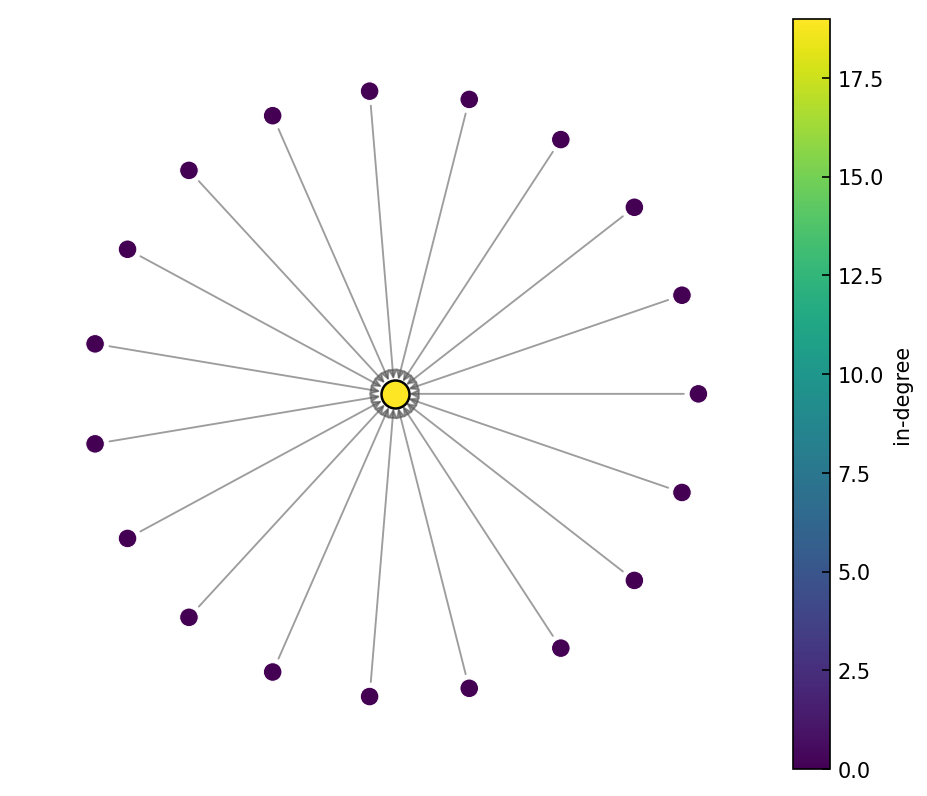

pearson [ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2. 38.]
[A_N] classified as: A_N (A/B/C) | hubs: [19] | rho=None| hub_resid_var=None,V_hat=None
[A_N] BC correlation figures saved at: figs/unknown_f_AvsBC_N20_T10000_discard600_M10_grid2048_ridge0_seed0_alpha0p25_ple0_din1_dout3_20250918-175254/C_N/BCCorrelation_M10_G2048_ridge0.0_tau0.3_20250918_175347 Var is
[OK] All figures & data saved to: figs/unknown_f_AvsBC_N20_T10000_discard600_M10_grid2048_ridge0_seed0_alpha0p25_ple0_din1_dout3_20250918-180415
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0

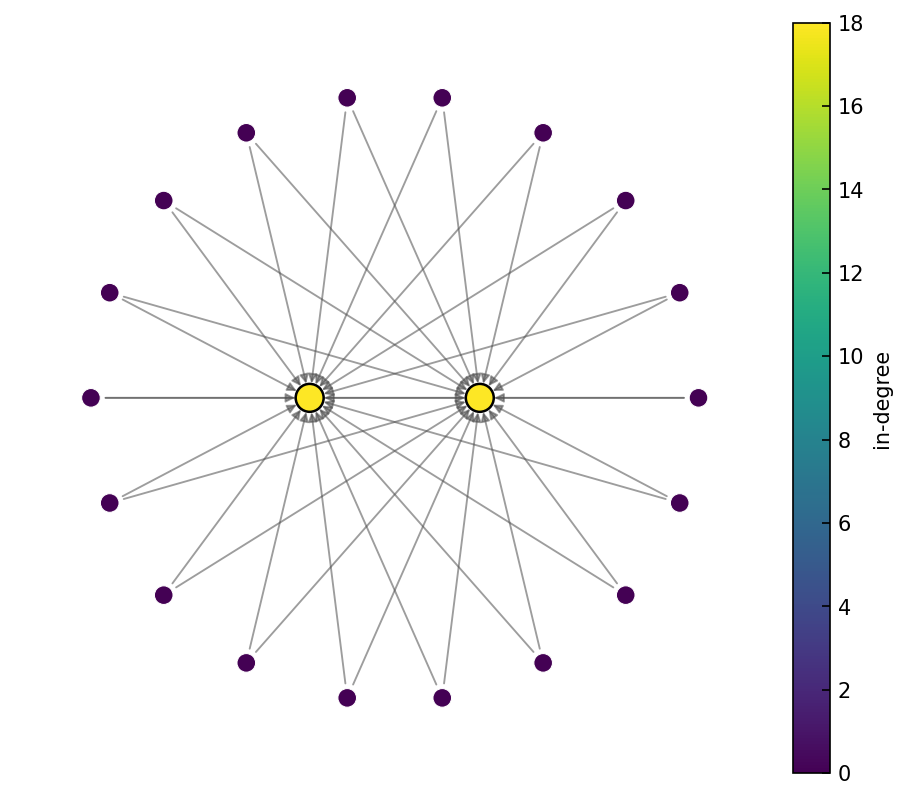

pearson [ 3.99999988  3.99999988  3.99999988  3.99999988  3.99999988  3.99999988
  3.99999988  3.99999988  3.99999988  3.99999988  3.99999988  3.99999988
  3.99999988  3.99999988  3.99999988  3.99999988  3.99999988  3.99999988
 35.99999915 35.99999915]
[ 3.48410541e-04 -7.98940274e-04 -3.27622258e-05 ... -6.54199218e-04
  6.88964544e-04  4.28843134e-05] [ 0.00055718  0.00035729 -0.00030651 ... -0.0003216   0.00387433
  0.00103146]
[B_N] classified as: C_N (A/B/C) | hubs: [18 19] | rho=-0.008362011285120012| hub_resid_var={18: 1.0207555923657055e-06, 19: 1.1055095278309196e-06},V_hat=1.0631325600983126e-06
[B_N] BC correlation figures saved at: figs/unknown_f_AvsBC_N20_T10000_discard600_M10_grid2048_ridge0_seed0_alpha0p25_ple0_din1_dout3_20250918-180415/B_N/BCCorrelation_M10_G2048_ridge0.0_tau0.3_20250918_180457 Var is
[OK] All figures & data saved to: figs/unknown_f_AvsBC_N20_T10000_discard600_M10_grid2048_ridge0_seed0_alpha0p25_ple0_din1_dout3_20250918-180415
[[0. 0. 0. 0. 0. 0. 0. 0.

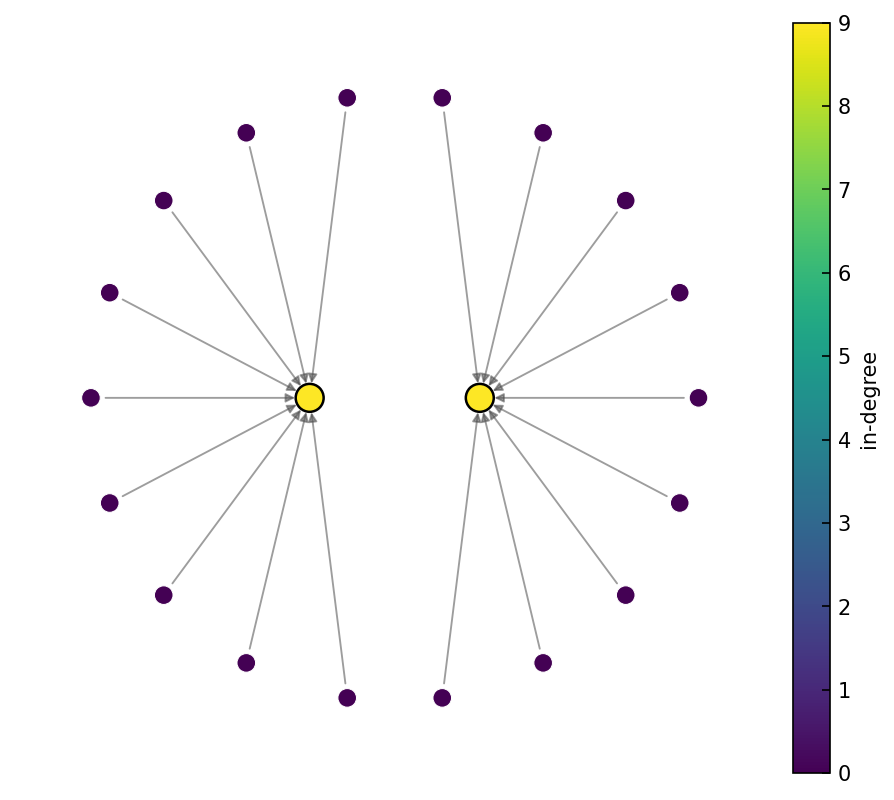

pearson [ 3.99999996  3.99999996  3.99999996  3.99999996  3.99999996  3.99999996
  3.99999996  3.99999996  3.99999996  3.99999996  3.99999996  3.99999996
  3.99999996  3.99999996  3.99999996  3.99999996  3.99999996  3.99999996
 35.99999971 35.99999971]
[-3.76829902e-04 -6.80520079e-04 -9.94202265e-05 ...  1.75951246e-04
  5.27519176e-04 -3.28290602e-04] [ 0.00046614 -0.00041582 -0.00065671 ...  0.00137297  0.0004184
  0.00018292]
[C_N] classified as: C_N (A/B/C) | hubs: [18 19] | rho=0.001403274363782593| hub_resid_var={18: 1.0835454252703138e-06, 19: 1.0779626762311591e-06},V_hat=1.0807540507507366e-06
[C_N] BC correlation figures saved at: figs/unknown_f_AvsBC_N20_T10000_discard600_M10_grid2048_ridge0_seed0_alpha0p25_ple0_din1_dout3_20250918-180415/C_N/BCCorrelation_M10_G2048_ridge0.0_tau0.3_20250918_180515 Var is
[OK] All figures & data saved to: figs/unknown_f_AvsBC_N20_T10000_discard600_M10_grid2048_ridge0_seed0_alpha0p25_ple0_din1_dout3_20250918-180415


In [931]:
if __name__ == "__main__":
    # ===== 你的实验超参（按需要修改）=====
    p_leaf_edge   = 0.00
    delta_in_max  = 1
    delta_out_max = 3
    seed_graph0   = 1            # 生成图/仿真的随机种子起点
    N, T, discard = 20, 10000, 600
    alpha         = 0.25       # 生成轨迹用；分类器对 f 未知
    M             = 10
    grid_size     = 2048
    ridge         = 0.0
    seed_clf      = 0            # 分类器/GMM 的随机种子

    # ---- (0) 一次运行的大文件夹（含时间戳+超参）----
    params = {
        "N": N, "T": T, "discard": discard,
        "M": M, "grid": grid_size, "ridge": ridge,
        "seed": seed_clf, "alpha": alpha,
        "p_leaf_edge": p_leaf_edge, "delta_in_max": delta_in_max, "delta_out_max": delta_out_max,
    }
    run_dir = build_run_dir_unknown_f(params, base_dir="figs", algo_tag="unknown_f_AvsBC")
    print(f"[RUN] output dir: {run_dir}")

    # ---- (1) 逐个段（A/B/C）生成 → 分类 → 各自子文件夹出图 ----
    seed_graph = seed_graph0
    for gname, maker in [("A_N", graph_A),
                         ("B_N", graph_B),
                         ("C_N", graph_C)]:

        # 1) 生成图（兼容 maker 有/无关键字两种接口）
        try:
            A = maker(N, p_leaf_edge=p_leaf_edge,
                         delta_in_max=delta_in_max,
                         delta_out_max=delta_out_max,
                         seed=seed_graph)
        except TypeError:
            A = maker(N)  # 回退老接口
        
        local_map = lambda x:Decimal(2)*x%Decimal(1)
        local_map_number = lambda x: 2*x%1
        #coupling  = coupling_sin2pixsin2piy
        coupling  = coupling_sin2pixy
        
        
        coupling_number=lambda x,y:y
        gs = GraphSystemDecimal(A, alpha=alpha,local_map=local_map,coupling_fn=coupling, seed=seed_graph)
        seed_graph += 1

        # 2) 子文件夹：A_N / B_N / C_N
        subdir = ensure_subdir(run_dir, gname)

        # 3) 可选保存图结构（若有 gs.plot_graph）
        if hasattr(gs, "plot_graph"):
            try:
                gs.plot_graph(savepath=os.path.join(subdir, "graph.png"))
            except TypeError:
                try:
                    gs.plot_graph()
                    plt.savefig(os.path.join(subdir, "graph.png"), dpi=300, bbox_inches="tight")
                    plt.close()
                except Exception:
                    pass

        # 4) 仿真
        traj = gs.run(T, discard)
        #print(traj.shape)
        #print(traj[:,0],traj[:,1],traj[:,2])

        # 5) 未知 f 的 A vs (B/C) 分类（返回 scores / distance_matrix）
        out = classify_ABC_pipeline_auto(
            traj=traj,
            M=M,
            grid_size=grid_size,
            ridge=ridge,
            seed=seed_clf,
            tau=0.3,                       # 论文建议 0.3~0.6；默认 0.3

            
        )
        
        
        
        print(f"[{gname}] classified as: {out['label_final']} (A/B/C) | hubs: {out['hubs_idx']} | rho={out.get('rho_hubs')}| hub_resid_var={out['hub_resid_var']},V_hat={out['V_hat']}")

        # 6) 保存三张图 + 数组（柱状图默认只标注 hub 序号；如需全部标注，annotate_bar='all'）
        node_labels = np.arange(traj.shape[0])  # 节点编号
        save_all_plots_unknown_f(
            result=out,
            outdir=subdir,
            node_labels=node_labels,
            title_suffix=f"{gname}, M={M}, grid={grid_size}, ridge={ridge}",
            annotate_bar="hubs"
        )
        if out["label_final"] != "A_N":
            bc_corr_dir = save_bc_correlation_figures(
                traj=traj,
                result=out,
                outdir_graph=subdir,     # 就放在该段的子文件夹下
                params=params,
                tau=0.3,                 # 与分类用阈值一致
            
            )
        print(f"[{gname}] BC correlation figures saved at: {bc_corr_dir}","Var is",)
        
#         if out["mh_info"] is not None:
#             _ = plot_mh_comparison(
#                 m_h_vec=out["mh_info"],
#                 h_true=coupling_number,
#                 f_map=local_map_number,
#                 n_iter=10_000,
#                 discard=600,
#                 x_grid_size=512,
#                 seed=0,
#                 title_prefix="Algorithm 2 (mh comparison)",
#                 return_data=False
#             )

        # 7) 可选：保存该段的 \hat f 在网格上的预测（便于附录/验证）
        try:
            grid = np.linspace(0.0, 1.0, 64, endpoint=False)
            f_grid = evaluate_f_hat(out["f_hat"], grid)
            np.save(os.path.join(subdir, "f_hat_grid_x.npy"), grid)
            np.save(os.path.join(subdir, "f_hat_grid_fx.npy"), f_grid)
        except Exception:
            pass

        print(f"[OK] All figures & data saved to: {run_dir}")


In [ ]:
#方差算法使用预测方差和实际方差（基于N的估计）

In [461]:
# ===================== Utilities for this BC matching demo =====================
import os, time, json
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Dict, Any, List, Tuple

# ---- JSON 安全化（避免 numpy 类型报错）----
def _to_jsonable(obj):
    import numpy as np
    if isinstance(obj, dict):   return {k:_to_jsonable(v) for k,v in obj.items()}
    if isinstance(obj, (list,tuple)): return [_to_jsonable(v) for v in obj]
    if isinstance(obj, (np.integer,)):  return int(obj)
    if isinstance(obj, (np.floating,)): return float(obj)
    if isinstance(obj, (np.bool_,)):    return bool(obj)
    if isinstance(obj, np.ndarray):     return obj.tolist()
    return obj

def moddiff(z: np.ndarray) -> np.ndarray:
    # 环上差分，避免 0↔1 跳变
    return ((z + 0.5) % 1.0) - 0.5

# ---------- 1) 用 \hat f 的“多链-烧入-稀疏抽样”估计 local_map 的不变测度 λ ----------
def sample_invariant_from_fhat(f_hat: 'TrigMap',
                               n_samples: int = 120_000,
                               burn_in: int = 4_000,
                               n_chains: int = 8,
                               thinning: int = 5,
                               seed: int = 0) -> np.ndarray:
    rng = np.random.default_rng(seed)
    x = rng.random(n_chains)
    # burn-in
    for _ in range(burn_in):
        x = f_hat.predict_next(x)
    pool = []
    total_steps = int(np.ceil(n_samples * thinning / n_chains))
    for t in range(total_steps):
        x = f_hat.predict_next(x)
        if (t % thinning) == 0:
            pool.append(x.copy())
    Y = np.concatenate(pool, axis=0)[:n_samples]
    return Y  # (n_samples,)

# ---------- 2) 估计密度（直方图）与全变差距离 ----------
def density_hist(x: np.ndarray, bins: int = 256) -> Tuple[np.ndarray, np.ndarray]:
    hist, edges = np.histogram(x, bins=bins, range=(0.0,1.0), density=True)
    centers = 0.5*(edges[:-1] + edges[1:])
    return centers, hist

def tv_distance(p: np.ndarray, q: np.ndarray) -> float:
    # 全变差距离：0.5 * L1
    return 0.5 * float(np.sum(np.abs(p - q))) / (len(p)) * (len(p))  # 标准化后 bins 数抵消

# ---------- 3) 从经验 λ 出发，模拟“hub 的随机替代模型”得到 hub 测度 ----------
def simulate_hub_surrogate(f_hat: 'TrigMap',
                           h_func: Callable[[np.ndarray, np.ndarray], np.ndarray],
                           alpha_float: float,
                           Delta: int,
                           Y_lambda: np.ndarray,
                           T_sim: int = 80_000,
                           burn_in: int = 4_000,
                           seed: int = 0) -> np.ndarray:
    """
    随机替代模型：
      x_{t+1} = f(x_t) + (alpha/Delta) * sum_{j=1..Delta} h(x_t, Y_j^(t))  (mod 1)
    其中 Y_j^(t) 独立采自经验 λ 样本池 Y_lambda。
    """
    rng = np.random.default_rng(seed)
    x = rng.random()
    # burn-in
    for _ in range(burn_in):
        # 抽 Delta 个 y
        idx = rng.integers(0, len(Y_lambda), size=Delta)
        y_batch = Y_lambda[idx]
        increment = np.mean(h_func(np.array([x]), y_batch[None, :]))
        x = (f_hat.predict_next(np.array([x]))[0] + alpha_float * increment) % 1.0
    # 采样
    xs = np.empty(T_sim, dtype=float)
    for t in range(T_sim):
        idx = rng.integers(0, len(Y_lambda), size=Delta)
        y_batch = Y_lambda[idx]
        increment = np.mean(h_func(np.array([x]), y_batch[None, :]))
        x = (f_hat.predict_next(np.array([x]))[0] + alpha_float * increment) % 1.0
        xs[t] = x
    return xs  # (T_sim,)

# ---------- 4) 计算 hub 的“实际经验不变测度”（该段真实 hub 轨迹） ----------
def hub_empirical_measure(traj: np.ndarray, hubs_idx: np.ndarray) -> np.ndarray:
    # 把两个 hub 的时间序列拼起来（更稳健）
    seqs = []
    for h in np.atleast_1d(hubs_idx)[:2]:
        seqs.append(traj[h, :])
    return np.concatenate(seqs, axis=0)

# ---------- 5) e-variance & residual-variance（能量一致性法所需） ----------
def residual_var_with_hub_models(traj: np.ndarray,
                                 hubs_idx: np.ndarray,
                                 models_all: List['TrigMap']) -> float:
    vals = []
    for h in np.atleast_1d(hubs_idx)[:2]:
        x = traj[h, :-1]; y = traj[h, 1:]
        r = moddiff(y - models_all[h].predict_next(x))
        vals.append(float(np.var(r)))
    return float(np.mean(vals))

def e_variance_for_segment(traj: np.ndarray, hubs_idx: np.ndarray,
                           assignment: str,            # 'B' or 'C'
                           hbar_vec: Callable[[np.ndarray], np.ndarray],
                           h_func: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> float:
    N, T = traj.shape
    leaves = np.setdiff1d(np.arange(N), hubs_idx)
    assert len(leaves) > 0 and len(np.atleast_1d(hubs_idx)) >= 2
    if assignment == 'B':
        groups = [leaves, leaves]
    else:
        half = max(1, len(leaves)//2)
        groups = [leaves[:half], leaves[half:]]
    vars_e = []
    for k, h in enumerate(np.atleast_1d(hubs_idx)[:2]):
        xh = traj[h, :-1]  # (T-1,)
        Hbar = hbar_vec(xh)
        X = traj[np.atleast_1d(groups[k]), :-1]        # (m, T-1)
        Hvals = h_func(xh[None, :], X)                 # (m, T-1)
        e = Hbar - Hvals.mean(axis=0)
        vars_e.append(float(np.var(e)))
    return float(np.mean(vars_e))

# ---------- 6) 可视化（所有图均保存到 outdir） ----------
def plot_lambda_histogram(Y, out_png, title="Empirical invariant measure λ from $\hat f$"):
    fig, ax = plt.subplots(figsize=(6.4, 3.8))
    ax.hist(Y, bins=256, range=(0,1), density=True, alpha=0.85)
    ax.set_xlim(0,1); ax.set_xlabel("y"); ax.set_ylabel("density")
    ax.set_title(title)
    plt.tight_layout(); plt.savefig(out_png, dpi=240, bbox_inches="tight"); plt.close(fig)

def plot_hbar_curve(hbar_vec: Callable[[np.ndarray], np.ndarray], out_png, G: int = 1024):
    grid = np.linspace(0.0, 1.0, G, endpoint=False)
    hb = hbar_vec(grid)
    fig, ax = plt.subplots(figsize=(6.4, 3.6))
    ax.plot(grid, hb, lw=1.2)
    ax.set_xlim(0,1); ax.set_xlabel("x"); ax.set_ylabel(r"$\bar h(x)$")
    ax.set_title(r"$\bar h(x) = \int h(x,y)\,d\lambda(y)$")
    plt.tight_layout(); plt.savefig(out_png, dpi=240, bbox_inches="tight"); plt.close(fig)

def plot_hub_measure_compare(seg_name: str,
                             centers, dens_actual, dens_pred_B, dens_pred_C,
                             out_png):
    fig, ax = plt.subplots(figsize=(7.2, 4.2))
    ax.plot(centers, dens_actual, label=f"{seg_name}: actual hub", lw=1.5)
    ax.plot(centers, dens_pred_B, label="predicted (Δ=N-2)  — B", lw=1.2)
    ax.plot(centers, dens_pred_C, label="predicted (Δ=N/2-1) — C", lw=1.2)
    ax.set_xlim(0,1); ax.set_xlabel("x"); ax.set_ylabel("density")
    ax.set_title(f"Hub invariant measure comparison — {seg_name}")
    ax.legend()
    plt.tight_layout(); plt.savefig(out_png, dpi=240, bbox_inches="tight"); plt.close(fig)

def plot_distance_summary(D_BC, D_CB, S_BC, S_CB, out_png, label_energy: str, label_measure: str):
    fig, ax = plt.subplots(figsize=(7.8, 4.4))
    x = np.array([0.8, 1.4, 2.4, 3.0])
    ax.bar(x[:2], [D_BC, D_CB], width=0.45, label=f"Energy distances (label={label_energy})", alpha=0.9)
    ax.bar(x[2:], [S_BC, S_CB], width=0.45, label=f"Measure distances (label={label_measure})", alpha=0.9)
    ax.set_xticks([1.1, 2.7]); ax.set_xticklabels(["Energy: D", "Measure: S"])
    ax.set_ylabel("distance")
    ax.set_title("Two matching algorithms — distance comparison")
    ax.legend(); plt.tight_layout()
    plt.savefig(out_png, dpi=240, bbox_inches="tight"); plt.close(fig)

# ---------- 7) 默认 h（与“正弦扩散”耦合一致）；如需用你的 coupling_x2y2，请替换 ----------
def h_default(xh: np.ndarray, y: np.ndarray) -> np.ndarray:
    return np.sin(2.0*np.pi*y)*np.sin(2.0*np.pi*xh)
def hbar_from_lambda_samples_factory(h_func: Callable[[np.ndarray,np.ndarray],np.ndarray], Y: np.ndarray):
    Y = np.atleast_1d(Y)
    def hbar_vec(xh: np.ndarray) -> np.ndarray:
        H = h_func(np.atleast_1d(xh)[:, None], Y[None, :])
        return H.mean(axis=1)
    return hbar_vec

# ===================== 主流程：生成两段、两算法匹配、出图保存 =====================
def run_two_segment_full_demo(N=40, T=6000, discard=600, alpha_str="0.05",
                              p_leaf_edge=0.01, delta_in_max=3, delta_out_max=5,
                              M=10, ridge=0.0, seed_base=1,
                              h_func: Callable[[np.ndarray,np.ndarray],np.ndarray] = h_default,
                              save_root="figs") -> Dict[str, Any]:
    # 0) 输出目录
    ts = time.strftime("%Y%m%d_%H%M%S")
    outdir = os.path.join(save_root, f"BC_two_segments_demo_{ts}")
    os.makedirs(outdir, exist_ok=True)
    with open(os.path.join(outdir, "params.json"), "w", encoding="utf-8") as f:
        json.dump(_to_jsonable({
            "N":N,"T":T,"discard":discard,"alpha":alpha_str,"M":M,"ridge":ridge,
            "p_leaf_edge":p_leaf_edge,"delta_in_max":delta_in_max,"delta_out_max":delta_out_max,
            "seed_base":seed_base
        }), f, indent=2, ensure_ascii=False)

    # 1) 生成两段（B 与 C），随机顺序
    A_B = graph_B(N, p_leaf_edge=p_leaf_edge, delta_in_max=delta_in_max, delta_out_max=delta_out_max, seed=seed_base)
    A_C = graph_C(N, p_leaf_edge=p_leaf_edge, delta_in_max=delta_in_max, delta_out_max=delta_out_max, seed=seed_base+1)
    gsB = GraphSystemDecimal(A_B, alpha=alpha_str, seed=seed_base)
    gsC = GraphSystemDecimal(A_C, alpha=alpha_str, seed=seed_base+1)
    trajB = gsB.run(T, discard); trajC = gsC.run(T, discard)

    rng = np.random.default_rng(seed_base+123)
    if rng.random() < 0.5:
        traj1, traj2 = trajB, trajC
        truth = "first_is_B"
    else:
        traj1, traj2 = trajC, trajB
        truth = "first_is_C"
    with open(os.path.join(outdir, "ground_truth.txt"), "w", encoding="utf-8") as f:
        f.write(f"{truth}\n")

    # 2) 算法1：各段 A vs (B/C)（得到 hubs、per-node ĝ_i、叶子池化 f̂）
    out1 = classify_A_vs_BC_unknown_f(traj1, M=M, grid_size=2048, ridge=ridge,
                                      seed=seed_base, return_indices=True, return_fhat=True)
    out2 = classify_A_vs_BC_unknown_f(traj2, M=M, grid_size=2048, ridge=ridge,
                                      seed=seed_base+1, return_indices=True, return_fhat=True)
    assert out1["label"] != "A_N" and out2["label"] != "A_N", "本 demo 需要两段都属于 B/C"

    # 3) 用 seg1 的 f̂ 抽样 local_map 的不变测度 λ，并画出来
    Y_lambda = sample_invariant_from_fhat(out1["f_hat"], n_samples=120_000, burn_in=4000,
                                          n_chains=8, thinning=5, seed=seed_base)
    plot_lambda_histogram(Y_lambda, os.path.join(outdir, "lambda_histogram.png"),
                          title="Empirical invariant measure λ (from $\hat f$)")
    # 对应的 \bar h(x) 曲线（利用经验 λ）
    hbar_vec = hbar_from_lambda_samples_factory(h_func, Y_lambda)
    plot_hbar_curve(hbar_vec, os.path.join(outdir, "hbar_curve.png"), G=1024)

    # 4) 计算两个段上 hub 的“实际经验测度”（真实数据）
    hubs1 = out1["hubs_idx"]; hubs2 = out2["hubs_idx"]
    hub_data1 = hub_empirical_measure(traj1, hubs1)
    hub_data2 = hub_empirical_measure(traj2, hubs2)

    # 5) 两种“理论 hub 测度”（替代模型）——Δ_B 与 Δ_C
    alpha_float = float(alpha_str)
    Delta_B = int(N - 2)
    Delta_C = int(max(1, N//2 - 1))
    hub_pred1_B = simulate_hub_surrogate(out1["f_hat"], h_func, alpha_float, Delta_B, Y_lambda,
                                         T_sim=80_000, burn_in=4000, seed=seed_base+21)
    hub_pred1_C = simulate_hub_surrogate(out1["f_hat"], h_func, alpha_float, Delta_C, Y_lambda,
                                         T_sim=80_000, burn_in=4000, seed=seed_base+22)
    hub_pred2_B = simulate_hub_surrogate(out2["f_hat"], h_func, alpha_float, Delta_B, Y_lambda,
                                         T_sim=80_000, burn_in=4000, seed=seed_base+31)
    hub_pred2_C = simulate_hub_surrogate(out2["f_hat"], h_func, alpha_float, Delta_C, Y_lambda,
                                         T_sim=80_000, burn_in=4000, seed=seed_base+32)

    # 6) 密度估计 + 测度匹配距离
    bins = 256
    c1, dens1_actual = density_hist(hub_data1, bins=bins)
    _,  dens1_B      = density_hist(hub_pred1_B, bins=bins)
    _,  dens1_C      = density_hist(hub_pred1_C, bins=bins)
    c2, dens2_actual = density_hist(hub_data2, bins=bins)
    _,  dens2_B      = density_hist(hub_pred2_B, bins=bins)
    _,  dens2_C      = density_hist(hub_pred2_C, bins=bins)

    d1_B = tv_distance(dens1_actual, dens1_B)
    d1_C = tv_distance(dens1_actual, dens1_C)
    d2_B = tv_distance(dens2_actual, dens2_B)
    d2_C = tv_distance(dens2_actual, dens2_C)

    # 两种分配的总距离：S_BC vs S_CB
    S_BC = d1_B + d2_C
    S_CB = d1_C + d2_B
    label_measure = "first_is_B" if S_BC < S_CB else "first_is_C"
    # 画两个序列各自的测度对比
    plot_hub_measure_compare("seg1", c1, dens1_actual, dens1_B, dens1_C,
                             os.path.join(outdir, "seg1_hub_measure_compare.png"))
    plot_hub_measure_compare("seg2", c2, dens2_actual, dens2_B, dens2_C,
                             os.path.join(outdir, "seg2_hub_measure_compare.png"))

    # 7) 能量一致性法（用 e-variance 与 residual-variance）
    # -- residual
    Vres1 = residual_var_with_hub_models(traj1, hubs1, out1["models"])
    Vres2 = residual_var_with_hub_models(traj2, hubs2, out2["models"])
    # -- e-variance：用经验 λ 构造 \bar h
    Ve1_B = e_variance_for_segment(traj1, hubs1, 'B', hbar_vec, h_func)
    Ve2_C = e_variance_for_segment(traj2, hubs2, 'C', hbar_vec, h_func)
    Ve1_C = e_variance_for_segment(traj1, hubs1, 'C', hbar_vec, h_func)
    Ve2_B = e_variance_for_segment(traj2, hubs2, 'B', hbar_vec, h_func)
    a2_1_BC, a2_2_BC = Vres1/(Ve1_B+1e-18), Vres2/(Ve2_C+1e-18)
    a2_1_CB, a2_2_CB = Vres1/(Ve1_C+1e-18), Vres2/(Ve2_B+1e-18)
    D_BC = abs(np.log(a2_1_BC) - np.log(a2_2_BC))
    D_CB = abs(np.log(a2_1_CB) - np.log(a2_2_CB))
    label_energy = "first_is_B" if D_BC < D_CB else "first_is_C"

    # 8) 两算法距离对比图
    plot_distance_summary(D_BC, D_CB, S_BC, S_CB,
                          os.path.join(outdir, "distance_comparison.png"),
                          label_energy=label_energy, label_measure=label_measure)

    # 9) 元数据
    meta = {
        "ground_truth": truth,
        "Delta_B": Delta_B, "Delta_C": Delta_C,
        "measure_matching": {
            "label": label_measure,
            "distances": {"S_BC": S_BC, "S_CB": S_CB, "d1_B": d1_B, "d1_C": d1_C, "d2_B": d2_B, "d2_C": d2_C}
        },
        "energy_matching": {
            "label": label_energy,
            "D_BC": D_BC, "D_CB": D_CB,
            "alpha2_BC": (a2_1_BC, a2_2_BC),
            "alpha2_CB": (a2_1_CB, a2_2_CB),
            "Vres1": Vres1, "Vres2": Vres2, "Ve1_B": Ve1_B, "Ve2_C": Ve2_C, "Ve1_C": Ve1_C, "Ve2_B": Ve2_B
        }
    }
    with open(os.path.join(outdir, "meta.json"), "w", encoding="utf-8") as f:
        json.dump(_to_jsonable(meta), f, indent=2, ensure_ascii=False)

    print(f"[OK] two-segment BC demo saved to: {outdir}")
    return {"outdir": outdir, "meta": meta}

# ============================== Example __main__ ==============================
if __name__ == "__main__":
    # ===== 你的实验超参（可按需修改）=====
    p_leaf_edge   = 0.01
    delta_in_max  = 3
    delta_out_max = 5
    seed_graph0   = 1
    N, T, discard = 40, 6000, 600
    alpha         = "0.05"
    M             = 10
    grid_size     = 2048   # 这里只影响算法1内部的网格评估
    ridge         = 0.0
    seed_clf      = 0

    # ===== 运行“两段 B/C 匹配”完整示例（含全部图像）=====
    # 默认 h 与你的正弦扩散一致；如果你有自定义耦合 coupling_x2y2，
    # 可写 wrapper：h_func = lambda xh,y: np.vectorize(lambda a,b: float(coupling_x2y2(Decimal(str(b)), Decimal(str(a))))) (xh,y)
    result = run_two_segment_full_demo(
        N=N, T=T, discard=discard, alpha_str=alpha,
        p_leaf_edge=p_leaf_edge, delta_in_max=delta_in_max, delta_out_max=delta_out_max,
        M=M, ridge=ridge, seed_base=seed_graph0,
        h_func=h_default,  # 若换别的 h，请在这里改
        save_root="figs"
    )
    print(result["outdir"])


[OK] two-segment BC demo saved to: figs/BC_two_segments_demo_20250911_144139
figs/BC_two_segments_demo_20250911_144139


In [447]:
#基于方差算法

In [448]:
def sample_invariant_from_fhat(f_hat: 'TrigMap',
                               n_samples: int = 100_000,
                               burn_in: int = 2_000,
                               n_chains: int = 8,
                               thinning: int = 5,
                               seed: int = 0) -> np.ndarray:
    """
    用 \hat f 的多条并行轨道抽样其不变测度 λ 的样本 {y_j}。
    返回：形状 (n_samples,) 的 float64 数组，值在 [0,1)。
    """
    rng = np.random.default_rng(seed)
    x = rng.random(n_chains)  # 链初始
    # 预热
    for _ in range(burn_in):
        x = f_hat.predict_next(x)
    # 采样
    per_chain = int(np.ceil(n_samples * thinning / n_chains))
    pool = []
    for t in range(per_chain):
        x = f_hat.predict_next(x)   # 向量化推进 n_chains 个状态
        if (t % thinning) == 0:
            pool.append(x.copy())   # (n_chains,)
    Y = np.concatenate(pool, axis=0)[:n_samples]
    return Y
@dataclass
class HSpec:
    """
    h: 必填，函数 h(xh, y)（可广播），xh,y∈[0,1)。
    y_samples: 可选，来自 \hat f 的 λ 抽样（若提供则优先用它做 Monte Carlo）。
    y_weights: 可选，对样本的权重；若 None 则等权。
    hbar: 可选，解析/自定义的 \bar h(xh)（若提供则直接用，不走 Monte Carlo）。
    density: 可选，λ 的密度 ρ(y)，仅在未提供 y_samples 且未提供 hbar 时，用均匀网格+ρ做数值积分。
    grid_G: 数值积分网格大小（缺省 4096）。
    """
    h: Callable[[np.ndarray, np.ndarray], np.ndarray]
    y_samples: Optional[np.ndarray] = None
    y_weights: Optional[np.ndarray] = None
    hbar: Optional[Callable[[np.ndarray], np.ndarray]] = None
    density: Optional[Callable[[np.ndarray], np.ndarray]] = None
    grid_G: int = 4096

    # —— 计算 \bar h(xh) —— #
    def hbar_vec(self, xh: np.ndarray) -> np.ndarray:
        if self.hbar is not None:
            return self.hbar(xh)
        if self.y_samples is not None:
            Y = np.atleast_1d(self.y_samples)
            if self.y_weights is None:
                H = self.h(xh[:,None], Y[None,:])         # (T, S)
                return H.mean(axis=1)
            else:
                w = np.atleast_1d(self.y_weights).astype(float)
                w = w / (w.sum() + 1e-18)
                H = self.h(xh[:,None], Y[None,:])         # (T, S)
                return (H * w[None,:]).sum(axis=1)
        # 数值积分（最后兜底）
        G = int(self.grid_G)
        y = np.linspace(0.0, 1.0, G, endpoint=False)
        if self.density is None:
            w = np.ones_like(y) / G
        else:
            rho = np.clip(self.density(y), 0.0, np.inf)
            w = rho / (rho.sum() + 1e-18)
        H = self.h(xh[:,None], y[None,:])
        return (H * w[None,:]).sum(axis=1)

    # —— 计算 Var_λ[h(xh,Y)]（仅在需要时；我们最终用 Var(e) 的时间方差，不强依赖它）—— #
    def var_y_vec(self, xh: np.ndarray) -> np.ndarray:
        if self.y_samples is not None:
            Y = np.atleast_1d(self.y_samples)
            H = self.h(xh[:,None], Y[None,:])
            return H.var(axis=1)
        # 数值积分兜底
        G = int(self.grid_G)
        y = np.linspace(0.0, 1.0, G, endpoint=False)
        if self.density is None:
            w = np.ones_like(y) / G
        else:
            rho = np.clip(self.density(y), 0.0, np.inf)
            w = rho / (rho.sum() + 1e-18)
        H = self.h(xh[:,None], y[None,:])
        Eh = (H * w[None,:]).sum(axis=1)
        Eh2 = ((H**2) * w[None,:]).sum(axis=1)
        return np.maximum(0.0, Eh2 - Eh**2)
def _residual_var_for_hubs_with_models(traj: np.ndarray,
                                       hubs_idx: np.ndarray,
                                       models_all: List['TrigMap']) -> Tuple[float, List[float]]:
    """每个 hub 用自己的 ĝ_h 做一步预测，残差取方差；返回(均值, 列表)。"""
    vars_h = []
    for h in hubs_idx[:2]:
        x = traj[h, :-1]; y = traj[h, 1:]
        r = moddiff(y - models_all[h].predict_next(x))
        vars_h.append(float(np.var(r)))
    return float(np.mean(vars_h)), vars_h

def _e_variance_segment(traj: np.ndarray,
                        hubs_idx: np.ndarray,
                        assignment: str,         # 'B' 或 'C'
                        hspec: HSpec) -> Tuple[float, List[float]]:
    """按分配构造 e_h(t) 并取时间方差；对两个 hub 求均值。"""
    N, T = traj.shape
    leaves = np.setdiff1d(np.arange(N), hubs_idx)
    L = len(leaves); assert L > 0 and len(hubs_idx) >= 2
    if assignment == 'B':
        groups = [leaves, leaves]
    else:
        half = max(1, L // 2)
        groups = [leaves[:half], leaves[half:]]
    vars_e = []
    for k, h in enumerate(hubs_idx[:2]):
        xh = traj[h, :-1]
        Hbar = hspec.hbar_vec(xh)                      # (T-1,)
        X = traj[np.atleast_1d(groups[k]), :-1]        # (m, T-1)
        Hvals = hspec.h(xh[None,:], X)                 # (m, T-1)
        e = Hbar - Hvals.mean(axis=0)
        vars_e.append(float(np.var(e)))
    return float(np.mean(vars_e)), vars_e

def classify_BC_two_segments_empirical_lambda(traj1: np.ndarray, traj2: np.ndarray,
                                              out1_algo1: Dict[str, Any],
                                              out2_algo1: Dict[str, Any],
                                              h_func: Callable[[np.ndarray,np.ndarray], np.ndarray],
                                              fhat_for_lambda: Optional['TrigMap'] = None,
                                              lambda_samples: Optional[np.ndarray] = None,
                                              save_dir: str = ".",
                                              n_samples: int = 100_000,
                                              burn_in: int = 2_000,
                                              n_chains: int = 8,
                                              thinning: int = 5,
                                              seed: int = 0) -> Dict[str, Any]:
    """
    用算法1的 \hat f 抽样经验 λ（或直接传入样本），据此做两段 B/C 匹配。
    - h_func: 你指定的任意 h(xh, y)
    - fhat_for_lambda: 若不给，则默认用 out1_algo1['f_hat']
    - lambda_samples: 若你已提供样本，则直接使用，不再从 \hat f 抽样
    """
    os.makedirs(save_dir, exist_ok=True)
    if out1_algo1["label"] == "A_N" or out2_algo1["label"] == "A_N":
        note = "至少一段被算法1判为 A_N；该匹配仅用于 B/C。"
        with open(os.path.join(save_dir, "note.txt"), "w", encoding="utf-8") as f:
            f.write(note + "\n")
        return {"note": note}

    hubs1 = np.atleast_1d(out1_algo1["hubs_idx"]).astype(int)
    hubs2 = np.atleast_1d(out2_algo1["hubs_idx"]).astype(int)
    models1: List['TrigMap'] = out1_algo1["models"]
    models2: List['TrigMap'] = out2_algo1["models"]

    # — λ 抽样：优先用传入样本；否则用指定或默认的 \hat f —
    if lambda_samples is None:
        fhat = fhat_for_lambda if fhat_for_lambda is not None else out1_algo1["f_hat"]
        Y = sample_invariant_from_fhat(fhat, n_samples=n_samples, burn_in=burn_in,
                                       n_chains=n_chains, thinning=thinning, seed=seed)
    else:
        Y = np.atleast_1d(lambda_samples)

    # H 规格：基于经验 λ 样本
    hspec = HSpec(h=h_func, y_samples=Y)

    # — 实际残差方差 —
    Vres1, Vlist1 = _residual_var_for_hubs_with_models(traj1, hubs1, models1)
    Vres2, Vlist2 = _residual_var_for_hubs_with_models(traj2, hubs2, models2)

    # — 两种分配的 Var(e) 与 α^2 —
    Ve1_B, _ = _e_variance_segment(traj1, hubs1, 'B', hspec)
    Ve2_C, _ = _e_variance_segment(traj2, hubs2, 'C', hspec)
    a2_1_BC = Vres1 / (Ve1_B + 1e-18); a2_2_BC = Vres2 / (Ve2_C + 1e-18)
    D_BC = abs(np.log(a2_1_BC) - np.log(a2_2_BC))

    Ve1_C, _ = _e_variance_segment(traj1, hubs1, 'C', hspec)
    Ve2_B, _ = _e_variance_segment(traj2, hubs2, 'B', hspec)
    a2_1_CB = Vres1 / (Ve1_C + 1e-18); a2_2_CB = Vres2 / (Ve2_B + 1e-18)
    D_CB = abs(np.log(a2_1_CB) - np.log(a2_2_CB))

    label = "first_is_B" if D_BC < D_CB else "first_is_C"
    x = np.array([D_BC, D_CB]); x -= x.min(); p = np.exp(-x); p = p/(p.sum()+1e-12)
    P_BC, P_CB = float(p[0]), float(p[1])

    # — 作图：α^2 / Var(e) / λ 直方图 —
    fig, ax = plt.subplots(figsize=(7.6, 4.4))
    w, x0, x1 = 0.36, 0.9, 2.1
    ax.bar([x0-w/2, x0+w/2], [a2_1_BC, a2_2_BC], width=w, label="(1→B, 2→C)", alpha=0.9)
    ax.bar([x1-w/2, x1+w/2], [a2_1_CB, a2_2_CB], width=w, label="(1→C, 2→B)", alpha=0.9)
    ax.set_xticks([x0, x1]); ax.set_xticklabels(["(1→B,2→C)", "(1→C,2→B)"])
    ax.set_ylabel(r"$\widehat{\alpha^2}=\mathrm{Var(resid)}/\mathrm{Var}(e)$")
    ax.set_title(f"BC matching with empirical λ | label={label} | D_BC={D_BC:.3g}, D_CB={D_CB:.3g} | P={P_BC:.2f}/{P_CB:.2f}")
    ax.legend(); plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "alpha2_matching_bars.png"), dpi=240, bbox_inches="tight"); plt.close(fig)

    fig, ax = plt.subplots(figsize=(7.6, 4.0))
    ax.bar([0.7,1.3,2.1,2.7], [Ve1_B, Ve2_C, Ve1_C, Ve2_B], width=0.45, alpha=0.9)
    ax.set_xticks([0.7,1.3,2.1,2.7]); ax.set_xticklabels(["Var(e1)|B","Var(e2)|C","Var(e1)|C","Var(e2)|B"])
    ax.set_ylabel("Var(e)"); ax.set_title("e-variance under two assignments")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "e_variance_matching_bars.png"), dpi=240, bbox_inches="tight"); plt.close(fig)

    # λ 直方图（估计的经验不变测度）
    fig, ax = plt.subplots(figsize=(6.0, 3.6))
    ax.hist(Y, bins=256, range=(0.0,1.0), density=True, alpha=0.85)
    ax.set_xlim(0,1); ax.set_xlabel("y"); ax.set_ylabel("estimated density")
    ax.set_title("Empirical invariant measure λ from $\hat f$")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "lambda_histogram.png"), dpi=240, bbox_inches="tight"); plt.close(fig)

    meta = {
        "label": label, "P_BC": P_BC, "P_CB": P_CB,
        "D_BC": D_BC, "D_CB": D_CB,
        "alpha2_BC": (a2_1_BC, a2_2_BC), "alpha2_CB": (a2_1_CB, a2_2_CB),
        "Vres1": Vres1, "Vres2": Vres2,
        "Ve1_B": Ve1_B, "Ve2_C": Ve2_C, "Ve1_C": Ve1_C, "Ve2_B": Ve2_B,
        "hubs1": out1_algo1["hubs_idx"], "hubs2": out2_algo1["hubs_idx"],
        "n_samples": n_samples, "burn_in": burn_in, "n_chains": n_chains, "thinning": thinning, "seed": seed
    }
    with open(os.path.join(save_dir, "meta.json"), "w", encoding="utf-8") as f:
        json.dump(_to_jsonable(meta), f, indent=2, ensure_ascii=False)
    return meta


In [ ]:
def run_two_segment_match_with_emp_lambda(traj1: np.ndarray, traj2: np.ndarray,
                                          h_func: Callable[[np.ndarray,np.ndarray], np.ndarray],
                                          M: int = 10, ridge: float = 0.0, seed: int = 0,
                                          save_root: str = "figs",
                                          n_samples: int = 100_000, burn_in: int = 2_000,
                                          n_chains: int = 8, thinning: int = 5) -> Dict[str, Any]:
    """
    输入两段轨迹 (N,T) 与任意 h(xh,y)。内部自动：
    - 用算法1对两段做 A/BC 判定（并拿到 hubs, models, f̂）
    - 用 out1['f_hat'] 从 \hat f 抽样经验 λ
    - 用上面的匹配器做 B/C 匹配 + 作图 + meta.json
    """
    ts = time.strftime("%Y%m%d_%H%M%S")
    outdir = os.path.join(save_root, f"BC匹配_经验lambda_{ts}")
    os.makedirs(outdir, exist_ok=True)

    out1 = classify_A_vs_BC_unknown_f(traj1, M=M, grid_size=2048, ridge=ridge,
                                      seed=seed, return_indices=True, return_fhat=True)
    out2 = classify_A_vs_BC_unknown_f(traj2, M=M, grid_size=2048, ridge=ridge,
                                      seed=seed+1, return_indices=True, return_fhat=True)

    res = classify_BC_two_segments_empirical_lambda(
        traj1, traj2, out1, out2,
        h_func=h_func, fhat_for_lambda=out1["f_hat"], lambda_samples=None,
        save_dir=outdir, n_samples=n_samples, burn_in=burn_in,
        n_chains=n_chains, thinning=thinning, seed=seed
    )
    res["outdir"] = outdir
    with open(os.path.join(outdir, "algo1_summary.json"), "w", encoding="utf-8") as f:
        json.dump(_to_jsonable({"seg1": {"label": out1["label"], "hubs": out1["hubs_idx"]},
                                "seg2": {"label": out2["label"], "hubs": out2["hubs_idx"]}}),
                  f, indent=2, ensure_ascii=False)
    return res


In [457]:
# ========================= ADD-ON: 可视化与适配工具 =========================
import os, time, json
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Dict, Any, List, Tuple
from decimal import Decimal
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --- JSON 安全化（避免 numpy 类型在 json.dump 报错） ---
def _to_jsonable(obj):
    import numpy as np
    if isinstance(obj, dict):   return {k:_to_jsonable(v) for k,v in obj.items()}
    if isinstance(obj, (list,tuple)): return [_to_jsonable(v) for v in obj]
    if isinstance(obj, (np.integer,)):  return int(obj)
    if isinstance(obj, (np.floating,)): return float(obj)
    if isinstance(obj, (np.bool_,)):    return bool(obj)
    if isinstance(obj, np.ndarray):     return obj.tolist()
    return obj

def _ts_dir(root: str, tag: str) -> str:
    ts = time.strftime("%Y%m%d_%H%M%S")
    out = os.path.join(root, f"{tag}_{ts}")
    os.makedirs(out, exist_ok=True)
    return out

def moddiff(z: np.ndarray) -> np.ndarray:
    return ((z + 0.5) % 1.0) - 0.5

# ---------- 一些小工具 ----------
def plot_density_1d(samples: np.ndarray, out_png: str, title: str):
    fig, ax = plt.subplots(figsize=(6.4, 3.8))
    ax.hist(samples, bins=256, range=(0,1), density=True, alpha=0.9)
    ax.set_xlim(0,1); ax.set_xlabel("x in [0,1)"); ax.set_ylabel("density")
    ax.set_title(title)
    plt.tight_layout(); plt.savefig(out_png, dpi=240, bbox_inches="tight"); plt.close(fig)

def density_hist(x: np.ndarray, bins: int = 256) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    hist, edges = np.histogram(x, bins=bins, range=(0.0,1.0), density=True)
    centers = 0.5*(edges[:-1] + edges[1:])
    return centers, hist, edges

def tv_distance_from_hist(p: np.ndarray, q: np.ndarray, edges: np.ndarray) -> float:
    # 对直方图密度做积分近似的 TV 距离
    dx = (edges[1]-edges[0])
    return 0.5 * float(np.sum(np.abs(p - q)) * dx)

def plot_hbar_curve(hbar_vec: Callable[[np.ndarray], np.ndarray], out_png: str, G: int = 1024):
    grid = np.linspace(0.0, 1.0, G, endpoint=False)
    hb   = hbar_vec(grid)
    fig, ax = plt.subplots(figsize=(6.4, 3.6))
    ax.plot(grid, hb, lw=1.2)
    ax.set_xlim(0,1); ax.set_xlabel("x"); ax.set_ylabel(r"$\bar h(x)$")
    ax.set_title(r"$\bar h(x)=\int h(x,y)\,d\lambda(y)$ (from empirical $\lambda$)")
    plt.tight_layout(); plt.savefig(out_png, dpi=240, bbox_inches="tight"); plt.close(fig)

# ---------- 由样本 λ 构造 \bar h(x) ----------
def hbar_from_samples_factory(h_func: Callable[[np.ndarray, np.ndarray], np.ndarray],
                              y_samples: np.ndarray,
                              max_samples_for_curve: int = 4096) -> Callable[[np.ndarray], np.ndarray]:
    """
    基于经验 λ 样本构造 \bar h(x) 的估计函数。
    为了绘图效率，这里仅用于画曲线时对 y 样本做保守下采样（默认最多 4096 个）。
    对匹配/统计过程不产生影响。
    """
    Y_full = np.atleast_1d(y_samples)
    if Y_full.size > max_samples_for_curve:
        step = max(1, Y_full.size // max_samples_for_curve)
        Y = Y_full[::step][:max_samples_for_curve]
    else:
        Y = Y_full

    def hbar_vec(xh: np.ndarray) -> np.ndarray:
        # 外积/网格模式：xh: (T,), Y: (S,) -> 返回 (T,S)，再对 axis=1 求均值
        H = h_func(np.atleast_1d(xh), Y)  # 新版封装自动外积
        if H.ndim == 2 and H.shape[0] == np.atleast_1d(xh).shape[0]:
            return H.mean(axis=1)
        elif H.ndim == 2 and H.shape[1] == np.atleast_1d(xh).shape[0]:
            # 万一实现返回了 (S,T)，也兜底
            return H.mean(axis=0)
        else:
            # 退化保护：如果 h_func 返回了一维（极小 S），也能工作
            return np.atleast_1d(H).mean(keepdims=False)
    return hbar_vec


# ---------- 选择一个代表叶子用于二维联合测度 ----------
def select_leaf_for_hub_by_corr(traj: np.ndarray,
                                hub_idx: int,
                                f_hat: 'TrigMap',
                                h_func: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> Tuple[int, float]:
    """
    选择与 hub 残差最相关的叶子（按 Corr(h(x_h, x_j), residual_h) 的 |corr| 最大）
    """
    xh = traj[hub_idx, :-1]
    yh = traj[hub_idx,  1:]
    r_h = moddiff(yh - f_hat.predict_next(xh))  # 用 \hat f 即可，不依赖 per-node 模型
    leaves = np.setdiff1d(np.arange(traj.shape[0]), hub_idx)
    X = traj[leaves, :-1]                      # (L, T-1)
    Hvals = h_func(xh[None, :], X)             # (L, T-1)
    Hc = Hvals - Hvals.mean(axis=1, keepdims=True)
    rc = r_h - r_h.mean()
    denom = np.linalg.norm(Hc, axis=1) * (np.linalg.norm(rc) + 1e-12)
    corr = (Hc @ rc) / (denom + 1e-12)         # (L,)
    j_local = int(np.argmax(np.abs(corr)))
    return int(leaves[j_local]), float(corr[j_local])

# ---------- 联合测度 vs 乘积测度（3D） ----------
def plot_joint_vs_product_3d(x_h: np.ndarray, x_leaf: np.ndarray,
                             hub_marginal_samples: np.ndarray,
                             lambda_samples: np.ndarray,
                             out_png: str, bins: int = 64, title: str = "") -> Dict[str, float]:
    H2, xedges, yedges = np.histogram2d(x_h, x_leaf, bins=bins,
                                        range=[[0,1],[0,1]], density=True)
    xc = 0.5 * (xedges[:-1] + xedges[1:])
    yc = 0.5 * (yedges[:-1] + yedges[1:])
    # 边际
    dens_h, _ = np.histogram(hub_marginal_samples, bins=xedges, density=True)
    dens_l, _ = np.histogram(lambda_samples,      bins=yedges, density=True)
    Zprod = np.outer(dens_h, dens_l)              # (bins, bins)
    Xg, Yg = np.meshgrid(xc, yc, indexing='ij')

    fig = plt.figure(figsize=(8.2, 6.0))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(Xg, Yg, H2, rstride=1, cstride=1, alpha=0.75, linewidth=0)
    ax.plot_wireframe(Xg, Yg, Zprod, rstride=3, cstride=3, color='k', linewidth=0.6, alpha=0.9)
    ax.set_xlabel("hub x"); ax.set_ylabel("leaf y"); ax.set_zlabel("density")
    ax.set_title(title if title else "Joint vs. Product density")
    plt.tight_layout(); plt.savefig(out_png, dpi=230, bbox_inches="tight"); plt.close(fig)

    dx = (xedges[1]-xedges[0]); dy = (yedges[1]-yedges[0])
    TV = 0.5 * float(np.sum(np.abs(H2 - Zprod)) * dx * dy)
    return {"tv_joint_product": TV}

# ---------- 用 \hat f + λ 样本模拟“理论 hub 边际”（Δ=N-2 与 Δ=N/2-1） ----------
def simulate_hub_surrogate(f_hat: 'TrigMap',
                           h_func: Callable[[np.ndarray, np.ndarray], np.ndarray],
                           alpha_float: float,
                           Delta: int,
                           Y_lambda: np.ndarray,
                           T_sim: int = 80_000,
                           burn_in: int = 4_000,
                           seed: int = 0) -> np.ndarray:
    """
    替代模型（与系统一致的方向！h(x_h, y)=coupling(xs=y, xt=x_h)）
      x_{t+1} = f_hat(x_t) + (alpha/Delta) * sum_{j=1..Delta} h(x_t, Y_j^(t))  (mod 1)
    """
    rng = np.random.default_rng(seed)
    x = rng.random()
    for _ in range(burn_in):
        idx = rng.integers(0, len(Y_lambda), size=Delta)
        y_batch = Y_lambda[idx]
        inc = float(np.mean(h_func(np.array([x]), y_batch[None, :])))
        x = (f_hat.predict_next(np.array([x]))[0] + alpha_float * inc) % 1.0
    xs = np.empty(T_sim, dtype=float)
    for t in range(T_sim):
        idx = rng.integers(0, len(Y_lambda), size=Delta)
        y_batch = Y_lambda[idx]
        inc = float(np.mean(h_func(np.array([x]), y_batch[None, :])))
        x = (f_hat.predict_next(np.array([x]))[0] + alpha_float * inc) % 1.0
        xs[t] = x
    return xs

def plot_hub_measure_compare(seg_name: str,
                             centers, dens_actual, dens_pred_B, dens_pred_C,
                             out_png):
    fig, ax = plt.subplots(figsize=(7.2, 4.2))
    ax.plot(centers, dens_actual, label=f"{seg_name}: actual hub", lw=1.8)
    ax.plot(centers, dens_pred_B, label="predicted (Δ=N-2)  — B", lw=1.2)
    ax.plot(centers, dens_pred_C, label="predicted (Δ=N/2-1) — C", lw=1.2)
    ax.set_xlim(0,1); ax.set_xlabel("x"); ax.set_ylabel("density")
    ax.set_title(f"Hub invariant measure comparison — {seg_name}")
    ax.legend()
    plt.tight_layout(); plt.savefig(out_png, dpi=240, bbox_inches="tight"); plt.close(fig)

# ---------- 把 Decimal 耦合函数封装为 h_func(xh, X) ----------
from decimal import Decimal
import numpy as np

def make_h_from_coupling_decimal(coupling_fn):
    """
    将 Decimal 耦合函数 coupling_fn(xs, xt) 封装为 h_func(xh, X) ，并同时支持两种调用形状：

    1) 时间对齐模式（逐时刻）：
       xh: (T,)          —— hub 的时间序列
       X : (m, T)        —— m 条叶子时间序列
       返回: (m, T)      —— h(xh[t], X[i,t]) = coupling_fn(xs=X[i,t], xt=xh[t])

    2) 外积/网格模式（画积分或蒙特卡洛）：
       xh: (T,)          —— 一组 x 网格
       X : (S,) 或 (1,S) —— 一组 y 样本（来自 λ）
       返回: (T, S)      —— h(xh[t], X[s])
    """
    def h_func(xh: np.ndarray, X: np.ndarray) -> np.ndarray:
        xh = np.asarray(xh).squeeze()
        if xh.ndim != 1:
            raise ValueError("xh 应是一维 (T,) 或可 squeeze 为一维。")

        X = np.asarray(X)
        # 判定模式：时间对齐 or 外积
        mode = None
        if X.ndim == 2 and X.shape[1] == xh.shape[0]:
            mode = "time"
            X_mat = X
        elif X.ndim == 1 and X.shape[0] == xh.shape[0]:
            mode = "time"
            X_mat = X[None, :]
        else:
            mode = "outer"
            if X.ndim == 2:
                X_vals = X[0, :]  # 多行时取第一行，避免歧义
            else:
                X_vals = X

        if mode == "time":
            m, T = X_mat.shape[0], X_mat.shape[1]
            out = np.empty((m, T), dtype=float)
            for t in range(T):
                xt = Decimal(str(xh[t]))  # 目标 hub
                for i in range(m):
                    ys = Decimal(str(X_mat[i, t]))  # 源叶子
                    out[i, t] = float(coupling_fn(xt, ys))  # 顺序：xs=叶, xt=hub
            return out
        else:
            T = xh.shape[0]; S = X_vals.shape[0]
            out = np.empty((T, S), dtype=float)
            for t in range(T):
                xt = Decimal(str(xh[t]))
                for s in range(S):
                    ys = Decimal(str(X_vals[s]))
                    out[t, s] = float(coupling_fn(xt, ys))
            return out

    return h_func






def _subsample_for_var(Y: np.ndarray, max_s: int = 4096) -> np.ndarray:
    if Y.size <= max_s: return Y
    step = max(1, Y.size // max_s)
    return Y[::step][:max_s]

def segment_stats_varY(traj: np.ndarray,
                       out_algo1: Dict[str, Any],
                       h_func: Callable[[np.ndarray, np.ndarray], np.ndarray],
                       Y_lambda: np.ndarray,
                       y_for_var_max: int = 4096) -> Dict[str, Any]:
    """
    只用 hub：计算 Var_obs, K=E_x Var_Y[h(x,Y)], B=Var_x E_Y[h(x,Y)]
    返回段级别的平均（两个 hub 平均）及逐 hub 分量。
    """
    f_hat  = out_algo1["f_hat"]
    hubs   = np.atleast_1d(out_algo1["hubs_idx"]).astype(int)
    Yv     = _subsample_for_var(Y_lambda, max_s=y_for_var_max)
    hspec  = HSpec(h=h_func, y_samples=Yv)

    Var_obs_list, K_list, B_list = [], [], []
    for h in hubs[:2]:
        xh = traj[h, :-1]; yh = traj[h,  1:]
        # 观测方差（无任何 correction）
        zeta = ((yh - f_hat.predict_next(xh) + 0.5) % 1.0) - 0.5  # moddiff
        Var_obs_list.append(float(np.var(zeta)))
        # K: E_x Var_Y[h(x,Y)]
        Vy = hspec.var_y_vec(xh)        # (T-1,)
        K_list.append(float(np.mean(Vy)))
        # B: Var_x E_Y[h(x,Y)]
        Hbar = hspec.hbar_vec(xh)       # (T-1,)
        B_list.append(float(np.var(Hbar)))
    return {
        "hubs_idx": hubs,
        "Var_obs_by_hub": Var_obs_list,
        "K_by_hub": K_list,
        "B_by_hub": B_list,
        "Var_obs": float(np.mean(Var_obs_list)),
        "K": float(np.mean(K_list)),
        "B": float(np.mean(B_list)),
        "Y_used_for_var": int(Yv.size)
    }



# ---------- 单段“附加可视化”主函数：保存到该段子目录下的时间戳文件夹 ----------
def save_segment_plus_theory_figures(traj: np.ndarray,
                                     out_algo1: Dict[str, Any],
                                     h_func: Callable[[np.ndarray, np.ndarray], np.ndarray],
                                     alpha_float: float,
                                     N: int,
                                     save_parent: str,
                                     seg_tag: str,
                                     n_samples: int = 100_000, burn_in: int = 2_000,
                                     n_chains: int = 8, thinning: int = 5,
                                     seed: int = 0) -> str:
    """
    对单个 B/C 段：
      - 用该段 f̂ 抽样 λ 并画直方图
      - 画 \bar h(x)
      - 画 hub 经验密度（两个 hub 合并）
      - 画联合 vs 乘积（3D）
      - 画“理论（Δ_B/Δ_C）vs 实际”的 hub 密度对比，并计算 TV 距离
      - 保存 meta.json
    """
    outdir = _ts_dir(save_parent, f"{seg_tag}_extras")
    f_hat  = out_algo1["f_hat"]
    hubs   = np.atleast_1d(out_algo1["hubs_idx"]).astype(int)

    # 1) λ 样本（来自该段 f̂）
    Y = sample_invariant_from_fhat(f_hat, n_samples=n_samples, burn_in=burn_in,
                                   n_chains=n_chains, thinning=thinning, seed=seed)
    plot_density_1d(Y, os.path.join(outdir, f"{seg_tag}_lambda_hist.png"),
                    title=f"{seg_tag}: empirical invariant measure λ")

    # 2) \bar h(x) 曲线
    hbar_vec = hbar_from_samples_factory(h_func, Y)
    plot_hbar_curve(hbar_vec, os.path.join(outdir, f"{seg_tag}_hbar_curve.png"), G=1024)

    # 3) hub 经验密度（两个 hub 合并）
    hub_seq = []
    for h in hubs[:2]:
        hub_seq.append(traj[h, :])
    hub_data = np.concatenate(hub_seq, axis=0)
    plot_density_1d(hub_data, os.path.join(outdir, f"{seg_tag}_hub_density.png"),
                    title=f"{seg_tag}: empirical hub density")

    # 4) 二维：联合 vs 乘积（选择一个 hub 与代表叶子）
    hub_chosen = int(hubs[0])
    leaf_idx, corr_val = select_leaf_for_hub_by_corr(traj, hub_chosen, f_hat, h_func)
    x_h  = traj[hub_chosen, :-1]
    x_l  = traj[leaf_idx,  :-1]
    tv2d = plot_joint_vs_product_3d(
        x_h, x_l, hub_marginal_samples=x_h, lambda_samples=Y,
        out_png=os.path.join(outdir, f"{seg_tag}_joint_vs_product_3D.png"),
        bins=64, title=f"{seg_tag}: joint vs product (hub={hub_chosen}, leaf={leaf_idx})"
    )["tv_joint_product"]

    # 5) “理论 hub 边际”（Δ_B 与 Δ_C）对比
    Delta_B = int(N - 2)
    Delta_C = int(max(1, N//2 - 1))
    hub_pred_B = simulate_hub_surrogate(f_hat, h_func, alpha_float, Delta_B, Y,
                                        T_sim=80_000, burn_in=4_000, seed=seed+21)
    hub_pred_C = simulate_hub_surrogate(f_hat, h_func, alpha_float, Delta_C, Y,
                                        T_sim=80_000, burn_in=4_000, seed=seed+22)

    centers, dens_actual, edges = density_hist(hub_data, bins=256)
    _, dens_B, _ = density_hist(hub_pred_B,   bins=256)
    _, dens_C, _ = density_hist(hub_pred_C,   bins=256)
    tv_B = tv_distance_from_hist(dens_actual, dens_B, edges)
    tv_C = tv_distance_from_hist(dens_actual, dens_C, edges)
    plot_hub_measure_compare(seg_tag, centers, dens_actual, dens_B, dens_C,
                             os.path.join(outdir, f"{seg_tag}_hub_measure_compare.png"))

    # 6) meta
    meta = {
        "seg_tag": seg_tag,
        "hubs_idx": hubs,
        "chosen_hub": hub_chosen,
        "chosen_leaf": leaf_idx,
        "corr_hub_resid__h": corr_val,
        "tv_joint_product_2d": tv2d,
        "tv_actual_vs_theory": {"B(Δ=N-2)": tv_B, "C(Δ=N/2-1)": tv_C},
        "Delta_B": Delta_B, "Delta_C": Delta_C,
        "alpha_float": alpha_float,
        "lambda_sample_size": int(n_samples)
    }
    with open(os.path.join(outdir, "meta.json"), "w", encoding="utf-8") as f:
        json.dump(_to_jsonable(meta), f, indent=2, ensure_ascii=False)
    return outdir
# ======================= END ADD-ON (only new code) ===========================


In [500]:
#学习叶子分布

In [501]:
import numpy as np
from typing import Sequence, Tuple

# ------- 1) 收集叶子节点样本 -------
def collect_leaf_samples(traj: np.ndarray, N: int, hubs: Sequence[int]) -> np.ndarray:
    """
    traj: (N, T)  按列为时间
    hubs: 枢纽索引（如 [N-1] 或 [N-1, N-2]）
    返回：叶子节点的所有样本（扁平化），范围裁剪到 [0,1)
    """
    hubs = set(hubs)
    leaves = [i for i in range(N) if i not in hubs]
    if len(leaves) == 0:
        raise ValueError("没有叶子节点，无法学习边缘分布。")
    samples = traj[leaves, :].reshape(-1)
    return np.mod(samples, 1.0)

# ------- 2A) 经验分布（离散重采样） -------
def resample_empirical(samples: np.ndarray, n_samples: int, seed: int = 0) -> np.ndarray:
    rng = np.random.default_rng(seed)
    idx = rng.integers(0, samples.size, size=n_samples)
    x = samples[idx]
    return np.mod(x, 1.0)

# ------- 2B) 直方图作为分段常数 PDF -------
def estimate_hist_density(samples: np.ndarray, n_bins: int = 64) -> Tuple[np.ndarray, np.ndarray]:
    """
    返回：
      edges: bin 边界，长度 n_bins+1（覆盖 [0,1]）
      probs: 各 bin 的概率质量（sum=1），每个 bin 内按“均匀”抽样
    """
    samples = np.mod(samples, 1.0)
    counts, edges = np.histogram(samples, bins=n_bins, range=(0.0, 1.0))
    probs = counts.astype(float)
    total = probs.sum()
    if total <= 0:
        # 极端退化：均匀分布
        probs = np.ones_like(probs, dtype=float) / n_bins
    else:
        probs /= total
    return edges, probs

def sample_from_hist_density(edges: np.ndarray, probs: np.ndarray, n_samples: int, seed: int = 0) -> np.ndarray:
    """
    先按离散分布选 bin，再在该 bin 内做 U(0,1) 采样（分段常数 PDF）。
    """
    rng = np.random.default_rng(seed)
    n_bins = len(probs)
    # 抽 bin
    bins = rng.choice(n_bins, size=n_samples, p=probs)
    # bin 内均匀
    u = rng.random(n_samples)
    x = edges[bins] + u * (edges[bins + 1] - edges[bins])
    return np.mod(x, 1.0)

# ------- 2C) 直方图中心点做“周期线性插值”的 PDF（piecewise-linear） -------
def estimate_pdf_by_hist_interpolation(samples: np.ndarray, M: int = 4096, n_bins: int = 64) -> Tuple[np.ndarray, np.ndarray]:
    """
    产出细网格上的 pdf（长度 M）与对应网格点 grid_x（等距，endpoint=False）。
    做法：
      - 周期直方图 -> bin 中心的密度
      - 在中心点做周期线性插值 -> 细网格 pdf
      - 保证非负与归一化
    """
    samples = np.mod(samples, 1.0)
    # 周期直方图
    counts, edges = np.histogram(samples, bins=n_bins, range=(0.0, 1.0))
    dx_bin = 1.0 / n_bins
    # 频数 -> 密度（分段常数的高度）
    pdf_bins = counts.astype(float) / (samples.size * dx_bin) if samples.size > 0 else np.ones(n_bins) / 1.0
    centers = (edges[:-1] + edges[1:]) * 0.5

    # 细网格
    grid_x = np.arange(M, dtype=float) / M

    # 周期延拓一个点
    centers_ext = np.concatenate([centers, centers[:1] + 1.0])
    pdf_ext = np.concatenate([pdf_bins, pdf_bins[:1]])

    # 线性插值
    pdf = np.interp(grid_x, centers_ext, pdf_ext)

    # 非负 + 归一化
    pdf = np.clip(pdf, 0.0, np.inf)
    dx = 1.0 / M
    mass = pdf.sum() * dx
    if mass <= 0:
        pdf[:] = 1.0
        mass = pdf.sum() * dx
    pdf /= mass
    return grid_x, pdf

def sample_from_pdf_grid(grid_x: np.ndarray, pdf: np.ndarray, n_samples: int, seed: int = 0) -> np.ndarray:
    """
    细网格上的 pdf 逆变换抽样（周期），grid_x 等距、不含 1。
    """
    rng = np.random.default_rng(seed)
    M = len(grid_x)
    dx = 1.0 / M
    cdf = np.cumsum(pdf) * dx
    cdf[-1] = 1.0
    u = rng.random(n_samples)
    idx = np.searchsorted(cdf, u, side='right')
    idx = np.clip(idx, 1, M - 1)
    c0 = cdf[idx - 1]
    c1 = cdf[idx]
    w = (u - c0) / np.maximum(c1 - c0, 1e-12)
    x0 = grid_x[idx - 1]
    x1 = grid_x[idx % M]  # 周期
    x = (1.0 - w) * x0 + w * x1
    return np.mod(x, 1.0)


In [502]:
import os, time, json
import numpy as np
import matplotlib.pyplot as plt

def classify_BC_two_segments_varY(traj1: np.ndarray, traj2: np.ndarray,
                                  out1_algo1: Dict[str, Any],
                                  out2_algo1: Dict[str, Any],
                                  h_func: Callable[[np.ndarray, np.ndarray], np.ndarray],
                                  N: int,
                                  save_root: str,
                                  n_samples_lambda: int = 100_000,
                                  burn_in: int = 2_000,
                                  n_chains: int = 8,
                                  thinning: int = 5,
                                  y_for_var_max: int = 4096,
                                  seed: int = 0) -> Dict[str, Any]:
    """
    纯 varY 法：不做 correction，不用 e(t)，只用 hub。
    """
    ts      = time.strftime("%Y%m%d_%H%M%S")
    outdir  = os.path.join(save_root, f"BC_varY_matching_{ts}")
    os.makedirs(outdir, exist_ok=True)

    # 1) λ 样本（从 seg1 的 \hat f 抽样；若你要，也可改为合并两段或用 seg2）
    fhat1 = out1_algo1["f_hat"]
    Y = sample_invariant_from_fhat(fhat1, n_samples=n_samples_lambda, burn_in=burn_in,
                                   n_chains=n_chains, thinning=thinning, seed=seed)
    
    
    # ---------- 新：从“叶子节点边缘分布”采样 ----------
    # hubs 的确定：优先用上游算法输出；否则按题设默认 [N-1, N-2]
    hubs = (out1_algo1.get("hubs") or out2_algo1.get("hubs") or [N-1, N-2])

    # 可选：只用 traj1；或把两段都用上以增大样本量（推荐）
    use_both_segments = True
    if use_both_segments:
        leaf_samples = np.concatenate([
            collect_leaf_samples(traj1, N=N, hubs=hubs),
            collect_leaf_samples(traj2, N=N, hubs=hubs)
        ])
    else:
        leaf_samples = collect_leaf_samples(traj1, N=N, hubs=hubs)

    # 选择一种密度/采样方法：'empirical' | 'hist' | 'hist_interp'
    density_method = "hist_interp"  # 你也可以切到 'empirical' 或 'hist'
    n_bins = 64                     # 直方图的 bin 数（仅 'hist' / 'hist_interp' 用）

    if density_method == "empirical":
        Y = resample_empirical(leaf_samples, n_samples=n_samples_lambda, seed=seed)

    elif density_method == "hist":
        edges, probs = estimate_hist_density(leaf_samples, n_bins=n_bins)
        Y = sample_from_hist_density(edges, probs, n_samples=n_samples_lambda, seed=seed)

    elif density_method == "hist_interp":
        grid_x, pdf = estimate_pdf_by_hist_interpolation(leaf_samples,
                                                     M=y_for_var_max,
                                                     n_bins=n_bins)
        Y = sample_from_pdf_grid(grid_x, pdf, n_samples=n_samples_lambda, seed=seed)

    else:
        raise ValueError(f"未知 density_method: {density_method}")
# ---------- 新采样结束 ----------

    # 2) 两段的段内统计（Var_obs, K, B）
    S1 = segment_stats_varY(traj1, out1_algo1, h_func, Y, y_for_var_max=y_for_var_max)
    S2 = segment_stats_varY(traj2, out2_algo1, h_func, Y, y_for_var_max=y_for_var_max)

    # 3) 两种分配下的 α^2 一致性距离
    Delta_B = int(N - 2)
    Delta_C = int(max(1, N // 2 - 1))
    # (1→B, 2→C)
    a2_1_B = S1["Var_obs"] / (S1["K"]/Delta_B + S1["B"] + 1e-18)
    a2_2_C = S2["Var_obs"] / (S2["K"]/Delta_C + S2["B"] + 1e-18)
    D_BC   = abs(np.log(a2_1_B) - np.log(a2_2_C))
    # (1→C, 2→B)
    a2_1_C = S1["Var_obs"] / (S1["K"]/Delta_C + S1["B"] + 1e-18)
    a2_2_B = S2["Var_obs"] / (S2["K"]/Delta_B + S2["B"] + 1e-18)
    D_CB   = abs(np.log(a2_1_C) - np.log(a2_2_B))
    label  = "first_is_B" if D_BC < D_CB else "first_is_C"
    x = np.array([D_BC, D_CB]); x -= x.min(); p = np.exp(-x); p = p/(p.sum() + 1e-12)
    P_BC, P_CB = float(p[0]), float(p[1])

    # 4) 画图 —— α^2 匹配柱形
    fig, ax = plt.subplots(figsize=(7.6, 4.4))
    w, x0, x1 = 0.36, 0.9, 2.1
    ax.bar([x0-w/2, x0+w/2], [a2_1_B, a2_2_C], width=w, label="Assign (1→B, 2→C)", alpha=0.9)
    ax.bar([x1-w/2, x1+w/2], [a2_1_C, a2_2_B], width=w, label="Assign (1→C, 2→B)", alpha=0.9)
    ax.set_xticks([x0, x1]); ax.set_xticklabels(["(1→B,2→C)", "(1→C,2→B)"])
    ax.set_ylabel(r"$\widehat{\alpha^2}$ via $V(x)$-law")
    ax.set_title(f"BC matching (varY only) | label={label} | D_BC={D_BC:.3g}, D_CB={D_CB:.3g} | P={P_BC:.2f}/{P_CB:.2f}")
    ax.legend(); plt.tight_layout()
    plt.savefig(os.path.join(outdir, "alpha2_varY_matching_bars.png"), dpi=240, bbox_inches="tight"); plt.close(fig)

    # 5) 每段的“组成项 vs 观测方差”对比（两种 Δ）
    def _plot_components(seg_name, S, out_png):
        cB = S["K"]/Delta_B + S["B"]
        cC = S["K"]/Delta_C + S["B"]
        fig, ax = plt.subplots(figsize=(7.2, 4.2))
        ax.bar([0.8, 1.8], [cB, cC], width=0.45, label=r"$K/\Delta + B$ (B,C)", alpha=0.85)
        ax.bar([2.8], [S["Var_obs"]], width=0.45, label=r"Observed $\,\mathrm{Var}(\zeta)$", alpha=0.85)
        ax.set_xticks([0.8, 1.8, 2.8]); ax.set_xticklabels([f"{seg_name}: B-Δ", f"{seg_name}: C-Δ", f"{seg_name}: obs"])
        ax.set_ylabel("variance level")
        ax.set_title(f"{seg_name}: components vs observed variance")
        ax.legend(); plt.tight_layout()
        plt.savefig(out_png, dpi=240, bbox_inches="tight"); plt.close(fig)

    _plot_components("seg1", S1, os.path.join(outdir, "seg1_components_vs_obs.png"))
    _plot_components("seg2", S2, os.path.join(outdir, "seg2_components_vs_obs.png"))

    # 6) λ 直方图（展示 local_map 的经验不变测度）
    fig, ax = plt.subplots(figsize=(6.0, 3.6))
    ax.hist(Y, bins=256, range=(0.0,1.0), density=True, alpha=0.85)
    ax.set_xlim(0,1); ax.set_xlabel("y"); ax.set_ylabel("estimated density")
    ax.set_title("Empirical invariant measure λ from $\hat f$")
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "lambda_histogram.png"), dpi=240, bbox_inches="tight"); plt.close(fig)

    # 7) 保存 meta
    meta = {
        "label": label, "P_BC": P_BC, "P_CB": P_CB,
        "D_BC": D_BC, "D_CB": D_CB,
        "alpha2_BC": (a2_1_B, a2_2_C),
        "alpha2_CB": (a2_1_C, a2_2_B),
        "Delta_B": int(Delta_B), "Delta_C": int(Delta_C),
        "seg1": S1, "seg2": S2,
        "n_samples_lambda": int(n_samples_lambda),
        "y_for_var_max": int(y_for_var_max),
        "outdir": outdir
    }
    with open(os.path.join(outdir, "meta.json"), "w", encoding="utf-8") as f:
        json.dump(_to_jsonable(meta), f, indent=2, ensure_ascii=False)
    return meta


In [466]:
from decimal import Decimal
import numpy as np

def build_numpy_h_from_decimal_grid(coupling_dec,
                                    G: int = 512,
                                    progress: bool = False):
    """
    输入：任意 Decimal 耦合 coupling_dec(xt, xs)，顺序为 (target, source)！
    输出：h_np(xt, xs) —— 全向量化 NumPy 版本，支持时间对齐 & 外积两种形状。
    做法：先在均匀网格上采样 H_grid[i,j] = coupling_dec(i/G, j/G)，再双线性插值。
    """
    xt_grid = np.linspace(0.0, 1.0, G, endpoint=False)
    xs_grid = np.linspace(0.0, 1.0, G, endpoint=False)
    H_grid  = np.empty((G, G), dtype=np.float64)

    # 生成表（一次性，可能耗时取决于 Decimal 耗时；G=512 通常可接受）
    for i, xt in enumerate(xt_grid):
        if progress and (i % max(1, G//16) == 0):
            print(f"[build h-grid] row {i}/{G}")
        xt_d = Decimal(str(xt))
        for j, xs in enumerate(xs_grid):
            xs_d = Decimal(str(xs))
            H_grid[i, j] = float(coupling_dec(xt_d, xs_d))  # 注意顺序 (xt, xs)

    # —— 返回：支持两种形状的 h_np —— #
    def h_np(xt: np.ndarray, Xs: np.ndarray) -> np.ndarray:
        xt = np.asarray(xt).squeeze()
        Xs = np.asarray(Xs)
        if xt.ndim != 1:
            raise ValueError("xt 应为一维 (T,) 或 squeeze 后一维。")

        # 把 xt, xs 映射到栅格坐标
        def _to_idx(a):
            u = (a % 1.0) * G
            i0 = np.floor(u).astype(np.int64)
            w  = (u - i0)
            i1 = (i0 + 1) % G
            i0 = i0 % G
            return i0, i1, w

        if (Xs.ndim == 2 and Xs.shape[1] == xt.shape[0]) or (Xs.ndim == 1 and Xs.shape[0] == xt.shape[0]):
            # —— 时间对齐：xt=(T,), Xs=(m,T) 或 (T,) —— 结果 (m,T)
            Xs_mat = Xs if Xs.ndim == 2 else Xs[None, :]
            m, T   = Xs_mat.shape
            i0_t, i1_t, wt = _to_idx(xt)              # (T,)
            j0_ts, j1_ts, ws = _to_idx(Xs_mat)        # (m,T)

            # 利用高级索引（元素配对）得到四邻域值
            H00 = H_grid[i0_t, j0_ts]   # (m,T)  广播：i0_t[None,:] + j0_ts
            H10 = H_grid[i1_t, j0_ts]
            H01 = H_grid[i0_t, j1_ts]
            H11 = H_grid[i1_t, j1_ts]
            # 双线性插值
            wti = wt[None, :]           # (1,T)
            wsi = ws                    # (m,T)
            out = ((1-wti)*(1-wsi)*H00 +
                   (wti)*(1-wsi)*H10 +
                   (1-wti)*(wsi)*H01 +
                   (wti)*(wsi)*H11)
            return out

        else:
            # —— 外积/网格：xt=(T,), Xs=(S,) 或 (1,S) —— 结果 (T,S)
            Xs_vec = Xs[0, :] if (Xs.ndim == 2) else Xs
            i0_t, i1_t, wt = _to_idx(xt)             # (T,)
            j0_s, j1_s, ws = _to_idx(Xs_vec)         # (S,)

            # 用 np.ix_ 生成外积索引
            H00 = H_grid[np.ix_(i0_t, j0_s)]         # (T,S)
            H10 = H_grid[np.ix_(i1_t, j0_s)]
            H01 = H_grid[np.ix_(i0_t, j1_s)]
            H11 = H_grid[np.ix_(i1_t, j1_s)]
            wti = wt[:, None]                         # (T,1)
            wsi = ws[None, :]                         # (1,S)
            out = ((1-wti)*(1-wsi)*H00 +
                   (wti)*(1-wsi)*H10 +
                   (1-wti)*(wsi)*H01 +
                   (wti)*(wsi)*H11)
            return out

    return h_np, H_grid


In [474]:
# ====================== NEW: product vs joint for two segments ======================
import os, time, json
import numpy as np
import matplotlib.pyplot as plt

def _to_jsonable(obj):
    import numpy as np
    if isinstance(obj, dict):   return {k:_to_jsonable(v) for k,v in obj.items()}
    if isinstance(obj, (list,tuple)): return [_to_jsonable(v) for v in obj]
    if isinstance(obj, (np.integer,)):  return int(obj)
    if isinstance(obj, (np.floating,)): return float(obj)
    if isinstance(obj, (np.bool_,)):    return bool(obj)
    if isinstance(obj, np.ndarray):     return obj.tolist()
    return obj

def _hist1d_density(x, edges):
    dens, _ = np.histogram(x, bins=edges, density=True)
    return dens

def _hist2d_density(x, y, bins=64, rng=[[0,1],[0,1]]):
    H, xedges, yedges = np.histogram2d(x, y, bins=bins, range=rng, density=True)
    return H, xedges, yedges

def _tv_2d(H, G, xedges, yedges):
    dx = (xedges[1]-xedges[0]); dy = (yedges[1]-yedges[0])
    return 0.5 * float(np.sum(np.abs(H - G)) * dx * dy)

def _select_leaf_by_corr_state(traj: np.ndarray, hub_idx: int) -> tuple[int, float]:
    """
    选“与 hub 同步状态最相关”的叶子：max |corr(x_leaf, x_hub)|
    与 h 或残差无关，稳健简单。返回 (leaf_idx, corr_value)。
    """
    xh = traj[hub_idx, :]
    idx = np.setdiff1d(np.arange(traj.shape[0]), hub_idx)
    X  = traj[idx, :]
    Xc = X - X.mean(axis=1, keepdims=True)
    xc = xh - xh.mean()
    denom = (np.linalg.norm(Xc, axis=1) * (np.linalg.norm(xc) + 1e-12))
    corr = (Xc @ xc) / (denom + 1e-18)
    jloc = int(np.argmax(np.abs(corr)))
    return int(idx[jloc]), float(corr[jloc])

def _save_joint_vs_product_one_segment(traj: np.ndarray,
                                       out_algo1: dict,
                                       save_dir: str,
                                       seg_tag: str,
                                       n_samples: int = 60_000,
                                       burn_in: int = 2_000,
                                       n_chains: int = 8,
                                       thinning: int = 5,
                                       bins: int = 64,
                                       seed: int = 0) -> dict:
    """
    对单段：估计 λ，估计 hub 边际 μ_h（两个 hub 合并），
    选一个 (hub*, leaf*)，算真实联合密度 H_true 与乘积密度 H_prod，并作图+TV。
    """
    os.makedirs(save_dir, exist_ok=True)

    # (1) 经验 λ：用该段的 f̂ 抽样
    f_hat = out_algo1["f_hat"]
    Y = sample_invariant_from_fhat(f_hat, n_samples=n_samples, burn_in=burn_in,
                                   n_chains=n_chains, thinning=thinning, seed=seed)

    # (2) hub 合并边际
    hubs = np.atleast_1d(out_algo1["hubs_idx"]).astype(int)
    hub_all = np.concatenate([traj[h, :] for h in hubs[:2]], axis=0)

    # (3) 选一个 (hub*, leaf*)
    hub_star = int(hubs[0])
    leaf_star, corr_val = _select_leaf_by_corr_state(traj, hub_star)

    # (4) 真实联合密度 (hub*, leaf*)
    H_true, xedges, yedges = _hist2d_density(traj[hub_star, :], traj[leaf_star, :], bins=bins)

    # (5) 乘积密度 λ × μ_h
    dens_h = _hist1d_density(hub_all, xedges)     # (bins,)
    dens_l = _hist1d_density(Y,       yedges)     # (bins,)
    H_prod = np.outer(dens_h, dens_l)             # (bins, bins)

    # (6) TV 距离
    TV = _tv_2d(H_true, H_prod, xedges, yedges)

    # (7) 画图：并排热图 + 差值热图
    def _plot_heatmaps(H1, H2, tit1, tit2, fname):
        fig, axs = plt.subplots(1, 3, figsize=(12, 3.6), constrained_layout=True)
        im0 = axs[0].imshow(H1.T, origin="lower", extent=[0,1,0,1], aspect="auto")
        axs[0].set_title(tit1); axs[0].set_xlabel("hub"); axs[0].set_ylabel("leaf")
        im1 = axs[1].imshow(H2.T, origin="lower", extent=[0,1,0,1], aspect="auto")
        axs[1].set_title(tit2); axs[1].set_xlabel("hub"); axs[1].set_ylabel("leaf")
        im2 = axs[2].imshow(np.abs(H1-H2).T, origin="lower", extent=[0,1,0,1], aspect="auto")
        axs[2].set_title(f"|diff| (TV≈{TV:.3e})"); axs[2].set_xlabel("hub"); axs[2].set_ylabel("leaf")
        for ax, im in zip(axs, [im0, im1, im2]):
            fig.colorbar(im, ax=ax, shrink=0.85, pad=0.02)
        fig.suptitle(f"{seg_tag}: joint (hub*,leaf*) vs product(λ×μ_h)\n"
                     f"hub*={hub_star}, leaf*={leaf_star}, corr={corr_val:.3f}", fontsize=11)
        out_png = os.path.join(save_dir, fname)
        fig.savefig(out_png, dpi=240, bbox_inches="tight")
        plt.close(fig)
        return out_png

    png = _plot_heatmaps(H_true, H_prod,
                         "joint density (empirical)",
                         "product density λ×μ_h",
                         f"{seg_tag}_joint_vs_product_heatmaps.png")

    # （可选）3D 图：若你需要，把注释打开
    # from mpl_toolkits.mplot3d import Axes3D  # noqa
    # Xc = 0.5*(xedges[:-1]+xedges[1:]); Yc = 0.5*(yedges[:-1]+yedges[1:])
    # Xg, Yg = np.meshgrid(Xc, Yc, indexing='ij')
    # fig = plt.figure(figsize=(8.2, 6.0))
    # ax = fig.add_subplot(111, projection='3d')
    # ax.plot_surface(Xg, Yg, H_true, rstride=1, cstride=1, alpha=0.8)
    # ax.plot_wireframe(Xg, Yg, H_prod, rstride=3, cstride=3, color='k', linewidth=0.6, alpha=0.9)
    # ax.set_xlabel("hub"); ax.set_ylabel("leaf"); ax.set_zlabel("density")
    # ax.set_title(f"{seg_tag}: joint vs product (TV≈{TV:.3e})")
    # fig.savefig(os.path.join(save_dir, f"{seg_tag}_joint_vs_product_3D.png"), dpi=230, bbox_inches="tight")
    # plt.close(fig)

    return {
        "TV": TV,
        "hub_star": hub_star,
        "leaf_star": leaf_star,
        "corr_hub_leaf": corr_val,
        "xedges": xedges, "yedges": yedges,
        "png_heatmap": png,
        "lambda_n": int(n_samples)
    }

def save_product_vs_joint_for_two_segments(traj1: np.ndarray, out1: dict,
                                           traj2: np.ndarray, out2: dict,
                                           save_root: str,
                                           n_samples: int = 60_000,
                                           burn_in: int = 2_000,
                                           n_chains: int = 8,
                                           thinning: int = 5,
                                           bins: int = 64,
                                           seed: int = 0) -> dict:
    """
    顶层：对两段同时做“joint vs product(λ×μ_h)”并保存图与 meta。
    - 每段的 λ 由该段的 \hat f 独立抽样；
    - μ_h 由该段两个 hub 的样本合并估计；
    - 联合分布取 (hub*, leaf*) 的经验二维密度；并与乘积密度比较；
    - 输出 TV 距离（越小说明乘积测度逼近真实联合越好）。
    """
    ts = time.strftime("%Y%m%d_%H%M%S")
    outdir = os.path.join(save_root, f"joint_vs_product_two_segments_{ts}")
    os.makedirs(outdir, exist_ok=True)

    seg1 = _save_joint_vs_product_one_segment(traj1, out1, outdir, "seg1",
                                              n_samples=n_samples, burn_in=burn_in,
                                              n_chains=n_chains, thinning=thinning,
                                              bins=bins, seed=seed)
    seg2 = _save_joint_vs_product_one_segment(traj2, out2, outdir, "seg2",
                                              n_samples=n_samples, burn_in=burn_in,
                                              n_chains=n_chains, thinning=thinning,
                                              bins=bins, seed=seed+1)

    # 小结图：把两个 TV 放一起
    fig, ax = plt.subplots(figsize=(5.8, 3.4))
    ax.bar([0.9, 1.9], [seg1["TV"], seg2["TV"]], width=0.5)
    ax.set_xticks([0.9, 1.9]); ax.set_xticklabels(["seg1 TV", "seg2 TV"])
    ax.set_ylabel("TV distance between joint and product")
    ax.set_title("How close is λ×μ_h to the actual joint?")
    fig.savefig(os.path.join(outdir, "tv_summary.png"), dpi=240, bbox_inches="tight")
    plt.close(fig)

    meta = {"outdir": outdir, "seg1": seg1, "seg2": seg2}
    with open(os.path.join(outdir, "meta.json"), "w", encoding="utf-8") as f:
        json.dump(_to_jsonable(meta), f, indent=2, ensure_ascii=False)
    return meta
# =================== END NEW: product vs joint for two segments =====================


In [476]:
# 1) 正弦扩散（推荐 base-line）
h_func = lambda xt, xs: (-np.sin(2*np.pi*xs) + np.sin(2*np.pi*xt))

# 2) 相位差耦合
h_func = lambda xt, xs: np.sin(2*np.pi*(xt - xs))

# 3) 三角波差（对尖锐边更敏感）
def _wrap01(z): return ((z + 0.5) % 1.0) - 0.5
h_func = lambda xt, xs: _wrap01(xt - xs)

# 4) 自定义多项式
h_func = lambda xt, xs: (xt - xs) * (1.0 - 4.0*((xt - 0.5)**2 + (xs - 0.5)**2))


In [545]:
import numpy as np

def _wrap01(z):
    """map real values to (-0.5, 0.5] on the unit circle"""
    z = np.asarray(z, dtype=float)
    return ((z + 0.5) % 1.0) - 0.5

def _circ_abs_diff(a, b):
    """circular absolute difference on T = R/Z"""
    return np.abs(_wrap01(a - b))

def hub_proximity_nextstep_test(traj, hubs, f_hat, delta=0.05, one_based=False, return_mask=False):
    """
    参数
    ----
    traj : ndarray, shape (T, N)
        每列是一个节点的时间序列，取值在 [0, 1) 的圆上。
    hubs : iterable[int]
        两个 hub 的索引 (例如 {h1, h2})。若是 1-based 下标，请设置 one_based=True。
    f_hat : callable
        估计的局部映射 \hat f(x)。应支持向量化输入；若不支持会自动 np.vectorize。
    delta : float
        判定 “在 t 时刻两个 hub 彼此接近” 的圆距离阈值（单位：圆周=1）。
    one_based : bool
        hubs 是否是 1-based 下标。
    return_mask : bool
        是否返回布尔掩码（哪些 t 被选中）。

    返回
    ----
    dict，包含：
      - mean_sq_next_value_diff / sum_sq_next_value_diff
      - mean_sq_innovation_diff / sum_sq_innovation_diff
      - n_kept, frac_kept, delta
      - mask (可选)
    """
    traj = np.asarray(traj, dtype=float)
    if traj.ndim != 2 or traj.shape[0] < 2:
        raise ValueError("traj 形状应为 (T, N) 且 T >= 2。")
    T, N = traj.shape

    # 处理 hub 索引
    h1, h2 = list(hubs)
    if one_based or max(h1, h2) >= N:
        h1 -= 1
        h2 -= 1

    # 取 t 与 t+1 的值
    x1_t = traj[:-1, h1]
    x2_t = traj[:-1, h2]
    x1_tp1 = traj[1:, h1]
    x2_tp1 = traj[1:, h2]

    # f_hat 向量化（若必要）
    try:
        fx1 = f_hat(x1_t)
        fx2 = f_hat(x2_t)
    except Exception:
        f_vec = np.vectorize(f_hat)
        fx1 = f_vec(x1_t)
        fx2 = f_vec(x2_t)

    # 保证落在 [0,1)
    fx1 = np.mod(fx1, 1.0)
    fx2 = np.mod(fx2, 1.0)

    # 创新误差 e_h(t)
    e1_t = _wrap01(x1_tp1 - fx1)
    e2_t = _wrap01(x2_tp1 - fx2)

    # 选择 “t 时刻两个 hub 接近” 的时间索引
    close_mask = _circ_abs_diff(x1_t, x2_t) <= delta
    n_kept = int(close_mask.sum())
    frac_kept = n_kept / close_mask.size if close_mask.size else 0.0

    if n_kept == 0:
        out = dict(
            mean_sq_next_value_diff=np.nan,
            sum_sq_next_value_diff=np.nan,
            mean_sq_innovation_diff=np.nan,
            sum_sq_innovation_diff=np.nan,
            n_kept=n_kept, frac_kept=frac_kept, delta=float(delta)
        )
        if return_mask:
            out["mask"] = close_mask
        return out

    # 度量1：下一时刻“原始取值”的圆距离平方（与你第二步的公式一致，但用圆距离）
    d_next = _circ_abs_diff(x1_tp1[close_mask], x2_tp1[close_mask])  # ∈ [0, 0.5]
    sum_sq_next = float(np.sum(d_next ** 2))
    mean_sq_next = float(np.mean(d_next ** 2))

    # 度量2：同一批 t 的“创新误差”之差的圆距离平方（第一步 residual 的对比）
    d_innov = _circ_abs_diff(e1_t[close_mask], e2_t[close_mask])
    sum_sq_innov = float(np.sum(d_innov ** 2))
    mean_sq_innov = float(np.mean(d_innov ** 2))

    out = dict(
        mean_sq_next_value_diff=mean_sq_next,
        sum_sq_next_value_diff=sum_sq_next,
        mean_sq_innovation_diff=mean_sq_innov,
        sum_sq_innovation_diff=sum_sq_innov,
        n_kept=n_kept, frac_kept=frac_kept, delta=float(delta)
    )
    if return_mask:
        out["mask"] = close_mask
    return out


[RUN] output dir: figs/unknown_f_AvsBC_N40_T10000_discard600_M10_grid2048_ridge0_seed0_alpha0p25_ple0_din1_dout3_20250915-164708


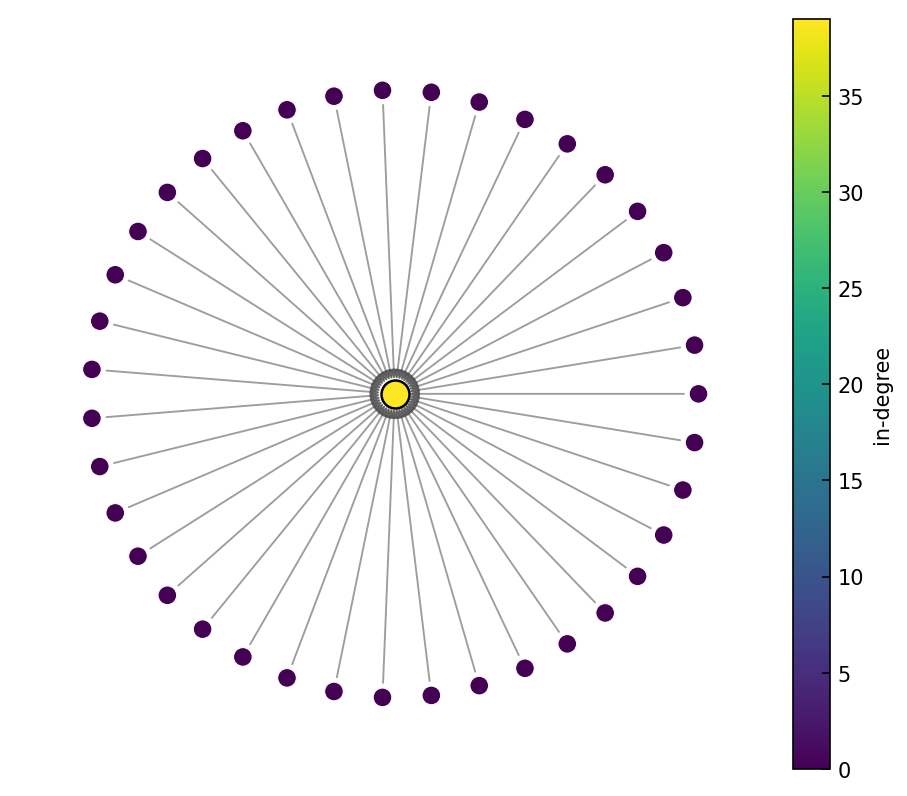

pearson [ 2.00000001  2.00000001  2.00000001  2.00000001  2.00000001  2.00000001
  2.00000001  2.00000001  2.00000001  2.00000001  2.00000001  2.00000001
  2.00000001  2.00000001  2.00000001  2.00000001  2.00000001  2.00000001
  2.00000001  2.00000001  2.00000001  2.00000001  2.00000001  2.00000001
  2.00000001  2.00000001  2.00000001  2.00000001  2.00000001  2.00000001
  2.00000001  2.00000001  2.00000001  2.00000001  2.00000001  2.00000001
  2.00000001  2.00000001  2.00000001 77.99999999]
[A_N] classified as: A_N (A/B/C) | hubs: [39] | rho=None
[A_N] BC correlation figures saved at: figs/unknown_f_AvsBC_N40_T10000_discard600_M10_grid2048_ridge0_seed0_alpha0p25_ple0_din1_dout3_20250915-164708/A_N/BCCorrection_M10_G2048_ridge0.0_tau0.4_20250915_164813


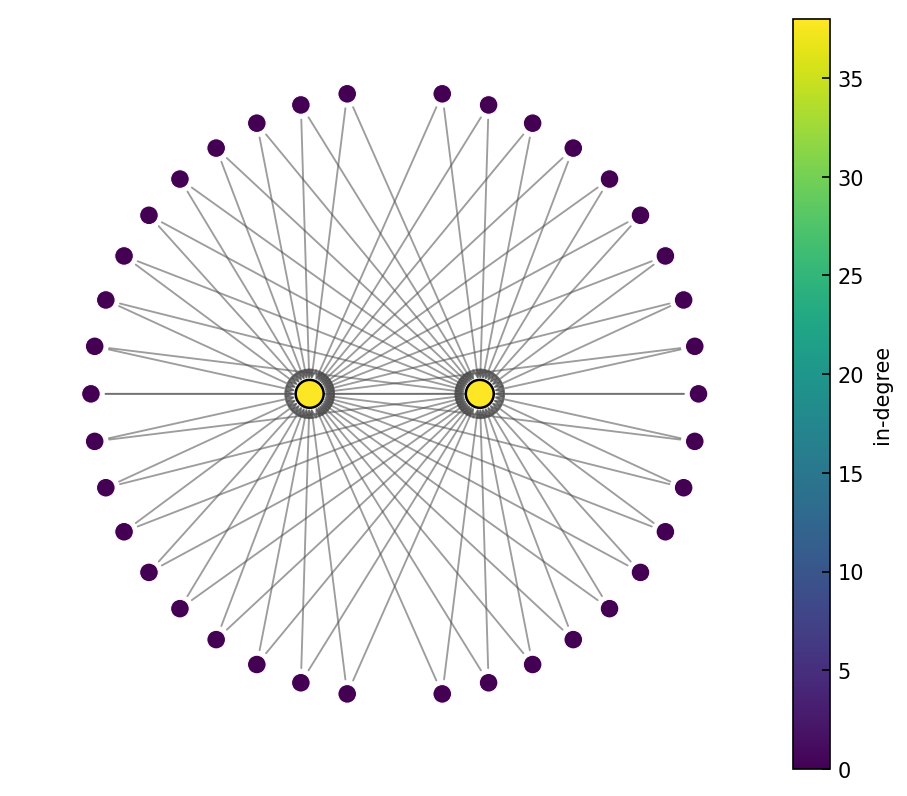

pearson [ 3.47105554  3.47105554  3.47105554  3.47105554  3.47105554  3.47105554
  3.47105554  3.47105554  3.47105554  3.47105554  3.47105554  3.47105554
  3.47105554  3.47105554  3.47105554  3.47105554  3.47105554  3.47105554
  3.47105554  3.47105554  3.47105554  3.47105554  3.47105554  3.47105554
  3.47105554  3.47105554  3.47105554  3.47105554  3.47105554  3.47105554
  3.47105554  3.47105554  3.47105554  3.47105554  3.47105554  3.47105554
  3.47105554  3.47105554 70.80718716 62.87466584]
[B_N] classified as: C_N (A/B/C) | hubs: [38 39] | rho=0.0785875610221508
[B_N] BC correlation figures saved at: figs/unknown_f_AvsBC_N40_T10000_discard600_M10_grid2048_ridge0_seed0_alpha0p25_ple0_din1_dout3_20250915-164708/B_N/BCCorrection_M10_G2048_ridge0.0_tau0.4_20250915_164926


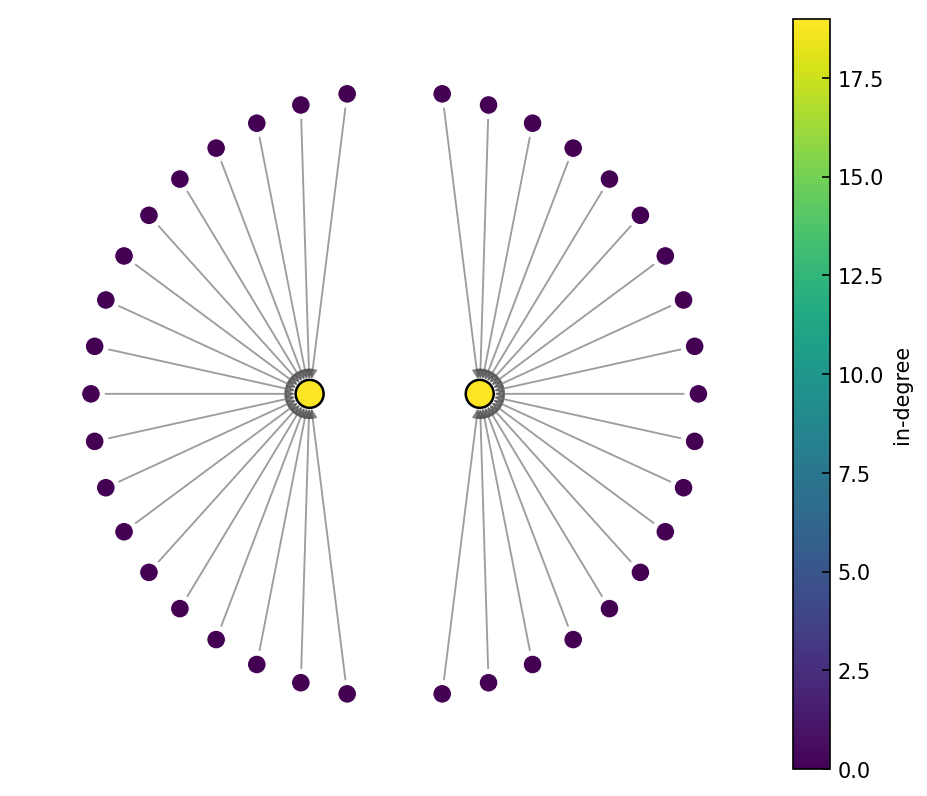

pearson [ 3.34432252  3.34432252  3.34432252  3.34432252  3.34432252  3.34432252
  3.34432252  3.34432252  3.34432252  3.34432252  3.34432252  3.34432252
  3.34432252  3.34432252  3.34432252  3.34432252  3.34432252  3.34432252
  3.34432252  3.34432252  3.34432252  3.34432252  3.34432252  3.34432252
  3.34432252  3.34432252  3.34432252  3.34432252  3.34432252  3.34432252
  3.34432252  3.34432252  3.34432252  3.34432252  3.34432252  3.34432252
  3.34432252  3.34432252 62.81097717 66.45842316]
[C_N] classified as: C_N (A/B/C) | hubs: [38 39] | rho=0.018509576104615864
[C_N] BC correlation figures saved at: figs/unknown_f_AvsBC_N40_T10000_discard600_M10_grid2048_ridge0_seed0_alpha0p25_ple0_din1_dout3_20250915-164708/C_N/BCCorrection_M10_G2048_ridge0.0_tau0.4_20250915_165007
0.45687962552693406 0.5811495717358443
[BC varY matching] label=first_is_B  | saved to: figs/unknown_f_AvsBC_N40_T10000_discard600_M10_grid2048_ridge0_seed0_alpha0p25_ple0_din1_dout3_20250915-164708/BC_varY_matching_202

In [659]:
if __name__ == "__main__":
    # ===== 你的实验超参（按需要修改）=====
    p_leaf_edge   = 0.00
    delta_in_max  = 1
    delta_out_max = 3
    seed_graph0   = 1            # 生成图/仿真的随机种子起点
    N, T, discard = 40, 10000, 600
    alpha         = 0.25       # 生成轨迹用；分类器对 f 未知
    M             = 10
    grid_size     = 2048
    ridge         = 0.0
    seed_clf      = 0            # 分类器/GMM 的随机种子

    # ---- (0) 一次运行的大文件夹（含时间戳+超参）----
    params = {
        "N": N, "T": T, "discard": discard,
        "M": M, "grid": grid_size, "ridge": ridge,
        "seed": seed_clf, "alpha": alpha,
        "p_leaf_edge": p_leaf_edge, "delta_in_max": delta_in_max, "delta_out_max": delta_out_max,
    }
    run_dir = build_run_dir_unknown_f(params, base_dir="figs", algo_tag="unknown_f_AvsBC")
    print(f"[RUN] output dir: {run_dir}")

    # h(x_h, y) = coupling(xs=y, xt=x_h) —— 按你的方向约定
    coupling  = coupling_sin2pixsiny  # 你的 Decimal 耦合：xs -> xt（y 指向 x）
    h_func, H_grid = build_numpy_h_from_decimal_grid(coupling, G=512, progress=False)

    # ---- (1) 逐个段（A/B/C）生成 → 分类 → 各自子文件夹出图 ----
    trajB = trajC = None
    outB  = outC  = None

    seed_graph = seed_graph0
    for gname, maker in [("A_N", graph_A),
                         ("B_N", graph_B),
                         ("C_N", graph_C)]:

        # 1) 生成图（兼容 maker 有/无关键字两种接口）
        try:
            A = maker(N, p_leaf_edge=p_leaf_edge,
                         delta_in_max=delta_in_max,
                         delta_out_max=delta_out_max,
                         seed=seed_graph)
        except TypeError:
            A = maker(N)  # 回退老接口

        local_map = lambda x: Decimal(2) * x % Decimal(1)
        
        #local_map = lambda x: (Decimal(4) * x*(Decimal(1)-x)) % Decimal(1)
        coupling  = coupling_sin2pixsiny  # 你的 Decimal 耦合：xs -> xt（y 指向 x）
        
        gs = GraphSystemDecimal(A, alpha=alpha, local_map=local_map, coupling_fn=coupling, seed=seed_graph)
        seed_graph += 1

        # 2) 子文件夹：A_N / B_N / C_N
        subdir = ensure_subdir(run_dir, gname)

        # 3) 可选保存图结构（若有 gs.plot_graph）
        if hasattr(gs, "plot_graph"):
            try:
                gs.plot_graph(savepath=os.path.join(subdir, "graph.png"))
            except TypeError:
                try:
                    gs.plot_graph()
                    plt.savefig(os.path.join(subdir, "graph.png"), dpi=300, bbox_inches="tight")
                    plt.close()
                except Exception:
                    pass

        # 4) 仿真
        traj = gs.run(T, discard)

        # 5) 你的 A/B/C 分类管线（可假设能正确识别 A）
        out = classify_ABC_pipeline_auto(
            traj=traj,
            M=M,
            grid_size=grid_size,
            ridge=ridge,
            seed=seed_clf,
            tau=0.4,                       # 论文建议 0.3~0.6；默认 0.4
        )
        print(f"[{gname}] classified as: {out['label_final']} (A/B/C) | hubs: {out['hubs_idx']} | rho={out.get('rho_hubs')}")

        # 6) 你已有的保存
        node_labels = np.arange(traj.shape[0])  # 节点编号
        save_all_plots_unknown_f(
            result=out,
            outdir=subdir,
            node_labels=node_labels,
            title_suffix=f"{gname}, M={M}, grid={grid_size}, ridge={ridge}",
            annotate_bar="hubs"
        )
        bc_corr_dir = save_bc_correlation_figures(
            traj=traj,
            result=out,
            outdir_graph=subdir,     # 就放在该段的子文件夹下
            params=params,
            tau=0.4,                 # 与分类用阈值一致
            m_h_vec=m_h_vec_default
        )
        print(f"[{gname}] BC correlation figures saved at: {bc_corr_dir}")

        # 7) 可选：保存该段的 \hat f 在网格上的预测（便于附录/验证）
        try:
            grid = np.linspace(0.0, 1.0, 64, endpoint=False)
            f_grid = evaluate_f_hat(out["f_hat"], grid)
            np.save(os.path.join(subdir, "f_hat_grid_x.npy"), grid)
            np.save(os.path.join(subdir, "f_hat_grid_fx.npy"), f_grid)
        except Exception:
            pass

        # 收集 B/C 两段（供 varY 匹配使用）
        if gname == "B_N":
            trajB, outB = traj, out
        elif gname == "C_N":
            trajC, outC = traj, out

    # ---- (2) 两段匹配：纯 varY 法（无 correction、无 e） ----
    resduialB=0
    allNumberB=0
    allResduialB=0
    for i in range(T-discard-1):
        if abs(trajB[N-2,i]-trajB[N-1,i]<1e-3):
            allResduialB+=abs(trajB[N-2,i+1]-trajB[N-1,i+1])**2
            allNumberB+=1
    
    resduialC=0
    allNumberC=0
    allResduialC=0
    for i in range(T-discard-1):
        if abs(trajC[N-2,i]-trajC[N-1,i]<1e-3):
            allResduialC+=abs(trajC[N-2,i+1]-trajC[N-1,i+1])**2
            allNumberC+=1
    
    print(allResduialB/allNumberB,allResduialC/allNumberC)
            
    
    if (trajB is not None) and (trajC is not None):
        h_func, H_grid = build_numpy_h_from_decimal_grid(coupling, G=512, progress=False)
        meta_varY = classify_BC_two_segments_varY(
            traj1=trajB, traj2=trajC,
            out1_algo1=outB, out2_algo1=outC,
            h_func=h_func,
            N=N,
            save_root=run_dir,
            n_samples_lambda=100_000, burn_in=2_000, n_chains=8, thinning=5,
            y_for_var_max=4096,
            seed=seed_clf
        )
        print(f"[BC varY matching] label={meta_varY['label']}  | saved to: {meta_varY['outdir']}")
    else:
        print("[WARN] 本次运行未同时生成 B_N 与 C_N 段，跳过 varY 匹配。")

    print(f"[OK] All figures & data saved to: {run_dir}")


In [ ]:
#此后代码没用

In [356]:
# ========================= ADD-ON: 可视化与适配工具 =========================
import os, time, json
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Dict, Any, List, Tuple
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --- 与你保持一致的 JSON 安全化 ---
def _to_jsonable(obj):
    import numpy as np
    if isinstance(obj, dict):   return {k:_to_jsonable(v) for k,v in obj.items()}
    if isinstance(obj, (list,tuple)): return [_to_jsonable(v) for v in obj]
    if isinstance(obj, (np.integer,)):  return int(obj)
    if isinstance(obj, (np.floating,)): return float(obj)
    if isinstance(obj, (np.bool_,)):    return bool(obj)
    if isinstance(obj, np.ndarray):     return obj.tolist()
    return obj

def _ts_dir(root: str, tag: str) -> str:
    ts = time.strftime("%Y%m%d_%H%M%S")
    out = os.path.join(root, f"{tag}_{ts}")
    os.makedirs(out, exist_ok=True)
    return out

def moddiff(z: np.ndarray) -> np.ndarray:
    return ((z + 0.5) % 1.0) - 0.5

# ---------- 1) hub 经验测度（把两个 hub 的时间序列拼起来，降方差） ----------
def hub_empirical_series(traj: np.ndarray, hubs_idx: np.ndarray) -> np.ndarray:
    seqs = []
    for h in np.atleast_1d(hubs_idx)[:2]:
        seqs.append(traj[h, :])
    return np.concatenate(seqs, axis=0)

def plot_density_1d(samples: np.ndarray, out_png: str, title: str):
    fig, ax = plt.subplots(figsize=(6.4, 3.8))
    ax.hist(samples, bins=256, range=(0,1), density=True, alpha=0.9)
    ax.set_xlim(0,1); ax.set_xlabel("x in [0,1)"); ax.set_ylabel("density")
    ax.set_title(title)
    plt.tight_layout(); plt.savefig(out_png, dpi=240, bbox_inches="tight"); plt.close(fig)

# ---------- 2) 从 f̂ 抽样 λ，并画 λ 直方图、h̄ 曲线（基于样本） ----------
def hbar_from_samples_factory(h_func: Callable[[np.ndarray, np.ndarray], np.ndarray],
                              y_samples: np.ndarray) -> Callable[[np.ndarray], np.ndarray]:
    Y = np.atleast_1d(y_samples)
    def hbar_vec(xh: np.ndarray) -> np.ndarray:
        # xh: (T,) ; 计算 E_y h(xh,y) ≈ 平均
        H = h_func(np.atleast_1d(xh)[:, None], Y[None, :])  # (T, S)
        return H.mean(axis=1)
    return hbar_vec

def plot_hbar_curve(hbar_vec: Callable[[np.ndarray], np.ndarray], out_png: str, G: int = 1024):
    grid = np.linspace(0.0, 1.0, G, endpoint=False)
    hb   = hbar_vec(grid)
    fig, ax = plt.subplots(figsize=(6.4, 3.6))
    ax.plot(grid, hb, lw=1.2)
    ax.set_xlim(0,1); ax.set_xlabel("x"); ax.set_ylabel(r"$\bar h(x)$")
    ax.set_title(r"$\bar h(x)=\int h(x,y)\,d\lambda(y)$ (from empirical $\lambda$)")
    plt.tight_layout(); plt.savefig(out_png, dpi=240, bbox_inches="tight"); plt.close(fig)

# ---------- 3) 为某个 hub 选择“代表性叶子”用于二维联合测度 ----------
def select_leaf_for_hub_by_corr(traj: np.ndarray,
                                hub_idx: int,
                                models_all: List['TrigMap'],
                                h_func: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> Tuple[int, float]:
    """
    选择与 hub 残差最相关的叶子（按 Corr(h(x_h, x_j), residual_h) 最大的 |corr|）。
    返回：(leaf_index, corr_value)
    """
    xh = traj[hub_idx, :-1]                    # (T-1,)
    yh = traj[hub_idx,  1:]
    r_h = moddiff(yh - models_all[hub_idx].predict_next(xh))  # (T-1,)
    leaves = np.setdiff1d(np.arange(traj.shape[0]), hub_idx)
    X = traj[leaves, :-1]                      # (L, T-1)
    Hvals = h_func(xh[None, :], X)             # (L, T-1)
    Hc = Hvals - Hvals.mean(axis=1, keepdims=True)
    rc = r_h - r_h.mean()
    denom = np.linalg.norm(Hc, axis=1) * (np.linalg.norm(rc) + 1e-12)
    corr = (Hc @ rc) / (denom + 1e-12)         # (L,)
    j_local = int(np.argmax(np.abs(corr)))
    return int(leaves[j_local]), float(corr[j_local])

# ---------- 4) 3D：联合测度 vs 乘积测度 ----------
def plot_joint_vs_product_3d(x_h: np.ndarray, x_leaf: np.ndarray,
                             hub_samples_for_marginal: np.ndarray,
                             lambda_samples: np.ndarray,
                             out_png: str, bins: int = 64, title: str = "") -> Dict[str, float]:
    """
    - x_h, x_leaf: 来自真实序列（长度 ~T）
    - hub_samples_for_marginal: 用于估计中心节点边际（建议用 x_h 自身，或合并两个 hub）
    - lambda_samples: 从 f̂ 抽样得到的 λ
    """
    H2, xedges, yedges = np.histogram2d(x_h, x_leaf, bins=bins,
                                        range=[[0,1],[0,1]], density=True)
    xc = 0.5 * (xedges[:-1] + xedges[1:])
    yc = 0.5 * (yedges[:-1] + yedges[1:])
    # 边际
    dens_h, _ = np.histogram(hub_samples_for_marginal, bins=xedges, density=True)
    dens_l, _ = np.histogram(lambda_samples,          bins=yedges, density=True)
    Zprod = np.outer(dens_h, dens_l)                  # (bins, bins)

    Xg, Yg = np.meshgrid(xc, yc, indexing='ij')

    # 3D
    fig = plt.figure(figsize=(8.0, 5.8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(Xg, Yg, H2, rstride=1, cstride=1, alpha=0.7, linewidth=0, antialiased=True)
    ax.plot_wireframe(Xg, Yg, Zprod, rstride=3, cstride=3, color='k', linewidth=0.6, alpha=0.9)
    ax.set_xlabel("hub x"); ax.set_ylabel("leaf y"); ax.set_zlabel("density")
    ax.set_title(title if title else "Joint vs. Product density")
    plt.tight_layout(); plt.savefig(out_png, dpi=230, bbox_inches="tight"); plt.close(fig)

    # TV 距离（对密度做积分近似）
    dx = (xedges[1]-xedges[0]); dy = (yedges[1]-yedges[0])
    TV = 0.5 * float(np.sum(np.abs(H2 - Zprod)) * dx * dy)
    return {"tv_joint_product": TV}

# ---------- 5) 每个序列的“附加可视化”主函数（不改你已有匹配函数） ----------
def save_segment_extras(traj: np.ndarray,
                        out_algo1: Dict[str, Any],
                        h_func: Callable[[np.ndarray, np.ndarray], np.ndarray],
                        save_dir: str,
                        seg_tag: str,
                        n_samples: int = 100_000, burn_in: int = 2_000,
                        n_chains: int = 8, thinning: int = 5, seed: int = 0) -> Dict[str, Any]:
    """
    对单个序列做：
      - 用该段 f̂ 抽样 λ 并画直方图
      - 画 \bar h(x)
      - 画 hub 经验密度（两个 hub 合并）
      - 选一个 hub 与一个代表叶子，画“联合 vs 乘积”的 3D 对比
    说明：不返回 traj/out 的原始信息，以免与上游结构冲突。
    """
    os.makedirs(save_dir, exist_ok=True)
    f_hat  = out_algo1["f_hat"]
    hubs   = np.atleast_1d(out_algo1["hubs_idx"]).astype(int)
    models = out_algo1["models"]

    # 1) 抽样 λ
    Y = sample_invariant_from_fhat(f_hat, n_samples=n_samples, burn_in=burn_in,
                                   n_chains=n_chains, thinning=thinning, seed=seed)
    plot_density_1d(Y, os.path.join(save_dir, f"{seg_tag}_lambda_hist.png"),
                    title=f"{seg_tag}: empirical invariant measure λ")

    # 2) 画 \bar h(x)
    hbar_vec = hbar_from_samples_factory(h_func, Y)
    plot_hbar_curve(hbar_vec, os.path.join(save_dir, f"{seg_tag}_hbar_curve.png"), G=1024)

    # 3) hub 经验密度（两个 hub 合并）
    hub_data = hub_empirical_series(traj, hubs)
    plot_density_1d(hub_data, os.path.join(save_dir, f"{seg_tag}_hub_density.png"),
                    title=f"{seg_tag}: empirical hub density")

    # 4) 选一个 hub 与代表叶子，画联合 vs 乘积（3D）
    hub_chosen = int(hubs[0])
    leaf_idx, corr_val = select_leaf_for_hub_by_corr(traj, hub_chosen, models, h_func)
    x_h  = traj[hub_chosen, :-1]
    x_l  = traj[leaf_idx,  :-1]
    tvd  = plot_joint_vs_product_3d(
        x_h, x_l, hub_samples_for_marginal=x_h, lambda_samples=Y,
        out_png=os.path.join(save_dir, f"{seg_tag}_joint_vs_product_3D.png"),
        bins=64, title=f"{seg_tag}: joint vs product (hub={hub_chosen}, leaf={leaf_idx})"
    )
    # 返回概要
    return {
        "seg_tag": seg_tag,
        "hub_chosen": hub_chosen,
        "leaf_chosen": leaf_idx,
        "corr_h_leaf": corr_val,
        "tv_joint_product": tvd["tv_joint_product"],
        "lambda_sample_size": int(n_samples)
    }

# ---------- 6) 一键：运行你已有的两段匹配 + 附加可视化（最小改动接入） ----------
def run_two_segment_match_with_emp_lambda_and_extras(
        traj1: np.ndarray, traj2: np.ndarray,
        h_func: Callable[[np.ndarray, np.ndarray], np.ndarray],
        M: int = 10, ridge: float = 0.0, seed: int = 0,
        save_root: str = "figs",
        n_samples: int = 100_000, burn_in: int = 2_000,
        n_chains: int = 8, thinning: int = 5
    ) -> Dict[str, Any]:
    """
    不改动你已有的 run_two_segment_match_with_emp_lambda：
      1) 先调用它完成两段匹配（α^2 能量法）+ 基础图 + meta
      2) 重新各自跑一次 算法1 拿到 out1/out2（hubs/models/f̂）
      3) 对两个序列分别调用 save_segment_extras 画附加图
    """
    # 1) 你的现成入口（保持接口不变）
    base = run_two_segment_match_with_emp_lambda(
        traj1, traj2, h_func=h_func, M=M, ridge=ridge, seed=seed,
        save_root=save_root, n_samples=n_samples, burn_in=burn_in,
        n_chains=n_chains, thinning=thinning
    )
    outdir_base = base["outdir"]
    # 2) 算法1：各段 A vs BC（为拿到 hubs/models/f̂；不改你已有逻辑）
    out1 = classify_A_vs_BC_unknown_f(traj1, M=M, grid_size=2048, ridge=ridge,
                                      seed=seed, return_indices=True, return_fhat=True)
    out2 = classify_A_vs_BC_unknown_f(traj2, M=M, grid_size=2048, ridge=ridge,
                                      seed=seed+1, return_indices=True, return_fhat=True)

    # 3) 附加可视化（每段独立的 λ、h̄、hub 密度、二维联合 vs 乘积）
    extras_dir = _ts_dir(outdir_base, "BC_extras")
    seg1_info = save_segment_extras(
        traj1, out1, h_func, extras_dir, seg_tag="seg1",
        n_samples=n_samples, burn_in=burn_in, n_chains=n_chains, thinning=thinning, seed=seed
    )
    seg2_info = save_segment_extras(
        traj2, out2, h_func, extras_dir, seg_tag="seg2",
        n_samples=n_samples, burn_in=burn_in, n_chains=n_chains, thinning=thinning, seed=seed+1
    )
    # 4) 汇总 meta
    summary = {
        "outdir": outdir_base,
        "extras_dir": extras_dir,
        "matching_label": base.get("label"),
        "seg1": seg1_info,
        "seg2": seg2_info
    }
    with open(os.path.join(extras_dir, "extras_meta.json"), "w", encoding="utf-8") as f:
        json.dump(_to_jsonable(summary), f, indent=2, ensure_ascii=False)
    print(f"[EXTRAS] saved to {extras_dir}")
    return summary

# ---------- 7) 若你的耦合是 Decimal 版本，提供浮点包装 → h_func ----------
from decimal import Decimal
def make_h_from_coupling_decimal(coupling_fn) -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
    """
    将 Decimal 耦合函数 coupling_fn(xs, xt) 封装成 h_func(xh, X)
    - xh: (T-1,), 表示 hub 的时间序列
    - X : (m, T-1), 叶子时间序列矩阵
    返回: (m, T-1)，元素为 coupling_fn(xs=X[i,t], xt=xh[t]) 的浮点化结果
    注意：此实现为通用循环版，简洁但较慢；若有 NumPy 向量表达式，建议改为纯向量化。
    """
    def h_func(xh: np.ndarray, X: np.ndarray) -> np.ndarray:
        xh = np.atleast_1d(xh)
        X  = np.atleast_2d(X)
        m, Tm = X.shape[0], X.shape[-1]
        assert xh.shape[-1] == Tm, "xh 和 X 的时间长度必须一致"
        out = np.empty((m, Tm), dtype=float)
        for t in range(Tm):
            xt = Decimal(str(xh[t]))  # 目标 hub
            for i in range(m):
                ys = Decimal(str(X[i, t]))  # 源叶子
                out[i, t] = float(coupling_fn(ys, xt))  # 顺序：xs=叶, xt=hub
        return out
    return h_func



A_N  → classify_ABC → A_N
B_N  → classify_ABC → B_N and C_N
C_N  → classify_ABC → B_N and C_N

B/C decision: first_is_B
D_BC=3.150e-01 (seg1=B, seg2=C) | D_CB=1.071e+00 (seg1=C, seg2=B)
alpha^2 under (B,C) = (0.0864600922015174, 0.06309466447546742)
alpha^2 under (C,B) = (0.0432300461007587, 0.12618932895093485)


A_N  → classify_ABC → A_N
B_N  → classify_ABC → B_N and C_N
C_N  → classify_ABC → B_N and C_N

B/C decision: first_is_B
D_BC=3.141e-01 (seg1=B, seg2=C) | D_CB=1.072e+00 (seg1=C, seg2=B)
alpha^2 under (B,C) = (0.08562910549884833, 0.06254701302597973)
alpha^2 under (C,B) = (0.04281455274942417, 0.12509402605195946)


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
B/C star-network classifier via alpha^2-consistency and hub empirical law.

This module provides:
  1) A high-precision coupled-map simulator on a directed graph with states on
     the one-dimensional torus T = R/Z (represented by [0, 1)).
  2) Star-graph generators for types A, B, and C.
  3) Utilities to detect hubs from data (2-component GMM on per-node errors).
  4) Segment-level statistics for hubs:
       - residual variance V (from a least-squares regression y ~ m_h(x)),
       - empirical expectation K_hat = <K(x_t)> using the hub time series,
     where m_h(x) = ∫ h(x,y) dm(y) and K(x) = Var_y[h(x,y)] are known in closed form.
  5) A parameter-free B-vs-C classifier that uses two time segments with a
     common (unknown) coupling strength α and decides which segment is B and
     which is C by comparing the consistency of the implied α^2 under the
     two topological hypotheses.

Default model (matches the math write-up):
  - Local map: f(x) = 2 x (mod 1).
  - Coupling  : h(x, y) = 2 sin(x) sin(y).  (x, y are angles in radians.)
  - Invariant measure for leaves: Lebesgue on the circle.
  - Normalization: the coupling term at node i is divided by Δ = max in-degree.

Dependencies:
  numpy, mpmath, scikit-learn (GaussianMixture).
"""

from __future__ import annotations

from decimal import Decimal, getcontext
from typing import Callable, Tuple, Dict, Any

import mpmath as mp
import numpy as np
from sklearn.mixture import GaussianMixture


# ---------------------------------------------------------------------
# Global precision for Decimal and mpmath (used in the simulator)
# ---------------------------------------------------------------------
getcontext().prec = 200     # Decimal precision
mp.mp.dps = getcontext().prec


# ---------------------------------------------------------------------
# High-precision network simulator
# ---------------------------------------------------------------------
class GraphSystemDecimal:
    """
    Coupled-map lattice on a directed graph with high-precision arithmetic.

    State space: one-dimensional torus T = R/Z (represented by [0, 1)).
    Update rule for node n (mod 1):
        x_n(t+1) = f(x_n(t)) + (alpha / Delta) * sum_{j: A[j, n]=1} h(x_n(t), x_j(t)),
    where Delta = max in-degree over all nodes.

    Parameters
    ----------
    A : np.ndarray (N x N)
        Directed adjacency matrix. A[j, i] = 1 means edge j -> i (j contributes to i).
    alpha : str
        Coupling strength as a string, parsed into Decimal for precision.
    local_map : Callable[[Decimal], Decimal], optional
        Local map f acting on Decimal in [0,1). Default: doubling map (2*x) % 1.
    coupling_fn : Callable[[Decimal, Decimal], Decimal], optional
        Pairwise coupling h(xs, xt) from source xs to target xt. Default: 2 sin xs sin xt.
    seed : int
        RNG seed for i.i.d. Uniform(0,1) initialization of the states.

    Attributes
    ----------
    N : int
        Number of nodes.
    Delta : float
        Maximum in-degree (max column sum of A), used for normalization.
    x : list[Decimal]
        Current state vector.
    """

    def __init__(
        self,
        A: np.ndarray,
        alpha: str = "0.25",
        local_map: Callable[[Decimal], Decimal] | None = None,
        coupling_fn: Callable[[Decimal, Decimal], Decimal] | None = None,
        seed: int = 0,
    ):
        self.A = np.asarray(A, dtype=float)
        self.N = self.A.shape[0]
        # Max in-degree (column sum) for normalization
        self.Delta = self.A.sum(axis=0).max()
        self.alpha = Decimal(alpha)
        # Default local map: doubling map on the circle
        self.local_map = local_map or (lambda z: (Decimal(2) * z) % 1)
        # Default coupling: h(xs, xt) = 2 sin xs sin xt
        self.coupling = coupling_fn or coupling_sin_sin
        self.rng = np.random.default_rng(seed)
        self.reset()

    def _coupling_term(self) -> list[Decimal]:
        """
        Compute the normalized coupling increment for each node.

        Returns
        -------
        list[Decimal]
            For each node i, the quantity (1/Delta) * sum_{j} A[j, i] * h(x_j, x_i).
        """
        incr = [Decimal(0)] * self.N
        for j in range(self.N):
            if self.A[j].sum() == 0:
                continue  # node j has no outgoing edges
            for i in range(self.N):
                if self.A[j, i]:
                    incr[i] += self.coupling(self.x[j], self.x[i])
        d = Decimal(str(self.Delta))
        return [v / d for v in incr]

    def step(self) -> list[Decimal]:
        """
        Advance the system by one step: x <- f(x) + alpha * coupling (mod 1).

        Returns
        -------
        list[Decimal]
            The updated state vector.
        """
        xn = [self.local_map(x) for x in self.x]  # apply f
        coup = self._coupling_term()
        xn = [(xi + self.alpha * ci) % 1 for xi, ci in zip(xn, coup)]
        self.x = xn
        return xn

    def reset(self) -> None:
        """Reset states to i.i.d. Uniform(0,1) in Decimal precision."""
        self.x = [Decimal(str(v)) for v in self.rng.random(self.N)]

    def run(self, T: int, discard: int = 0) -> np.ndarray:
        """
        Simulate for T steps and return the trajectory after discarding a transient.

        Parameters
        ----------
        T : int
            Total number of simulation steps.
        discard : int
            Number of initial steps to discard as transient.

        Returns
        -------
        np.ndarray
            Array of shape (N, max(0, T - discard)) with float64 snapshots of states.
        """
        traj = np.zeros((self.N, max(0, T - discard)))
        for k in range(T):
            xt = self.step()
            if k >= discard:
                traj[:, k - discard] = [float(v) for v in xt]
        return traj


# ---------------------------------------------------------------------
# Star graph generators (A: single hub; B: two hubs, all leaves to both;
# C: two hubs, leaves split into two disjoint halves)
# ---------------------------------------------------------------------
def graph_A(N: int) -> np.ndarray:
    """Star with one hub at index N-1 (all leaves point to the hub)."""
    A = np.zeros((N, N))
    A[np.arange(N - 1), N - 1] = 1
    return A


def graph_B(N: int) -> np.ndarray:
    """Two hubs at indices N-2 and N-1; every leaf connects to both hubs."""
    A = np.zeros((N, N))
    leaves = np.arange(N - 2)
    A[leaves, N - 1] = 1
    A[leaves, N - 2] = 1
    return A


def graph_C(N: int) -> np.ndarray:
    """
    Two hubs at indices N-2 and N-1; the leaves (0..N-3) are split evenly:
    first half -> hub N-2, second half -> hub N-1.
    """
    A = np.zeros((N, N))
    L = N - 2       # number of leaves
    half = L // 2
    first = np.arange(0, half)
    second = np.arange(half, L)
    A[first, N - 2] = 1
    A[second, N - 1] = 1
    return A

def graph_A_like(N: int) -> np.ndarray:
    """Star with one hub at index N-1 (all leaves point to the hub)."""
    A = np.zeros((N, N))
    A[np.arange(N - 1), N - 1] = 1
    return A


def graph_B_like(N: int) -> np.ndarray:
    """Two hubs at indices N-2 and N-1; every leaf connects to both hubs."""
    A = np.zeros((N, N))
    leaves = np.arange(N - 2)
    A[leaves, N - 1] = 1
    A[leaves, N - 2] = 1
    A_leaves=np.arange(0,int(N/3)-2)
    B_leaves=np.arange(int(N*2/3),N-2)
    A[A_leaves,N-1]=0
    A[B_leaves,N-2]=0
    return A


def graph_C_like(N: int) -> np.ndarray:
    """
    Two hubs at indices N-2 and N-1; the leaves (0..N-3) are split evenly:
    first half -> hub N-2, second half -> hub N-1.
    """
    A = np.zeros((N, N))
    L = N - 2       # number of leaves
    half = L // 2
    first = np.arange(0, half)
    second = np.arange(half, L)
    A[first, N - 2] = 1
    A[second, N - 1] = 1
    return A


# ---------------------------------------------------------------------
# Model-specific h, its integral m_h, and the variance kernel K
#   h(x, y) = 2 sin x sin y   (angles in radians)
#   m_h(x)  = ∫ h(x, y) dm(y) = C1 sin x
#   K(x)    = Var_y[h(x, y)]  = CK sin^2 x
# ---------------------------------------------------------------------
def coupling_sin_sin(xs: Decimal, xt: Decimal) -> Decimal:
    """High-precision coupling: h(xs, xt) = 2 sin(xs) sin(xt)."""
    v = 2.0 * float(mp.sin(mp.mpf(str(xs)))) * float(mp.sin(mp.mpf(str(xt))))
    return Decimal(str(v))


C1 = 2.0 * (1.0 - np.cos(1.0))                       # coefficient in m_h(x)
CK = (2.0 - np.sin(2.0)) - C1**2                     # coefficient in K(x)


def doubling_vec(u: np.ndarray) -> np.ndarray:
    """Vectorized local map f(x) = 2x (mod 1) acting elementwise."""
    return (2.0 * u) % 1.0


def Ih_vec(u: np.ndarray) -> np.ndarray:
    """Vectorized m_h(x) = C1 * sin(x)."""
    return C1 * np.sin(u)


def K_vec(u: np.ndarray) -> np.ndarray:
    """Vectorized K(x) = CK * sin(x)^2."""
    return CK * np.sin(u) ** 2


# ---------------------------------------------------------------------
# Utilities: modular difference, node-wise strength, and hub detection
# ---------------------------------------------------------------------
def moddiff(u: np.ndarray) -> np.ndarray:
    """
    Wrap values into (-0.5, 0.5] by subtracting the nearest integer.
    Useful for measuring errors on the circle.
    """
    return ((u + 0.5) % 1.0) - 0.5


def compute_strength(traj: np.ndarray) -> np.ndarray:
    """
    Per-node mean absolute innovation relative to the local map:
      S_i = < |x_{t+1,i} - f(x_{t,i})|_{mod 1} >_t.

    Parameters
    ----------
    traj : np.ndarray (N x T)

    Returns
    -------
    np.ndarray (N,)
        Mean wrapped absolute error for each node.
    """
    x, x1 = traj[:, :-1], traj[:, 1:]
    Delta = moddiff(x1 - doubling_vec(x))
    return np.abs(Delta).mean(axis=1)


def gmm_hubs(S: np.ndarray, seed: int = 0) -> np.ndarray:
    """
    Identify hubs by a 2-component Gaussian Mixture Model (GMM) fitted to S.
    The component with the larger mean is labeled as hubs.

    Parameters
    ----------
    S : np.ndarray (N,)
        Node-wise strengths.
    seed : int

    Returns
    -------
    np.ndarray (N,) of bool
        True for nodes classified as hubs.
    """
    g = GaussianMixture(2, random_state=seed).fit(S.reshape(-1, 1))
    return g.predict(S.reshape(-1, 1)) == np.argmax(g.means_)


# ---------------------------------------------------------------------
# Residual variance at a single hub:
#   y_t = x_{t+1} - f(x_t)   (wrapped)
#   s_t = m_h(x_t)
#   beta = argmin_b || y + b * s ||_2^2  =  -(y·s)/(s·s)
#   residual r_t = y_t + beta s_t
#   V = Var_t(r_t)
# ---------------------------------------------------------------------
def resid_var_one(traj_i: np.ndarray, eps: float = 1e-12) -> float:
    """
    Residual variance for a single node time series.

    Parameters
    ----------
    traj_i : np.ndarray (T,)
        Time series of a single hub.
    eps : float
        Threshold to guard against division by zero in LS.

    Returns
    -------
    float
        Variance of residuals r_t = y_t + beta s_t.
    """
    x = traj_i[:-1]
    y = moddiff(traj_i[1:] - doubling_vec(x))
    s = Ih_vec(x)
    denom = float(s @ s)
    beta = 0.0 if denom < eps else -(y @ s) / denom
    resid = y + beta * s
    return float(np.var(resid))


# ---------------------------------------------------------------------
# Segment-level statistics for hubs:
#   V_hat = mean residual variance across the two hubs,
#   K_hat = mean of K(x_t) across the two hubs (i.e. empirical E K(x))
# ---------------------------------------------------------------------
def hub_stats_segment(traj: np.ndarray, seed: int = 0) -> Tuple[float, float, np.ndarray]:
    """
    Compute (V_hat, K_hat) for a single B/C candidate segment.

    Parameters
    ----------
    traj : np.ndarray (N x T)
        Segment trajectory.
    seed : int
        RNG seed used by GMM.

    Returns
    -------
    (V_hat, K_hat, hubs)
        V_hat : float
            Mean residual variance across the two hubs in the segment.
        K_hat : float
            Mean of K(x_t) across the two hubs (empirical expectation).
        hubs : np.ndarray (size 2)
            Indices of the two hubs.
    """
    S = compute_strength(traj)
    hubs = np.where(gmm_hubs(S, seed=seed))[0]
    if hubs.size != 2:
        raise RuntimeError("This segment is not type B/C (number of hubs ≠ 2).")
    V_list, K_list = [], []
    for i in hubs:
        xi = traj[i]
        V_list.append(resid_var_one(xi))
        K_list.append(float(np.mean(K_vec(xi[:-1]))))  # empirical E[K(x)] along the hub
    V_hat = float(np.mean(V_list))
    K_hat = float(np.mean(K_list))
    return V_hat, K_hat, hubs


# ---------------------------------------------------------------------
# Single-segment coarse classification: A vs (B/C)
# ---------------------------------------------------------------------
def classify_A_and_BC(traj: np.ndarray, N: int) -> str:
    """
    Decide whether a single segment corresponds to A (one hub) or B/C (two hubs).

    Returns
    -------
    str : "A_N" or "B_N and C_N"
    """
    S = compute_strength(traj)
    hubs = np.where(gmm_hubs(S))[0]
    return "A_N" if hubs.size == 1 else "B_N and C_N"


# ---------------------------------------------------------------------
# Two-segment B vs C classifier via alpha^2-consistency
#   For each segment s (s=1,2):
#      - compute V_s and K_s from the hubs,
#      - form S_{s,B} = F_B K_s, S_{s,C} = F_C K_s,
#   Then compare the two hypotheses: (seg1=B, seg2=C) vs (seg1=C, seg2=B)
#   by the log-mismatch of the implied alpha^2.
# ---------------------------------------------------------------------
def classify_B_vs_C_two_segments(
    traj1: np.ndarray, traj2: np.ndarray, N: int, seed: int = 0
) -> Dict[str, Any]:
    """
    Classify which of the two segments is B and which is C under the assumption
    that both segments share the same (unknown) coupling strength alpha.

    Parameters
    ----------
    traj1, traj2 : np.ndarray (N x T)
        Two B/C candidate segments.
    N : int
        Number of nodes in the graph.
    seed : int
        RNG seeds used by the GMM calls.

    Returns
    -------
    dict
        A dictionary with the decision and useful diagnostics:
          - 'label'      : 'first_is_B' or 'first_is_C'
          - 'alpha2_BC'  : (alpha^2 estimate if seg1=B, seg2=C)
          - 'alpha2_CB'  : (alpha^2 estimate if seg1=C, seg2=B)
          - 'D_BC','D_CB': log-mismatches under the two hypotheses
          - 'V1','K1','V2','K2'
          - 'hubs1','hubs2'
          - 'fac_B','fac_C' (the topology factors used)
    """
    V1, K1, hubs1 = hub_stats_segment(traj1, seed=seed)
    V2, K2, hubs2 = hub_stats_segment(traj2, seed=seed + 1)

    # Topology factors d/Delta^2 (choose the convention you prefer).
    # Here we use: B → 1/(N-2), C → 1/(N/2 - 1).
    fac_B = 1.0 / (N - 2)
    fac_C = 1.0 / (N // 2 - 1)

    # Theoretical scalings without alpha^2
    S1B, S1C = fac_B * K1, fac_C * K1
    S2B, S2C = fac_B * K2, fac_C * K2

    # Alpha^2 estimates under the two global assignments
    a2_1_B, a2_2_C = V1 / S1B, V2 / S2C  # hypothesis: (seg1=B, seg2=C)
    a2_1_C, a2_2_B = V1 / S1C, V2 / S2B  # hypothesis: (seg1=C, seg2=B)

    # Log-mismatch of alpha^2 under each hypothesis
    D_BC = abs(np.log(a2_1_B) - np.log(a2_2_C))
    D_CB = abs(np.log(a2_1_C) - np.log(a2_2_B))

    label = "first_is_B" if D_BC < D_CB else "first_is_C"

    return {
        "label": label,
        "alpha2_BC": (a2_1_B, a2_2_C),
        "alpha2_CB": (a2_1_C, a2_2_B),
        "D_BC": D_BC,
        "D_CB": D_CB,
        "V1": V1,
        "K1": K1,
        "V2": V2,
        "K2": K2,
        "hubs1": hubs1,
        "hubs2": hubs2,
        "fac_B": fac_B,
        "fac_C": fac_C,
    }


# ---------------------------------------------------------------------
# Demonstration
# ---------------------------------------------------------------------
if __name__ == "__main__":
    N, T, discard = 50, 8000, 800
    alpha = "0.25"

    # 1) Single-segment A vs (B/C)
    for gname, maker in [("A_N", graph_A), ("B_N", graph_B), ("C_N", graph_C)]:
        traj = GraphSystemDecimal(maker(N), alpha=alpha, seed=hash(gname) % 2**32).run(
            T, discard
        )
        print(f"{gname}  → classify_ABC → {classify_A_and_BC(traj, N)}")

    # 2) Two segments: B vs C (alpha unknown but identical across segments)
    trajB = GraphSystemDecimal(graph_B_like(N), alpha=alpha, seed=1).run(T, discard)
    trajC = GraphSystemDecimal(graph_C_like(N), alpha=alpha, seed=2).run(T, discard)

    out = classify_B_vs_C_two_segments(trajB, trajC, N)
    print("\nB/C decision:", out["label"])
    print(
        f"D_BC={out['D_BC']:.3e} (seg1=B, seg2=C) | "
        f"D_CB={out['D_CB']:.3e} (seg1=C, seg2=B)"
    )
    print(f"alpha^2 under (B,C) = {out['alpha2_BC']}")
    print(f"alpha^2 under (C,B) = {out['alpha2_CB']}")
